In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_13374/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


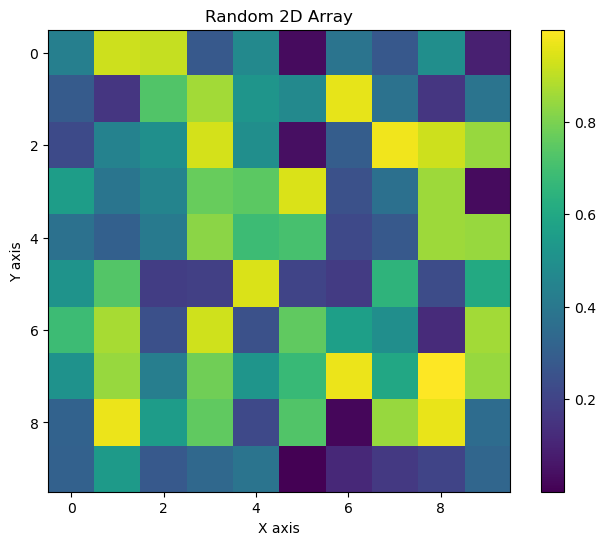

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_coin = 0, # swap할 수 있는 coin 개수

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 

                    I_wanna_sweep_at_this_epoch = -1,
                    dvs_duration_domain = [],

                    extra_train_dataset = 0,

                    num_workers = 2,
                    chaching_on = False,
                    pin_memory = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                           include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                           exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path
                           )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on,
            my_seed,
            extra_train_dataset,
            num_workers,
            chaching_on,
            pin_memory)
    synapse_fc_out_features = CLASS_NUM
    test_loader_domain_set = []
    test_loader_domain_set.append(test_loader)
    ###########################################################################################################################################
    
    ## 다른 dvs duration domain을 validation set으로 불러오기 ##############################################################
    if len(dvs_duration_domain) > 0:
        for domain in dvs_duration_domain:
            train_loader_domain, test_loader_domain, synapse_conv_in_channels_domain, CLASS_NUM_domain = data_loader(
                    which_data,
                    data_path, 
                    rate_coding, 
                    BATCH, 
                    IMAGE_SIZE,
                    ddp_on,
                    TIME,
                    domain[1], # dvs_clipping
                    domain[0], # dvs_duration
                    exclude_class,
                    merge_polarities,
                    denoise_on,
                    my_seed,
                    extra_train_dataset,
                    num_workers,
                    chaching_on,
                    pin_memory)
            test_loader_domain_set.append(test_loader_domain)
    ######################################################################################################################
    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME

    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss= 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    DFA_BP_toggle_trial = 0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (I_wanna_sweep_at_this_epoch == epoch):
            net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
            no_val_best_growth_count = 0
            DFA_current = not DFA_current
            DFA_toggle = True
            DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
        else:
            if (e_transport_swap > 0 or e_transport_swap_tr > 0):
                assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
                if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap :
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_val_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
                if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_tr_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            else:
                assert False, 'data length is not 2 or 3'
            #######################################################################################################################
                
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################         
                               
            if merge_polarities == True:
                inputs = inputs[:,:,0,:,:]

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################


            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                iter_loss = criterion(outputs, labels)
                iter_loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                iter_loss = 0.0
                for t in range(TIME):
                    ### input[t] --> net --> output_one_time #########################################
                    outputs_one_time = net(inputs[t])
                    ##################################################################################
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    iter_loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                iter_loss /= TIME
            tr_epoch_loss_temp += iter_loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")
                
            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                domain_index = 0
                val_loss_set = []
                val_acc_now_set = []
                while True:
                    val_loss = 0
                    correct_val = 0
                    total_val = 0
                    test_loader = test_loader_domain_set[domain_index]
                    domain_index = domain_index + 1

                    with torch.no_grad():
                        net.eval() # eval 모드로 바꿔줘야함 
                        for data_val in test_loader:
                            ## data_val loading & semi-pre-processing ##########################################################
                            if len(data_val) == 2:
                                inputs_val, labels_val = data_val
                                # 처리 로직 작성
                            elif len(data_val) == 3:
                                inputs_val, labels_val, x_len = data_val
                                # print('x_len',x_len)
                                # mask = padded_sequence_mask(x_len)
                                # max_time_step = x_len.max()
                                # min_time_step = x_len.min()
                                # B, T, *spatial_dims = inputs_val.shape
                            else:
                                assert False, 'data_val length is not 2 or 3'

                            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                                inputs_val = inputs_val.permute(1, 0, 2, 3, 4)
                            elif rate_coding == True :
                                inputs_val = spikegen.rate(inputs_val, num_steps=TIME)
                            else :
                                inputs_val = inputs_val.repeat(TIME, 1, 1, 1, 1)
                            # inputs_val: [Time, Batch, Channel, Height, Width]  
                            ###################################################################################################

                            inputs_val = inputs_val.to(device)
                            labels_val = labels_val.to(device)
                            real_batch = labels_val.size(0)
                            
                            ## DVS gesture에서 other label자리 매꾸기 ###############
                            if (which_data == 'DVS_GESTURE'):
                                labels_val[labels_val>2] -= 1
                            #######################################################
                            
                            if merge_polarities == True:
                                inputs_val = inputs_val[:,:,0,:,:]

                            ## network 연산 시작 ############################################################################################################
                            if single_step == False:
                                outputs = net(inputs_val.permute(1, 0, 2, 3, 4)) #inputs_val: [Batch, Time, Channel, Height, Width]  
                                val_loss_val += criterion(outputs, labels_val)/len(test_loader)
                            else:
                                outputs_all = []
                                for t in range(TIME):
                                    outputs = net(inputs_val[t])
                                    val_loss_temp = criterion(outputs, labels_val)
                                    outputs_all.append(outputs.detach())
                                    val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                                outputs_all = torch.stack(outputs_all, dim=1)
                                outputs = outputs_all.mean(1)
                            val_loss_set.append(val_loss)
                            #################################################################################################################################

                            _, predicted = torch.max(outputs.data, 1)
                            total_val += real_batch
                            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                            correct_val += (predicted == labels_val).sum().item()

                        val_acc_now = correct_val / total_val
                        # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')
                        val_acc_now_set.append(val_acc_now)

                    if domain_index == len(dvs_duration_domain) + 1:
                        break

                val_loss = val_loss_set[0]
                val_acc_now = val_acc_now_set[0]

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter_loss:{iter_loss:10.6f}, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                    if len(dvs_duration_domain) > 0:
                        dvs_duration_full = [(dvs_duration, dvs_clipping)] + dvs_duration_domain
                        print(" | ".join(f"{dvs_duration_full[i][0]:,}c{dvs_duration_full[i][1]}:{val_acc_now_set[i]*100:.2f}%" for i in range(len(val_acc_now_set))))
                    iter_of_val = False
            
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)


            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board (Gesture) ########################
# decay = 0.75 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = False # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "5",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','CIFAR10','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0, # 1.3102821334243646,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 10000, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 3.0, # 2.570969004857107 # sigmoid류에서는 alpha값 4.0, rectangle류에서는 width값 0.5

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 # cfg = ['M',200],
#                 # cfg = [200,200],
#                 cfg = ['M','M',200,200],
#                 # cfg = ['M',200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, #0.1 bptt, #0.01 ottt, # default 0.001  # ottt 0.1 # nda 0.001 # 0.00936191669529645
#                 epoch_num = 200,
#                 verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'sigmoid' 'rectangle' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'no', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 4, #일반적으로 1 또는 2 # 100ms때는 5 # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # gesture: 100_000c1-5, 25_000c5, 10_000c5, 1_000c5, 1_000_000c5

#                 dvs_duration = 25_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐
#                 # nmnist 5_000us, gesture는 100_000us, 25_000us

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = False, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_coin = 1, # swap할 수 있는 coin 개수

#                 drop_rate = 0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 denoise_on = False, # True # False

#                 I_wanna_sweep_at_this_epoch = -1, # 지정 에포크에서 BP와 DFA를 바꿔줌. -1이면 실행 안함.
#                 dvs_duration_domain=[],
#                 # dvs_duration_domain = [(10_000,1),(10_000,2),(10_000,3),(10_000,4),(10_000,5),
#                 #                             (25_000,1),(25_000,2),(25_000,3),(25_000,4),(25_000,5),
#                 #                             (50_000,1),(50_000,2),(50_000,3),(50_000,4),(50_000,5),
#                 #                             (75_000,1),(75_000,2),(75_000,3),(75_000,4),(75_000,5),
#                 #                             (100_000,1),(100_000,2),(100_000,3),(100_000,4),(100_000,5)], # domain adaptation할 때 사용할 dvs_duration 리스트
                
#                 extra_train_dataset = 0,

#                 num_workers = 4,
#                 chaching_on = True, # True # False # only for certain datasets (gesture_tonic, nmnist_tonic)
#                 pin_memory = True, # True # False
#                 ) 

# # num_workers = 4 * num_GPU (or 8, 16, 2 * num_GPU)
# # entry * batch_size * num_worker = num_GPU * GPU_throughtput
# # num_workers = batch_size / num_GPU
# # num_workers = batch_size / num_CPU

# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드0
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")} 25_000 war',
    'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
    'parameters': 
    {
        "learning_rate": {"values": [0.001]}, #0.00936191669529645
        "BATCH": {"values": [16]},
        "decay": {"values": [0.125,0.25,0.5,0.75,0.875]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [10]},
        "epoch_num": {"values": [200]},
        "dvs_duration": {"values": [25_000]},
        "dvs_clipping": {"values": [4]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [False]},
        "surrogate": {"values": ['hard_sigmoid']},
        "DFA_on": {"values": [False]},
        "OTTT_input_trace_on": {"values": [False]},
        "cfg": {"values": [['M','M',200,200]]},
        "e_transport_swap": {"values": [0]},
        "e_transport_swap_tr": {"values": [0]},
        "drop_rate": {"values": [0.0]}, # "drop_rate": {"values": [0.25,0.5,0.75]}, #"drop_rate": {"min": 0.25, "max": 0.75},
        "exclude_class": {"values": [True]},
        "merge_polarities": {"values": [False]},
        "lif_layer_v_reset": {"values": [0,10000]},
        "lif_layer_sg_width": {"min": 2.0, "max": 4.0},
        "e_transport_swap_coin": {"values": [1]},
        "lif_layer_v_threshold": {"min": 0.75, "max": 1.5},
        "scheduler_name": {"values": ['no']},  # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
        "denoise_on": {"values": [False]}, 
        "I_wanna_sweep_at_this_epoch": {"values": [-1]}, 
        "dvs_duration_domain": {"values": [[(100_000,5),(20_000,4), (30_000,4)]]}, 
        "extra_train_dataset": {"values": [0,2,4]}, 
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
    cfg  =  wandb.config.cfg
    e_transport_swap  =  wandb.config.e_transport_swap
    e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
    drop_rate  =  wandb.config.drop_rate
    exclude_class  =  wandb.config.exclude_class
    merge_polarities  =  wandb.config.merge_polarities
    lif_layer_v_reset  =  wandb.config.lif_layer_v_reset
    lif_layer_sg_width  =  wandb.config.lif_layer_sg_width
    e_transport_swap_coin  =  wandb.config.e_transport_swap_coin
    lif_layer_v_threshold  =  wandb.config.lif_layer_v_threshold
    scheduler_name  =  wandb.config.scheduler_name
    denoise_on  =  wandb.config.denoise_on
    I_wanna_sweep_at_this_epoch  =  wandb.config.I_wanna_sweep_at_this_epoch
    dvs_duration_domain  =  wandb.config.dvs_duration_domain
    extra_train_dataset  =  wandb.config.extra_train_dataset
    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "5",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = lif_layer_v_threshold,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = lif_layer_v_reset, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = lif_layer_sg_width, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                # cfg = [200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = scheduler_name, # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_coin = e_transport_swap_coin, # swap할 수 있는 coin 개수
                    
                drop_rate = drop_rate,

                exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외

                merge_polarities = merge_polarities, # True # False # tonic dvs dataset 에서 polarities 합치기
                denoise_on = denoise_on,

                I_wanna_sweep_at_this_epoch = I_wanna_sweep_at_this_epoch,
                dvs_duration_domain = dvs_duration_domain,

                extra_train_dataset = extra_train_dataset,

                num_workers = 4,
                chaching_on = True,
                pin_memory = True, # True # False
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True
    
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# sweep_id = 'l5ge5qio'
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ri6z6iba
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/ri6z6iba


wandb: Agent Starting Run: nxm4dq5g with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 2
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 3.511999038961904
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 1.2552299551732513
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manuall

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 371fb670b0ca62edce2d1edb1c1d9a86
cache path exists
dataset_hash = d7ae1cd3c4cd714845e88ac58039ebb2
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 5ebecf0e3bab2c498c13539ec455b01c
cache path exists
dataset_hash = 5489e2299a9a9800497ee0b268e57a2e
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = e23ccf67573c8d5c713ded8d8f190308
cache path exists
dataset_hash = 8b6ceaaf06a8e08314448b2612e57433
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 374162cd4dc183cffe4ac24f2cf1eecd
cache path exists
dataset_hash = 8171f843c23829b58e1ee51e94df45a9
cache path exists
dataset_hash = eabab481e3ce84e1916e477516c9af9

epoch-0   lr=['0.0010000'], tr/val_loss:  2.304701/  2.302898, tr:   9.50%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.96it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-1   lr=['0.0010000'], tr/val_loss:  2.305049/  2.302847, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.11it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-2   lr=['0.0010000'], tr/val_loss:  2.304471/  2.303058, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-3   lr=['0.0010000'], tr/val_loss:  2.304915/  2.303135, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-4   lr=['0.0010000'], tr/val_loss:  2.304868/  2.302889, tr:   9.43%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-5   lr=['0.0010000'], tr/val_loss:  2.304831/  2.302766, tr:   8.75%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-6   lr=['0.0010000'], tr/val_loss:  2.304599/  2.302941, tr:  10.01%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:16<00:00, 15.55it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-6   lr=['0.0010000'], tr/val_loss:  2.304599/  2.302941, tr:  10.01%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.76it/s]
epoch-7   lr=['0.0010000'], tr/val_loss:  2.304944/  2.302759, tr:   8.72%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:23<00:00,  7.99it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-8   lr=['0.0010000'], tr/val_loss:  2.305151/  2.302967, tr:  10.11%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.36it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-9   lr=['0.0010000'], tr/val_loss:  2.304682/  2.303071, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.61it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-10  lr=['0.0010000'], tr/val_loss:  2.304989/  2.303130, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.13it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-11  lr=['0.0010000'], tr/val_loss:  2.305207/  2.302759, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.83it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-12  lr=['0.0010000'], tr/val_loss:  2.305001/  2.302710, tr:   8.65%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.69it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-13  lr=['0.0010000'], tr/val_loss:  2.304598/  2.302782, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-14  lr=['0.0010000'], tr/val_loss:  2.304182/  2.303216, tr:  10.08%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-15  lr=['0.0010000'], tr/val_loss:  2.304534/  2.302883, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-16  lr=['0.0010000'], tr/val_loss:  2.304888/  2.302832, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.50it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-17  lr=['0.0010000'], tr/val_loss:  2.305288/  2.302773, tr:   8.61%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-18  lr=['0.0010000'], tr/val_loss:  2.304546/  2.302898, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.42it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-19  lr=['0.0010000'], tr/val_loss:  2.304861/  2.302717, tr:   8.24%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-20  lr=['0.0010000'], tr/val_loss:  2.305198/  2.302705, tr:   8.75%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-21  lr=['0.0010000'], tr/val_loss:  2.304874/  2.302801, tr:   9.57%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.47it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-22  lr=['0.0010000'], tr/val_loss:  2.304994/  2.302869, tr:   9.74%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-23  lr=['0.0010000'], tr/val_loss:  2.304693/  2.302737, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.36it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-24  lr=['0.0010000'], tr/val_loss:  2.304657/  2.302879, tr:   9.33%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.41it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-25  lr=['0.0010000'], tr/val_loss:  2.304827/  2.302756, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-26  lr=['0.0010000'], tr/val_loss:  2.304611/  2.302974, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.53it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-27  lr=['0.0010000'], tr/val_loss:  2.304502/  2.302734, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-28  lr=['0.0010000'], tr/val_loss:  2.304528/  2.302664, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.26it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-29  lr=['0.0010000'], tr/val_loss:  2.304275/  2.302837, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-30  lr=['0.0010000'], tr/val_loss:  2.304687/  2.302721, tr:   8.99%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-31  lr=['0.0010000'], tr/val_loss:  2.305102/  2.302904, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-32  lr=['0.0010000'], tr/val_loss:  2.304600/  2.303019, tr:   9.33%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.42it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-33  lr=['0.0010000'], tr/val_loss:  2.305165/  2.302836, tr:   8.55%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-34  lr=['0.0010000'], tr/val_loss:  2.304571/  2.303054, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.19it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-35  lr=['0.0010000'], tr/val_loss:  2.304963/  2.302749, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-36  lr=['0.0010000'], tr/val_loss:  2.304457/  2.302829, tr:   9.43%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-37  lr=['0.0010000'], tr/val_loss:  2.304570/  2.302962, tr:  10.01%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-38  lr=['0.0010000'], tr/val_loss:  2.305092/  2.302973, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.20it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-39  lr=['0.0010000'], tr/val_loss:  2.304858/  2.302809, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-40  lr=['0.0010000'], tr/val_loss:  2.304746/  2.302870, tr:   8.92%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-41  lr=['0.0010000'], tr/val_loss:  2.304897/  2.303062, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.10it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-42  lr=['0.0010000'], tr/val_loss:  2.305104/  2.302700, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-43  lr=['0.0010000'], tr/val_loss:  2.305466/  2.302897, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.14it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-44  lr=['0.0010000'], tr/val_loss:  2.304672/  2.302727, tr:   9.77%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-45  lr=['0.0010000'], tr/val_loss:  2.304667/  2.302923, tr:   8.55%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:25<00:00,  7.28it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-46  lr=['0.0010000'], tr/val_loss:  2.304961/  2.302831, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.14it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-47  lr=['0.0010000'], tr/val_loss:  2.304731/  2.302732, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.27it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-48  lr=['0.0010000'], tr/val_loss:  2.304863/  2.302760, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:20<00:00,  9.19it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-49  lr=['0.0010000'], tr/val_loss:  2.304889/  2.302868, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.71it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-50  lr=['0.0010000'], tr/val_loss:  2.304309/  2.303099, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.69it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-51  lr=['0.0010000'], tr/val_loss:  2.304741/  2.303033, tr:   9.57%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.84it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-52  lr=['0.0010000'], tr/val_loss:  2.304596/  2.303030, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.73it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-53  lr=['0.0010000'], tr/val_loss:  2.304795/  2.303447, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-54  lr=['0.0010000'], tr/val_loss:  2.304919/  2.302781, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.71it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-55  lr=['0.0010000'], tr/val_loss:  2.304965/  2.302786, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.56it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-56  lr=['0.0010000'], tr/val_loss:  2.304878/  2.303198, tr:   9.43%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:18<00:00,  9.77it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-57  lr=['0.0010000'], tr/val_loss:  2.305097/  2.302854, tr:   9.84%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:26<00:00,  7.03it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-58  lr=['0.0010000'], tr/val_loss:  2.304546/  2.302957, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.71it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-59  lr=['0.0010000'], tr/val_loss:  2.304863/  2.303210, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-60  lr=['0.0010000'], tr/val_loss:  2.304699/  2.302697, tr:   8.34%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.67it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-61  lr=['0.0010000'], tr/val_loss:  2.304199/  2.303298, tr:   9.94%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.84it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-62  lr=['0.0010000'], tr/val_loss:  2.304724/  2.302816, tr:   9.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.69it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-63  lr=['0.0010000'], tr/val_loss:  2.304218/  2.302762, tr:   9.26%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.62it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-64  lr=['0.0010000'], tr/val_loss:  2.304443/  2.302733, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.72it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-65  lr=['0.0010000'], tr/val_loss:  2.305425/  2.302886, tr:   8.75%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.60it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-66  lr=['0.0010000'], tr/val_loss:  2.304565/  2.302987, tr:   9.91%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.70it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-67  lr=['0.0010000'], tr/val_loss:  2.304509/  2.302905, tr:   8.78%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.79it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-68  lr=['0.0010000'], tr/val_loss:  2.304682/  2.302910, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.77it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-69  lr=['0.0010000'], tr/val_loss:  2.304596/  2.302836, tr:   9.33%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.60it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-70  lr=['0.0010000'], tr/val_loss:  2.304497/  2.302967, tr:   9.94%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.71it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-71  lr=['0.0010000'], tr/val_loss:  2.304946/  2.302918, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.44it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-72  lr=['0.0010000'], tr/val_loss:  2.304494/  2.302665, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.78it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-73  lr=['0.0010000'], tr/val_loss:  2.304729/  2.302828, tr:   9.02%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.61it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-74  lr=['0.0010000'], tr/val_loss:  2.304508/  2.302820, tr:   9.94%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.62it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-75  lr=['0.0010000'], tr/val_loss:  2.304876/  2.302641, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.64it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-76  lr=['0.0010000'], tr/val_loss:  2.305228/  2.302700, tr:   8.61%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.81it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-77  lr=['0.0010000'], tr/val_loss:  2.304716/  2.302905, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.68it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-78  lr=['0.0010000'], tr/val_loss:  2.304781/  2.302871, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-79  lr=['0.0010000'], tr/val_loss:  2.304738/  2.302802, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.88it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-80  lr=['0.0010000'], tr/val_loss:  2.304602/  2.302613, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.58it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-81  lr=['0.0010000'], tr/val_loss:  2.305041/  2.302780, tr:   9.60%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.57it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-82  lr=['0.0010000'], tr/val_loss:  2.304770/  2.302885, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.75it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-83  lr=['0.0010000'], tr/val_loss:  2.304781/  2.302740, tr:   8.65%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.63it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-84  lr=['0.0010000'], tr/val_loss:  2.304692/  2.302862, tr:   8.68%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-85  lr=['0.0010000'], tr/val_loss:  2.304709/  2.303035, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.53it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-86  lr=['0.0010000'], tr/val_loss:  2.304757/  2.302802, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.77it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-87  lr=['0.0010000'], tr/val_loss:  2.304913/  2.302757, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.71it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-88  lr=['0.0010000'], tr/val_loss:  2.304642/  2.302796, tr:   9.19%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:15<00:00, 12.89it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-88  lr=['0.0010000'], tr/val_loss:  2.304642/  2.302796, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]
epoch-89  lr=['0.0010000'], tr/val_loss:  2.304918/  2.302677, tr:   8.78%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.22it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-90  lr=['0.0010000'], tr/val_loss:  2.304437/  2.302972, tr:   8.68%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-91  lr=['0.0010000'], tr/val_loss:  2.304606/  2.302819, tr:   8.99%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.75it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-92  lr=['0.0010000'], tr/val_loss:  2.304915/  2.302830, tr:   8.61%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-93  lr=['0.0010000'], tr/val_loss:  2.304466/  2.302727, tr:   9.67%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.72it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-94  lr=['0.0010000'], tr/val_loss:  2.304645/  2.302866, tr:   9.60%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-95  lr=['0.0010000'], tr/val_loss:  2.304572/  2.302773, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.87it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-96  lr=['0.0010000'], tr/val_loss:  2.304789/  2.302846, tr:   9.91%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-97  lr=['0.0010000'], tr/val_loss:  2.304363/  2.302878, tr:   9.87%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:15<00:00, 15.62it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-97  lr=['0.0010000'], tr/val_loss:  2.304363/  2.302878, tr:   9.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]
epoch-98  lr=['0.0010000'], tr/val_loss:  2.304337/  2.302959, tr:   9.57%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.49it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-99  lr=['0.0010000'], tr/val_loss:  2.304485/  2.303096, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.48it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-100 lr=['0.0010000'], tr/val_loss:  2.304922/  2.302786, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.14it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-101 lr=['0.0010000'], tr/val_loss:  2.304379/  2.303004, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.47it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-102 lr=['0.0010000'], tr/val_loss:  2.305221/  2.302943, tr:   7.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.61it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-103 lr=['0.0010000'], tr/val_loss:  2.304484/  2.302905, tr:   9.67%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.25it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-104 lr=['0.0010000'], tr/val_loss:  2.304436/  2.303404, tr:  10.28%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.70it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-105 lr=['0.0010000'], tr/val_loss:  2.304495/  2.302736, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.15it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-106 lr=['0.0010000'], tr/val_loss:  2.304782/  2.302908, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.13it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-107 lr=['0.0010000'], tr/val_loss:  2.304556/  2.302709, tr:   9.64%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.56it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-108 lr=['0.0010000'], tr/val_loss:  2.304682/  2.303129, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:18<00:00,  9.88it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-109 lr=['0.0010000'], tr/val_loss:  2.304856/  2.302679, tr:   9.60%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.49it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-110 lr=['0.0010000'], tr/val_loss:  2.304499/  2.302662, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-111 lr=['0.0010000'], tr/val_loss:  2.304522/  2.302818, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.25it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-112 lr=['0.0010000'], tr/val_loss:  2.304713/  2.302772, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.14it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-113 lr=['0.0010000'], tr/val_loss:  2.304495/  2.302791, tr:   8.55%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.25it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-114 lr=['0.0010000'], tr/val_loss:  2.304878/  2.302815, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.57it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-115 lr=['0.0010000'], tr/val_loss:  2.305024/  2.302674, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.81it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-116 lr=['0.0010000'], tr/val_loss:  2.304419/  2.302667, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.45it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-117 lr=['0.0010000'], tr/val_loss:  2.304816/  2.302841, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-118 lr=['0.0010000'], tr/val_loss:  2.304724/  2.302945, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-119 lr=['0.0010000'], tr/val_loss:  2.304582/  2.302740, tr:   9.23%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.03it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-120 lr=['0.0010000'], tr/val_loss:  2.305262/  2.302809, tr:   8.55%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.79it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-121 lr=['0.0010000'], tr/val_loss:  2.304975/  2.302840, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.68it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-122 lr=['0.0010000'], tr/val_loss:  2.305171/  2.303011, tr:   9.26%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-123 lr=['0.0010000'], tr/val_loss:  2.304766/  2.302961, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.58it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-124 lr=['0.0010000'], tr/val_loss:  2.305329/  2.302812, tr:   8.34%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-125 lr=['0.0010000'], tr/val_loss:  2.304794/  2.302995, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.57it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-126 lr=['0.0010000'], tr/val_loss:  2.304699/  2.302794, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.60it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-127 lr=['0.0010000'], tr/val_loss:  2.304606/  2.302985, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-128 lr=['0.0010000'], tr/val_loss:  2.304550/  2.302904, tr:   9.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.68it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-129 lr=['0.0010000'], tr/val_loss:  2.304591/  2.302676, tr:   9.26%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.55it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-130 lr=['0.0010000'], tr/val_loss:  2.304402/  2.302775, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.56it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-131 lr=['0.0010000'], tr/val_loss:  2.304672/  2.302660, tr:   8.65%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-132 lr=['0.0010000'], tr/val_loss:  2.304704/  2.302662, tr:   9.06%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-133 lr=['0.0010000'], tr/val_loss:  2.304848/  2.302852, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.48it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-134 lr=['0.0010000'], tr/val_loss:  2.304656/  2.302721, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:18<00:00, 10.19it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-135 lr=['0.0010000'], tr/val_loss:  2.304609/  2.302926, tr:   9.67%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-136 lr=['0.0010000'], tr/val_loss:  2.304577/  2.302838, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.98it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-137 lr=['0.0010000'], tr/val_loss:  2.304849/  2.302774, tr:   9.02%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.21it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-138 lr=['0.0010000'], tr/val_loss:  2.305064/  2.302826, tr:   8.82%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-139 lr=['0.0010000'], tr/val_loss:  2.304632/  2.302695, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.03it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-140 lr=['0.0010000'], tr/val_loss:  2.305275/  2.302747, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.94it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-141 lr=['0.0010000'], tr/val_loss:  2.304449/  2.302669, tr:   8.72%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:18<00:00, 10.07it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-142 lr=['0.0010000'], tr/val_loss:  2.304650/  2.302779, tr:   9.02%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.19it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-143 lr=['0.0010000'], tr/val_loss:  2.304541/  2.302899, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.91it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-144 lr=['0.0010000'], tr/val_loss:  2.304890/  2.303035, tr:   9.26%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.91it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-145 lr=['0.0010000'], tr/val_loss:  2.305219/  2.302930, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.76it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-146 lr=['0.0010000'], tr/val_loss:  2.304939/  2.302845, tr:   8.51%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:16<00:00, 14.82it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-146 lr=['0.0010000'], tr/val_loss:  2.304939/  2.302845, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]
epoch-147 lr=['0.0010000'], tr/val_loss:  2.304733/  2.302911, tr:   9.19%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:16<00:00, 11.22it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-147 lr=['0.0010000'], tr/val_loss:  2.304733/  2.302911, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 10.89it/s]
epoch-148 lr=['0.0010000'], tr/val_loss:  2.304603/  2.302922, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.79it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-149 lr=['0.0010000'], tr/val_loss:  2.305036/  2.302848, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.64it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-150 lr=['0.0010000'], tr/val_loss:  2.304132/  2.302844, tr:   9.77%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-151 lr=['0.0010000'], tr/val_loss:  2.304896/  2.302775, tr:   9.09%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 183/184 [00:16<00:00, 14.67it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-151 lr=['0.0010000'], tr/val_loss:  2.304896/  2.302775, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.65it/s]
epoch-152 lr=['0.0010000'], tr/val_loss:  2.304881/  2.302693, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.45it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-153 lr=['0.0010000'], tr/val_loss:  2.304943/  2.302924, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-154 lr=['0.0010000'], tr/val_loss:  2.304679/  2.302694, tr:   9.06%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-155 lr=['0.0010000'], tr/val_loss:  2.304275/  2.302820, tr:   9.53%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.46it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-156 lr=['0.0010000'], tr/val_loss:  2.304526/  2.302753, tr:   9.67%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-157 lr=['0.0010000'], tr/val_loss:  2.304464/  2.302699, tr:   8.38%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-158 lr=['0.0010000'], tr/val_loss:  2.304837/  2.302766, tr:   8.34%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-159 lr=['0.0010000'], tr/val_loss:  2.304965/  2.302834, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-160 lr=['0.0010000'], tr/val_loss:  2.304663/  2.302882, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-161 lr=['0.0010000'], tr/val_loss:  2.304375/  2.302815, tr:   9.57%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-162 lr=['0.0010000'], tr/val_loss:  2.304685/  2.302839, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:15<00:00, 11.51it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-163 lr=['0.0010000'], tr/val_loss:  2.304785/  2.302890, tr:   9.47%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-164 lr=['0.0010000'], tr/val_loss:  2.304520/  2.303152, tr:   9.40%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-165 lr=['0.0010000'], tr/val_loss:  2.304707/  2.302946, tr:   9.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.21it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-166 lr=['0.0010000'], tr/val_loss:  2.305261/  2.302808, tr:   8.31%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-167 lr=['0.0010000'], tr/val_loss:  2.305251/  2.302807, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-168 lr=['0.0010000'], tr/val_loss:  2.304836/  2.302896, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-169 lr=['0.0010000'], tr/val_loss:  2.304974/  2.302783, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.46it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-170 lr=['0.0010000'], tr/val_loss:  2.304635/  2.302803, tr:   9.12%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-171 lr=['0.0010000'], tr/val_loss:  2.304495/  2.302946, tr:   9.33%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.22it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-172 lr=['0.0010000'], tr/val_loss:  2.305326/  2.302985, tr:   9.06%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-173 lr=['0.0010000'], tr/val_loss:  2.304407/  2.302898, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-174 lr=['0.0010000'], tr/val_loss:  2.304770/  2.302807, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.44it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-175 lr=['0.0010000'], tr/val_loss:  2.304466/  2.302679, tr:   9.02%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-176 lr=['0.0010000'], tr/val_loss:  2.304391/  2.302764, tr:   9.50%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.36it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-177 lr=['0.0010000'], tr/val_loss:  2.304424/  2.302875, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-178 lr=['0.0010000'], tr/val_loss:  2.304969/  2.302877, tr:   8.85%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.26it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-179 lr=['0.0010000'], tr/val_loss:  2.304654/  2.302926, tr:   9.23%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.44it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-180 lr=['0.0010000'], tr/val_loss:  2.304476/  2.302896, tr:   9.33%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-181 lr=['0.0010000'], tr/val_loss:  2.304802/  2.302758, tr:   8.99%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.20it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-182 lr=['0.0010000'], tr/val_loss:  2.304546/  2.303010, tr:   8.44%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.50it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-183 lr=['0.0010000'], tr/val_loss:  2.304614/  2.302963, tr:  10.01%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-184 lr=['0.0010000'], tr/val_loss:  2.304545/  2.302694, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.20it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-185 lr=['0.0010000'], tr/val_loss:  2.304435/  2.302907, tr:   9.87%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-186 lr=['0.0010000'], tr/val_loss:  2.304868/  2.302737, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  2.304380/  2.302912, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-188 lr=['0.0010000'], tr/val_loss:  2.305189/  2.302778, tr:   8.58%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-189 lr=['0.0010000'], tr/val_loss:  2.304370/  2.302870, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:17<00:00, 10.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-190 lr=['0.0010000'], tr/val_loss:  2.304487/  2.302774, tr:   9.43%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-191 lr=['0.0010000'], tr/val_loss:  2.304587/  2.302735, tr:   8.68%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.23it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-192 lr=['0.0010000'], tr/val_loss:  2.305077/  2.303025, tr:   8.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-193 lr=['0.0010000'], tr/val_loss:  2.305020/  2.302949, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.21it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-194 lr=['0.0010000'], tr/val_loss:  2.305026/  2.302868, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-195 lr=['0.0010000'], tr/val_loss:  2.304590/  2.302881, tr:   9.16%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-196 lr=['0.0010000'], tr/val_loss:  2.305057/  2.302984, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-197 lr=['0.0010000'], tr/val_loss:  2.304544/  2.303315, tr:  10.15%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-198 lr=['0.0010000'], tr/val_loss:  2.304865/  2.302779, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-199 lr=['0.0010000'], tr/val_loss:  2.304819/  2.302729, tr:   8.51%, val:  10.00%, val_best:  10.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]


25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iter_acc,▆▃▃▃▃▃▃▃▃▆▃▃█▆▃▃▆▆▁▃▁▆▃▃▆▃▁▃▃▃▃▆▆▃▆██▃▁▃
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▆▅▅▄▅▅▆▃▃▅▂▆▁▂▃▇▅▄▂▇▅█▂▅▅▁▄▆▂▂▄▄▄▇▅▃▄▇▂▆
tr_epoch_loss,▆▅▅▃▅▃▁▅▄▅▅▅▄█▅▂▄▄▂▄▂▂▂▆▅▇▃▃▇▅▆▃▃▄▂▄▃▂▃▆
val_acc_best,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▅▃▂▃▃▂▃▃▃▂▁▃▃▂▂▅▄▃▅█▁▁▃▂▁▃▂▃▃▁▃▄▄▂▃▃▂▄
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: ut3nymce with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 2
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.1678887319104554
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.9923976713892538
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manu

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 371fb670b0ca62edce2d1edb1c1d9a86
cache path exists
dataset_hash = d7ae1cd3c4cd714845e88ac58039ebb2
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 5ebecf0e3bab2c498c13539ec455b01c
cache path exists
dataset_hash = 5489e2299a9a9800497ee0b268e57a2e
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = e23ccf67573c8d5c713ded8d8f190308
cache path exists
dataset_hash = 8b6ceaaf06a8e08314448b2612e57433
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 374162cd4dc183cffe4ac24f2cf1eecd
cache path exists
dataset_hash = 8171f843c23829b58e1ee51e94df45a9
cache path exists
dataset_hash = eabab481e3ce84e1916e477516c9af9

epoch-0   lr=['0.0010000'], tr/val_loss:  2.244622/  2.075081, tr:  18.32%, val:  35.00%, val_best:  35.00%: 100%|██████████| 184/184 [00:15<00:00, 11.57it/s]

25,000c4:35.00% | 100,000c5:35.83% | 20,000c4:34.17% | 30,000c4:35.83%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.712310/  1.804849, tr:  48.01%, val:  52.08%, val_best:  52.08%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:52.08% | 100,000c5:47.08% | 20,000c4:49.58% | 30,000c4:51.25%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.468222/  1.821208, tr:  58.22%, val:  44.17%, val_best:  52.08%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:44.17% | 100,000c5:47.08% | 20,000c4:46.25% | 30,000c4:41.25%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.350992/  1.720429, tr:  62.21%, val:  47.08%, val_best:  52.08%: 100%|██████████| 184/184 [00:15<00:00, 11.74it/s]

25,000c4:47.08% | 100,000c5:44.17% | 20,000c4:50.83% | 30,000c4:49.17%



epoch-4   lr=['0.0010000'], tr/val_loss:  1.261310/  1.725772, tr:  67.18%, val:  47.08%, val_best:  52.08%: 100%|██████████| 184/184 [00:15<00:00, 11.75it/s]

25,000c4:47.08% | 100,000c5:47.50% | 20,000c4:47.08% | 30,000c4:51.67%



epoch-5   lr=['0.0010000'], tr/val_loss:  1.192189/  1.694180, tr:  71.74%, val:  53.75%, val_best:  53.75%: 100%|██████████| 184/184 [00:16<00:00, 11.49it/s]

25,000c4:53.75% | 100,000c5:44.58% | 20,000c4:53.75% | 30,000c4:52.92%



epoch-6   lr=['0.0010000'], tr/val_loss:  1.133731/  1.749944, tr:  74.02%, val:  52.50%, val_best:  53.75%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:52.50% | 100,000c5:48.75% | 20,000c4:53.75% | 30,000c4:50.00%



epoch-7   lr=['0.0010000'], tr/val_loss:  1.088580/  1.723831, tr:  75.69%, val:  54.58%, val_best:  54.58%: 100%|██████████| 184/184 [00:15<00:00, 11.58it/s]

25,000c4:54.58% | 100,000c5:43.75% | 20,000c4:52.92% | 30,000c4:53.33%



epoch-8   lr=['0.0010000'], tr/val_loss:  1.019028/  1.741994, tr:  78.48%, val:  55.42%, val_best:  55.42%: 100%|██████████| 184/184 [00:15<00:00, 11.65it/s]

25,000c4:55.42% | 100,000c5:47.08% | 20,000c4:54.58% | 30,000c4:55.42%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.974224/  1.754055, tr:  81.58%, val:  57.92%, val_best:  57.92%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:57.92% | 100,000c5:47.92% | 20,000c4:58.33% | 30,000c4:56.67%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.927589/  1.792497, tr:  84.61%, val:  54.58%, val_best:  57.92%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:54.58% | 100,000c5:50.00% | 20,000c4:54.17% | 30,000c4:57.50%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.875519/  1.806007, tr:  87.20%, val:  57.50%, val_best:  57.92%: 100%|██████████| 184/184 [00:15<00:00, 11.67it/s]

25,000c4:57.50% | 100,000c5:51.67% | 20,000c4:55.42% | 30,000c4:57.92%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.838135/  1.827463, tr:  87.88%, val:  57.50%, val_best:  57.92%: 100%|██████████| 184/184 [00:15<00:00, 11.64it/s]

25,000c4:57.50% | 100,000c5:51.67% | 20,000c4:56.25% | 30,000c4:57.92%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.792445/  1.882454, tr:  89.75%, val:  55.83%, val_best:  57.92%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:55.83% | 100,000c5:50.42% | 20,000c4:59.17% | 30,000c4:55.42%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.746154/  1.896455, tr:  91.76%, val:  57.50%, val_best:  57.92%: 100%|██████████| 184/184 [00:15<00:00, 11.58it/s]

25,000c4:57.50% | 100,000c5:52.92% | 20,000c4:58.75% | 30,000c4:60.42%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.699660/  1.912900, tr:  92.92%, val:  58.33%, val_best:  58.33%: 100%|██████████| 184/184 [00:16<00:00, 11.46it/s]

25,000c4:58.33% | 100,000c5:56.67% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.674141/  2.017978, tr:  93.70%, val:  54.17%, val_best:  58.33%: 100%|██████████| 184/184 [00:15<00:00, 11.50it/s]

25,000c4:54.17% | 100,000c5:56.25% | 20,000c4:55.00% | 30,000c4:57.08%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.623914/  2.011503, tr:  95.03%, val:  58.33%, val_best:  58.33%: 100%|██████████| 184/184 [00:15<00:00, 11.66it/s]

25,000c4:58.33% | 100,000c5:52.08% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.592500/  2.035882, tr:  95.27%, val:  61.25%, val_best:  61.25%: 100%|██████████| 184/184 [00:15<00:00, 11.51it/s]

25,000c4:61.25% | 100,000c5:48.33% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.556186/  2.111887, tr:  96.02%, val:  59.17%, val_best:  61.25%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:59.17% | 100,000c5:49.17% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.513693/  2.145840, tr:  96.66%, val:  59.17%, val_best:  61.25%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:59.17% | 100,000c5:50.42% | 20,000c4:60.83% | 30,000c4:61.25%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.476257/  2.161510, tr:  97.41%, val:  59.58%, val_best:  61.25%: 100%|██████████| 184/184 [00:15<00:00, 11.63it/s]

25,000c4:59.58% | 100,000c5:60.00% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.449884/  2.220138, tr:  97.79%, val:  63.33%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:63.33% | 100,000c5:51.25% | 20,000c4:58.75% | 30,000c4:62.92%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.417702/  2.290596, tr:  98.64%, val:  59.58%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.59it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:60.00%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.388178/  2.353498, tr:  98.57%, val:  60.42%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.80it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.368656/  2.378561, tr:  98.77%, val:  59.17%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.68it/s]

25,000c4:59.17% | 100,000c5:58.75% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.340190/  2.442069, tr:  98.84%, val:  62.50%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.65it/s]

25,000c4:62.50% | 100,000c5:52.50% | 20,000c4:61.67% | 30,000c4:61.25%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.317162/  2.503421, tr:  99.46%, val:  60.00%, val_best:  63.33%: 100%|██████████| 184/184 [00:15<00:00, 11.68it/s]

25,000c4:60.00% | 100,000c5:60.83% | 20,000c4:57.92% | 30,000c4:62.92%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.289319/  2.594900, tr:  99.39%, val:  61.25%, val_best:  63.33%: 100%|██████████| 184/184 [00:16<00:00, 11.46it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:62.50%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.272541/  2.608251, tr:  99.63%, val:  63.33%, val_best:  63.33%: 100%|██████████| 184/184 [00:16<00:00, 11.49it/s]

25,000c4:63.33% | 100,000c5:52.92% | 20,000c4:63.33% | 30,000c4:61.25%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.254407/  2.695684, tr:  99.63%, val:  62.08%, val_best:  63.33%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:64.17% | 30,000c4:61.25%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.228737/  2.676564, tr:  99.73%, val:  63.75%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.56it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.212633/  2.756334, tr:  99.63%, val:  62.50%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.27it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:62.50%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.202412/  2.835138, tr:  99.83%, val:  60.83%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:58.75% | 30,000c4:61.67%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.183805/  2.875914, tr:  99.90%, val:  61.25%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.72it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:61.25%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.174038/  2.982251, tr:  99.93%, val:  56.67%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:56.67% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.164208/  2.984680, tr:  99.97%, val:  63.33%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:63.33% | 100,000c5:52.08% | 20,000c4:60.83% | 30,000c4:60.42%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.154717/  3.031496, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:61.67%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.143267/  3.092340, tr:  99.97%, val:  61.25%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:61.25% | 100,000c5:58.75% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.130093/  3.147805, tr:  99.97%, val:  60.42%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.60it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:60.00%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.120889/  3.223950, tr:  99.97%, val:  61.67%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.42it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.111088/  3.209572, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.50it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.104533/  3.282374, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 184/184 [00:16<00:00, 11.42it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.099028/  3.326551, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 184/184 [00:15<00:00, 11.53it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.091399/  3.362624, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.089617/  3.410352, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:63.75% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.079237/  3.407939, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.075523/  3.485579, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.49it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:64.58% | 30,000c4:64.58%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.075387/  3.479944, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.067301/  3.531277, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:61.67% | 100,000c5:59.58% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.061542/  3.556203, tr: 100.00%, val:  60.83%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:62.50%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.060839/  3.582541, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.25it/s]

25,000c4:63.75% | 100,000c5:58.75% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.053399/  3.610524, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.45it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.052979/  3.632405, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.45it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.050319/  3.678630, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 184/184 [00:15<00:00, 11.51it/s]

25,000c4:65.00% | 100,000c5:59.17% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.047510/  3.669016, tr: 100.00%, val:  64.58%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.46it/s]

25,000c4:64.58% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.044213/  3.722203, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:65.42%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.040616/  3.731986, tr: 100.00%, val:  64.58%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.041139/  3.774560, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.34it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:63.75% | 30,000c4:63.33%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.039746/  3.809366, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 184/184 [00:15<00:00, 11.54it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:62.92%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.040855/  3.776405, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 184/184 [00:15<00:00, 11.51it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:64.17% | 30,000c4:62.08%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.035473/  3.815753, tr: 100.00%, val:  64.58%, val_best:  65.00%: 100%|██████████| 184/184 [00:16<00:00, 11.34it/s]

25,000c4:64.58% | 100,000c5:56.25% | 20,000c4:65.83% | 30,000c4:64.58%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.033033/  3.844333, tr: 100.00%, val:  65.42%, val_best:  65.42%: 100%|██████████| 184/184 [00:15<00:00, 11.52it/s]

25,000c4:65.42% | 100,000c5:57.92% | 20,000c4:64.17% | 30,000c4:67.08%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.034246/  3.842818, tr: 100.00%, val:  64.58%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:65.00% | 30,000c4:65.00%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.033252/  3.894652, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.47it/s]

25,000c4:63.75% | 100,000c5:60.83% | 20,000c4:62.92% | 30,000c4:68.75%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.031147/  3.963866, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:64.17% | 30,000c4:65.83%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.027662/  3.981542, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.12it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:65.00% | 30,000c4:65.42%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.027566/  3.968573, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.40it/s]

25,000c4:63.75% | 100,000c5:58.75% | 20,000c4:63.33% | 30,000c4:65.83%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.027165/  3.996966, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:62.08% | 100,000c5:59.17% | 20,000c4:63.33% | 30,000c4:66.67%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.025783/  3.999221, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:62.92% | 30,000c4:66.67%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.025708/  3.994546, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.48it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.023349/  4.057909, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:62.08% | 100,000c5:59.17% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.022037/  4.082797, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:63.33% | 30,000c4:66.67%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.019987/  4.059808, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.31it/s]

25,000c4:62.08% | 100,000c5:60.83% | 20,000c4:63.33% | 30,000c4:67.92%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.021950/  4.079202, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.18it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.018719/  4.144182, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.43it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.018302/  4.143486, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.41it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:66.67%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.018808/  4.153452, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:15<00:00, 11.50it/s]

25,000c4:62.08% | 100,000c5:59.17% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.016329/  4.178600, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:62.50% | 100,000c5:60.42% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.014998/  4.203264, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:61.25% | 100,000c5:59.17% | 20,000c4:60.00% | 30,000c4:66.25%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.015656/  4.207202, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.34it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.015259/  4.201252, tr: 100.00%, val:  60.42%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:60.42% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.014803/  4.241124, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.24it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.012713/  4.277406, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:61.25% | 100,000c5:60.00% | 20,000c4:60.83% | 30,000c4:67.92%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.013379/  4.298478, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.36it/s]

25,000c4:62.08% | 100,000c5:59.58% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.013240/  4.329720, tr: 100.00%, val:  61.67%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:63.33% | 30,000c4:65.83%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.012060/  4.342816, tr: 100.00%, val:  60.42%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.38it/s]

25,000c4:60.42% | 100,000c5:59.58% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.012043/  4.346727, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.27it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:66.25%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.010994/  4.369536, tr: 100.00%, val:  60.42%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.12it/s]

25,000c4:60.42% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:66.25%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.011134/  4.394755, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:62.50% | 100,000c5:60.00% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.011225/  4.364824, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.39it/s]

25,000c4:62.08% | 100,000c5:59.58% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.010387/  4.428955, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.12it/s]

25,000c4:63.75% | 100,000c5:60.42% | 20,000c4:63.33% | 30,000c4:65.00%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.010953/  4.433746, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.010467/  4.396413, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.70it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.010028/  4.399092, tr: 100.00%, val:  65.00%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.15it/s]

25,000c4:65.00% | 100,000c5:59.17% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.009121/  4.419165, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.35it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.009471/  4.423596, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.19it/s]

25,000c4:64.17% | 100,000c5:59.17% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.008372/  4.445533, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.07it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.008033/  4.461639, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.25it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.007608/  4.443458, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.29it/s]

25,000c4:64.17% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.008468/  4.473554, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.33it/s]

25,000c4:62.50% | 100,000c5:59.17% | 20,000c4:62.08% | 30,000c4:66.67%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.007948/  4.477548, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.34it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.008832/  4.454901, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.23it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.007806/  4.482818, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.007732/  4.489079, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.32it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.008238/  4.501576, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.008963/  4.496494, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.37it/s]

25,000c4:62.92% | 100,000c5:59.17% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.006980/  4.478262, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.27it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.007735/  4.487517, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.25it/s]

25,000c4:64.17% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:62.92%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.008028/  4.515956, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.02it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.008227/  4.525747, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.96it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.007658/  4.558168, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.006855/  4.565511, tr: 100.00%, val:  65.00%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.20it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:62.08%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.006951/  4.572622, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.18it/s]

25,000c4:63.75% | 100,000c5:59.17% | 20,000c4:62.92% | 30,000c4:63.75%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.006318/  4.577500, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.006091/  4.595545, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.18it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.006807/  4.633567, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.27it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.006726/  4.652516, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.06it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.007829/  4.628691, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.30it/s]

25,000c4:63.75% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.007427/  4.668401, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.03it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.007249/  4.612537, tr: 100.00%, val:  64.58%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.22it/s]

25,000c4:64.58% | 100,000c5:58.33% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.006860/  4.665000, tr: 100.00%, val:  60.83%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.006550/  4.633412, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.06it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.006676/  4.653988, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.10it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.006973/  4.662225, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.11it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.005918/  4.641194, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.01it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.006201/  4.645495, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.07it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.005407/  4.658142, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.19it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.005871/  4.650331, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.006031/  4.673170, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.04it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.005922/  4.686032, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.24it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.005185/  4.680245, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.004715/  4.668417, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.10it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.005013/  4.676746, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.004916/  4.691666, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.20it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.004469/  4.704126, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.11it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.004489/  4.711843, tr: 100.00%, val:  64.58%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.03it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.004175/  4.688337, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.05it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.003851/  4.700208, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.26it/s]

25,000c4:63.33% | 100,000c5:58.75% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.004218/  4.755782, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.90it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.003685/  4.698490, tr: 100.00%, val:  62.08%, val_best:  65.42%:  99%|█████████▉| 183/184 [00:16<00:00, 15.07it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:61.25% | 30,000c4:64.17%


epoch-140 lr=['0.0010000'], tr/val_loss:  0.003685/  4.698490, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.04it/s]
epoch-141 lr=['0.0010000'], tr/val_loss:  0.004082/  4.715071, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.11it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.003692/  4.754873, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:66.67%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.003260/  4.754828, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.95it/s]

25,000c4:62.50% | 100,000c5:58.75% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.003773/  4.749606, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.05it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.004560/  4.801847, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.19it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.003704/  4.755285, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.10it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.004028/  4.769931, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.14it/s]

25,000c4:63.75% | 100,000c5:59.58% | 20,000c4:62.08% | 30,000c4:62.92%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.003901/  4.764582, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.90it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.003718/  4.748551, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.99it/s]

25,000c4:64.17% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.003433/  4.784233, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.003296/  4.807073, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.003483/  4.819975, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.92it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:61.67% | 30,000c4:62.92%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.004284/  4.818652, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.004218/  4.820791, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.01it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:62.50%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.003911/  4.834058, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.003314/  4.831465, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.28it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.002812/  4.848619, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.002803/  4.828357, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.17it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.002647/  4.834713, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.002829/  4.838040, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.11it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.002480/  4.852573, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.02it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.002696/  4.841490, tr: 100.00%, val:  64.58%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.002852/  4.836957, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.05it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.003345/  4.820077, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.93it/s]

25,000c4:64.17% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.002838/  4.892673, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.91it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.003360/  4.828483, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.04it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.002771/  4.838894, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.00it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.003031/  4.875528, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:19<00:00,  9.44it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.002779/  4.867863, tr: 100.00%, val:  62.50%, val_best:  65.42%:  99%|█████████▉| 183/184 [00:17<00:00, 12.67it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:63.75%


epoch-169 lr=['0.0010000'], tr/val_loss:  0.002779/  4.867863, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.32it/s]
epoch-170 lr=['0.0010000'], tr/val_loss:  0.003228/  4.860789, tr: 100.00%, val:  61.25%, val_best:  65.42%:  99%|█████████▉| 183/184 [00:41<00:00,  2.93it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:63.75%


epoch-170 lr=['0.0010000'], tr/val_loss:  0.003228/  4.860789, tr: 100.00%, val:  61.25%, val_best:  65.42%: 100%|██████████| 184/184 [00:41<00:00,  4.42it/s]
epoch-171 lr=['0.0010000'], tr/val_loss:  0.003302/  4.903242, tr: 100.00%, val:  62.50%, val_best:  65.42%:  99%|█████████▉| 182/184 [00:47<00:00,  3.61it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:62.08%


epoch-171 lr=['0.0010000'], tr/val_loss:  0.003302/  4.903242, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:48<00:00,  3.83it/s]
epoch-172 lr=['0.0010000'], tr/val_loss:  0.002424/  4.877205, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:45<00:00,  4.02it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:62.08%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.003403/  4.869366, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.97it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.002710/  4.864780, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.80it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.003090/  4.917752, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.01it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.003008/  4.890400, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.37it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:62.92%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.002161/  4.911259, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:24<00:00,  7.50it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.002113/  4.926343, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.002859/  4.930046, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.002265/  4.935493, tr: 100.00%, val:  61.67%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.00it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.002126/  4.933661, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.04it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.002211/  4.962283, tr: 100.00%, val:  61.67%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.78it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.002444/  4.956110, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:19<00:00,  9.49it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.002172/  4.984193, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.13it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.002268/  4.974868, tr: 100.00%, val:  61.67%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.03it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.002459/  4.977888, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.87it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.002047/  4.973474, tr: 100.00%, val:  62.08%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.02it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.002180/  4.986968, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.15it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.002334/  4.995805, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:20<00:00,  9.10it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.002052/  5.003397, tr: 100.00%, val:  62.92%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.05it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.002354/  4.989415, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.16it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.001985/  4.984130, tr: 100.00%, val:  64.17%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.01it/s]

25,000c4:64.17% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.001815/  4.995465, tr: 100.00%, val:  63.33%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.01it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.001862/  4.986601, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.09it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.001781/  4.976712, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 11.08it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.001895/  4.982014, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:17<00:00, 10.78it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.001631/  4.993123, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:18<00:00, 10.12it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.002139/  5.024948, tr: 100.00%, val:  62.50%, val_best:  65.42%: 100%|██████████| 184/184 [00:22<00:00,  8.28it/s]

25,000c4:62.50% | 100,000c5:59.17% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.002391/  5.011196, tr: 100.00%, val:  63.75%, val_best:  65.42%: 100%|██████████| 184/184 [00:16<00:00, 10.93it/s]


25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:63.33%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iter_acc,▁▁█▅▇███████████████████████████████████
summary_val_acc,▃▁▄▅▆▆▇▅▇▇▇███▇▇▇▇▇██▇▇▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇█
tr_acc,▁▄▆▇████████████████████████████████████
tr_epoch_loss,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▄▄▆▇▇▇▇███████████████████████████████
val_acc_now,▃▁▄▅▆▆▇▅▇▇▇███▇▇▇▇▇██▇▇▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇█
val_loss,▁▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: jhef33hb with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.3160031852246665
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 1.172072680180717
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manuall

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  2.304349/  2.303180, tr:   9.48%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-1   lr=['0.0010000'], tr/val_loss:  2.304845/  2.302782, tr:   9.21%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:23<00:00, 12.83it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-2   lr=['0.0010000'], tr/val_loss:  2.304669/  2.303163, tr:   9.68%, val:  10.00%, val_best:  10.00%:  99%|█████████▉| 304/306 [01:07<00:00,  4.23it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-2   lr=['0.0010000'], tr/val_loss:  2.304669/  2.303163, tr:   9.68%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [01:08<00:00,  4.48it/s]
epoch-3   lr=['0.0010000'], tr/val_loss:  2.304541/  2.302690, tr:   9.05%, val:  10.00%, val_best:  10.00%: 100%|█████████▉| 305/306 [01:07<00:00, 15.74it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%


epoch-3   lr=['0.0010000'], tr/val_loss:  2.304541/  2.302690, tr:   9.05%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [01:07<00:00,  4.51it/s]
epoch-4   lr=['0.0010000'], tr/val_loss:  2.304753/  2.303085, tr:   9.36%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [01:10<00:00,  4.37it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-5   lr=['0.0010000'], tr/val_loss:  2.304448/  2.303325, tr:   9.21%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [01:04<00:00,  4.78it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-6   lr=['0.0010000'], tr/val_loss:  2.304069/  2.303661, tr:  10.07%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-7   lr=['0.0010000'], tr/val_loss:  2.305049/  2.303017, tr:   9.21%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.49it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-8   lr=['0.0010000'], tr/val_loss:  2.305177/  2.302948, tr:   9.38%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-9   lr=['0.0010000'], tr/val_loss:  2.304749/  2.303053, tr:   9.46%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-10  lr=['0.0010000'], tr/val_loss:  2.304714/  2.303068, tr:   9.25%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-11  lr=['0.0010000'], tr/val_loss:  2.304602/  2.302980, tr:   9.42%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:23<00:00, 12.76it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-12  lr=['0.0010000'], tr/val_loss:  2.304585/  2.303182, tr:   9.60%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-13  lr=['0.0010000'], tr/val_loss:  2.305177/  2.302684, tr:   8.91%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-14  lr=['0.0010000'], tr/val_loss:  2.304229/  2.302962, tr:   9.52%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:28<00:00, 10.68it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-15  lr=['0.0010000'], tr/val_loss:  2.304760/  2.302770, tr:   9.07%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:38<00:00,  7.93it/s]

25,000c4:10.00% | 100,000c5:11.67% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-16  lr=['0.0010000'], tr/val_loss:  2.304321/  2.303246, tr:   9.46%, val:  10.00%, val_best:  10.00%: 100%|██████████| 306/306 [00:40<00:00,  7.55it/s]

25,000c4:10.00% | 100,000c5:9.58% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-17  lr=['0.0010000'], tr/val_loss:  2.302360/  2.291925, tr:   9.97%, val:  12.50%, val_best:  12.50%: 100%|██████████| 306/306 [00:33<00:00,  9.27it/s]

25,000c4:12.50% | 100,000c5:19.58% | 20,000c4:12.50% | 30,000c4:13.75%



epoch-18  lr=['0.0010000'], tr/val_loss:  2.109097/  2.064029, tr:  19.57%, val:  17.08%, val_best:  17.08%: 100%|██████████| 306/306 [00:32<00:00,  9.50it/s]

25,000c4:17.08% | 100,000c5:15.83% | 20,000c4:17.92% | 30,000c4:13.75%



epoch-19  lr=['0.0010000'], tr/val_loss:  1.887644/  1.911543, tr:  30.89%, val:  34.17%, val_best:  34.17%: 100%|██████████| 306/306 [00:31<00:00,  9.86it/s]

25,000c4:34.17% | 100,000c5:27.92% | 20,000c4:32.08% | 30,000c4:32.92%



epoch-20  lr=['0.0010000'], tr/val_loss:  1.620270/  1.754402, tr:  49.11%, val:  49.17%, val_best:  49.17%: 100%|██████████| 306/306 [00:32<00:00,  9.41it/s]

25,000c4:49.17% | 100,000c5:39.17% | 20,000c4:45.00% | 30,000c4:45.83%



epoch-21  lr=['0.0010000'], tr/val_loss:  1.377184/  1.698123, tr:  61.59%, val:  52.50%, val_best:  52.50%: 100%|██████████| 306/306 [00:29<00:00, 10.26it/s]

25,000c4:52.50% | 100,000c5:44.58% | 20,000c4:48.33% | 30,000c4:55.42%



epoch-22  lr=['0.0010000'], tr/val_loss:  1.218383/  1.698825, tr:  71.13%, val:  52.08%, val_best:  52.50%: 100%|█████████▉| 305/306 [00:31<00:00, 12.84it/s]

25,000c4:52.08% | 100,000c5:51.25% | 20,000c4:53.75% | 30,000c4:56.67%


epoch-22  lr=['0.0010000'], tr/val_loss:  1.218383/  1.698825, tr:  71.13%, val:  52.08%, val_best:  52.50%: 100%|██████████| 306/306 [00:32<00:00,  9.54it/s]
epoch-23  lr=['0.0010000'], tr/val_loss:  1.093149/  1.766245, tr:  77.55%, val:  51.67%, val_best:  52.50%: 100%|██████████| 306/306 [00:29<00:00, 10.43it/s]

25,000c4:51.67% | 100,000c5:49.58% | 20,000c4:51.67% | 30,000c4:54.17%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.990558/  1.764336, tr:  82.27%, val:  59.17%, val_best:  59.17%: 100%|██████████| 306/306 [00:31<00:00,  9.77it/s]

25,000c4:59.17% | 100,000c5:44.17% | 20,000c4:58.75% | 30,000c4:54.58%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.884968/  1.879738, tr:  87.84%, val:  51.25%, val_best:  59.17%: 100%|██████████| 306/306 [00:29<00:00, 10.36it/s]

25,000c4:51.25% | 100,000c5:46.67% | 20,000c4:55.00% | 30,000c4:51.67%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.793796/  1.965437, tr:  90.77%, val:  49.58%, val_best:  59.17%: 100%|█████████▉| 305/306 [00:29<00:00, 12.24it/s]

25,000c4:49.58% | 100,000c5:49.58% | 20,000c4:52.08% | 30,000c4:53.33%


epoch-26  lr=['0.0010000'], tr/val_loss:  0.793796/  1.965437, tr:  90.77%, val:  49.58%, val_best:  59.17%: 100%|██████████| 306/306 [00:29<00:00, 10.36it/s]
epoch-27  lr=['0.0010000'], tr/val_loss:  0.707849/  1.956099, tr:  93.99%, val:  61.25%, val_best:  61.25%: 100%|██████████| 306/306 [00:29<00:00, 10.48it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:58.75% | 30,000c4:60.42%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.630172/  2.108988, tr:  95.22%, val:  57.92%, val_best:  61.25%: 100%|██████████| 306/306 [00:31<00:00,  9.77it/s]

25,000c4:57.92% | 100,000c5:50.83% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.561542/  2.141603, tr:  96.75%, val:  61.67%, val_best:  61.67%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.67% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.492890/  2.270268, tr:  97.88%, val:  60.83%, val_best:  61.67%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:60.83% | 100,000c5:50.42% | 20,000c4:57.08% | 30,000c4:61.25%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.431528/  2.367674, tr:  98.61%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]

25,000c4:62.92% | 100,000c5:54.58% | 20,000c4:57.50% | 30,000c4:61.67%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.375906/  2.511481, tr:  99.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:60.83% | 100,000c5:51.67% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.327669/  2.614937, tr:  99.37%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.280603/  2.736420, tr:  99.65%, val:  63.75%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:63.75% | 100,000c5:53.75% | 20,000c4:62.92% | 30,000c4:62.50%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.249164/  2.901339, tr:  99.88%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:61.67% | 100,000c5:53.33% | 20,000c4:60.42% | 30,000c4:61.25%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.218276/  2.982955, tr:  99.86%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:59.17% | 30,000c4:62.08%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.190338/  3.064822, tr: 100.00%, val:  63.33%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.53it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.166325/  3.159740, tr:  99.98%, val:  63.75%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.143531/  3.259691, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:64.58% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.125769/  3.359614, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:61.67%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.112090/  3.457872, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.098722/  3.562526, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:60.83%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.086942/  3.630195, tr: 100.00%, val:  65.42%, val_best:  65.42%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:63.75% | 30,000c4:64.17%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.078328/  3.678073, tr: 100.00%, val:  61.67%, val_best:  65.42%: 100%|██████████| 306/306 [00:24<00:00, 12.33it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:59.58% | 30,000c4:61.67%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.070171/  3.750340, tr: 100.00%, val:  65.42%, val_best:  65.42%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:65.42% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.061407/  3.789603, tr: 100.00%, val:  65.42%, val_best:  65.42%: 100%|██████████| 306/306 [00:24<00:00, 12.40it/s]

25,000c4:65.42% | 100,000c5:56.67% | 20,000c4:64.17% | 30,000c4:64.58%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.056729/  3.837812, tr: 100.00%, val:  65.00%, val_best:  65.42%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:65.00% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.048369/  3.883616, tr: 100.00%, val:  65.00%, val_best:  65.42%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:63.33%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.044162/  3.890113, tr: 100.00%, val:  67.08%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:67.08% | 100,000c5:60.83% | 20,000c4:64.58% | 30,000c4:64.17%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.041827/  3.932528, tr: 100.00%, val:  67.08%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:67.08% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.036399/  4.028435, tr: 100.00%, val:  65.00%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.33it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.034429/  4.027658, tr: 100.00%, val:  65.42%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:65.42% | 100,000c5:57.92% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.032440/  4.119366, tr: 100.00%, val:  66.67%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:66.67% | 100,000c5:54.17% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.029266/  4.169173, tr: 100.00%, val:  65.83%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]

25,000c4:65.83% | 100,000c5:54.17% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.027566/  4.201429, tr: 100.00%, val:  65.83%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:65.83% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:63.75%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.025071/  4.234940, tr: 100.00%, val:  65.83%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:65.83% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.022865/  4.241421, tr: 100.00%, val:  66.25%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:66.25% | 100,000c5:55.42% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.020228/  4.325364, tr: 100.00%, val:  67.08%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:67.08% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.018398/  4.359257, tr: 100.00%, val:  66.25%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:66.25% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.017044/  4.410145, tr: 100.00%, val:  65.83%, val_best:  67.08%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:65.83% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.016952/  4.438345, tr: 100.00%, val:  65.00%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:65.00% | 100,000c5:58.75% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.016474/  4.445814, tr: 100.00%, val:  66.67%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:66.67% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.014969/  4.453376, tr: 100.00%, val:  65.00%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:65.00% | 100,000c5:55.42% | 20,000c4:64.17% | 30,000c4:64.17%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.014050/  4.502100, tr: 100.00%, val:  66.67%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:66.67% | 100,000c5:57.08% | 20,000c4:63.75% | 30,000c4:64.58%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.012970/  4.540247, tr: 100.00%, val:  67.08%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:67.08% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.013269/  4.564708, tr: 100.00%, val:  65.83%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:61.25%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.012329/  4.628339, tr: 100.00%, val:  64.17%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:64.17% | 100,000c5:54.58% | 20,000c4:63.75% | 30,000c4:64.58%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.010731/  4.637169, tr: 100.00%, val:  65.42%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:65.42% | 100,000c5:56.67% | 20,000c4:64.17% | 30,000c4:62.08%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.009981/  4.657832, tr: 100.00%, val:  64.58%, val_best:  67.08%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:64.58% | 100,000c5:55.83% | 20,000c4:64.17% | 30,000c4:62.50%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.010251/  4.695674, tr: 100.00%, val:  65.00%, val_best:  67.08%: 100%|██████████| 306/306 [00:27<00:00, 10.94it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:65.00% | 30,000c4:62.08%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.009135/  4.751104, tr: 100.00%, val:  67.50%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:67.50% | 100,000c5:56.25% | 20,000c4:65.00% | 30,000c4:62.50%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.008723/  4.768746, tr: 100.00%, val:  65.83%, val_best:  67.50%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:65.83% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:61.67%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.008212/  4.749903, tr: 100.00%, val:  65.42%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:65.42% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:61.67%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.008621/  4.781429, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:67.08% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:62.50%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.007279/  4.778763, tr: 100.00%, val:  66.25%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:66.25% | 100,000c5:56.67% | 20,000c4:63.75% | 30,000c4:62.92%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.007570/  4.842452, tr: 100.00%, val:  66.25%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:66.25% | 100,000c5:57.50% | 20,000c4:64.58% | 30,000c4:61.67%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.007615/  4.828427, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:67.08% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:61.25%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.006779/  4.809917, tr: 100.00%, val:  66.67%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:62.50%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.006761/  4.840863, tr: 100.00%, val:  66.67%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:66.67% | 100,000c5:57.92% | 20,000c4:62.50% | 30,000c4:62.08%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.005809/  4.833552, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:67.08% | 100,000c5:55.42% | 20,000c4:64.17% | 30,000c4:61.67%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.005836/  4.867983, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:27<00:00, 11.26it/s]

25,000c4:67.08% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:61.67%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.005583/  4.912102, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:29<00:00, 10.22it/s]

25,000c4:67.08% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:62.50%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.005687/  4.911156, tr: 100.00%, val:  66.67%, val_best:  67.50%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:63.75% | 30,000c4:62.50%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.005461/  4.967735, tr: 100.00%, val:  67.08%, val_best:  67.50%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:67.08% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:62.08%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.005077/  4.921645, tr: 100.00%, val:  68.33%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:68.33% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:62.08%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.005128/  4.950368, tr: 100.00%, val:  68.33%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:68.33% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:60.83%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.005006/  4.958455, tr: 100.00%, val:  68.33%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:68.33% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:61.25%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.005027/  4.938778, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:67.92% | 100,000c5:57.50% | 20,000c4:64.58% | 30,000c4:61.67%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.004772/  4.965223, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:67.50% | 100,000c5:57.50% | 20,000c4:64.17% | 30,000c4:62.08%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.004538/  4.978413, tr: 100.00%, val:  68.33%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:68.33% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:61.67%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.004204/  5.002715, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:66.67% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:61.67%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.004305/  5.004411, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:66.67% | 100,000c5:57.50% | 20,000c4:64.17% | 30,000c4:62.50%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.004815/  5.043807, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:66.25% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:62.92%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.003729/  5.022943, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:67.50% | 100,000c5:57.50% | 20,000c4:64.17% | 30,000c4:62.50%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.004995/  5.030860, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:67.50% | 100,000c5:57.92% | 20,000c4:64.17% | 30,000c4:61.25%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.005152/  5.063411, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:62.50%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.004148/  5.064969, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:67.92% | 100,000c5:55.83% | 20,000c4:63.33% | 30,000c4:62.50%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.003958/  5.074883, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:66.67% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:61.67%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.004308/  5.102084, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:67.92% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:60.83%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.003509/  5.088004, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:65.83% | 100,000c5:57.08% | 20,000c4:63.75% | 30,000c4:62.08%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.003504/  5.090731, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:66.67% | 100,000c5:57.50% | 20,000c4:64.17% | 30,000c4:62.92%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.003362/  5.114470, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:67.08% | 100,000c5:59.58% | 20,000c4:63.75% | 30,000c4:63.75%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.003611/  5.128060, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:65.42% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:61.67%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.003244/  5.155571, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:66.25% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:62.08%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.003771/  5.174936, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:67.08% | 100,000c5:58.75% | 20,000c4:62.08% | 30,000c4:61.25%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.003654/  5.225791, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:65.42% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:62.50%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.003446/  5.229565, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:65.83% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:63.75%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.003216/  5.275883, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:67.08% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:62.92%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.003848/  5.262698, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:63.75%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.002892/  5.239153, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:63.33%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.002860/  5.253140, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:64.58% | 30,000c4:62.92%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.002726/  5.286395, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:64.58% | 100,000c5:55.42% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.002539/  5.298617, tr: 100.00%, val:  64.17%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.002377/  5.295753, tr: 100.00%, val:  64.17%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.002579/  5.280005, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.002591/  5.289424, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:66.67% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.002195/  5.288495, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:66.67% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.002204/  5.284948, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:66.25% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.002244/  5.310071, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:64.58% | 100,000c5:55.83% | 20,000c4:64.58% | 30,000c4:63.33%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.001919/  5.313940, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:66.25% | 100,000c5:54.17% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.002040/  5.295882, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:66.25% | 100,000c5:54.17% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.002203/  5.335455, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:66.67% | 100,000c5:54.58% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.001848/  5.318557, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:67.08% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.001878/  5.337601, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:65.83% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.002693/  5.353804, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.002136/  5.354350, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:66.25% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:63.75%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.002004/  5.378994, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:66.25% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.001852/  5.397552, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:65.83% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.001794/  5.414060, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:65.83% | 100,000c5:57.50% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.001746/  5.393491, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:65.42% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:62.92%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.001580/  5.411263, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:66.67% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.001522/  5.416066, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:67.50% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.001829/  5.408048, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.001608/  5.405581, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:67.08% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.001724/  5.446063, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:66.25% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.001791/  5.404655, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.001659/  5.449590, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:66.25% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.001784/  5.447361, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.52it/s]

25,000c4:67.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.001954/  5.460851, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:65.42% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.001629/  5.437724, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:66.25% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.001653/  5.474157, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:66.67% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.001353/  5.458036, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:67.50% | 100,000c5:58.33% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.001564/  5.461627, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:27<00:00, 11.23it/s]

25,000c4:66.25% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.001948/  5.456218, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:66.67% | 100,000c5:58.75% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.001679/  5.501206, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:66.67% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.002078/  5.490388, tr: 100.00%, val:  67.50%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:67.50% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:62.50%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.001779/  5.498615, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:62.50%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.001624/  5.499840, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:65.42% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.001972/  5.523284, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:66.25% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.001848/  5.488389, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:66.25% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.001437/  5.523876, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:64.58% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.001411/  5.493020, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:66.67% | 100,000c5:54.58% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.001146/  5.480442, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:66.67% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.001111/  5.503226, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.001163/  5.510568, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:63.75%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.001136/  5.506733, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:67.08% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.001397/  5.524714, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:67.08% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.001009/  5.508317, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:67.92% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.001043/  5.553719, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:67.08% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:62.92%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.001118/  5.548377, tr: 100.00%, val:  66.67%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:66.67% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:62.50%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.001001/  5.539606, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:66.25% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.000906/  5.528616, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:67.08% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.001131/  5.537792, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:67.08% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.001200/  5.541370, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.000876/  5.548340, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:66.25% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.000854/  5.552611, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:66.25% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.000842/  5.558625, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000954/  5.567059, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:65.00% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000990/  5.594797, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000960/  5.591308, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:64.58% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000749/  5.616242, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:64.58% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000755/  5.608040, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:64.17% | 30,000c4:63.75%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000702/  5.613193, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:64.17% | 30,000c4:64.58%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000838/  5.626246, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.50it/s]

25,000c4:64.58% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:63.33%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000718/  5.636005, tr: 100.00%, val:  66.25%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:66.25% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:64.17%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000980/  5.651322, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:65.83% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:63.75%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000756/  5.655422, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.52it/s]

25,000c4:65.42% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000801/  5.653605, tr: 100.00%, val:  65.83%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:65.83% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000793/  5.669353, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:65.00% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000980/  5.684147, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000871/  5.675879, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:65.00% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000814/  5.699065, tr: 100.00%, val:  63.75%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000798/  5.701781, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000727/  5.697593, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:64.58% | 100,000c5:58.33% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000875/  5.718883, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:62.50% | 30,000c4:62.50%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000680/  5.716184, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:65.00% | 100,000c5:58.33% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000731/  5.727003, tr: 100.00%, val:  64.17%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.62it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000729/  5.717047, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000748/  5.719676, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.001164/  5.723599, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:64.58% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.001068/  5.722221, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:64.58% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000789/  5.714717, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:64.58% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:62.08%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000987/  5.712393, tr: 100.00%, val:  64.17%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000805/  5.722831, tr: 100.00%, val:  64.17%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:62.92%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000746/  5.716987, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:62.92%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000797/  5.730710, tr: 100.00%, val:  63.75%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:63.75% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000755/  5.728611, tr: 100.00%, val:  64.58%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:64.58% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:62.92%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000714/  5.726997, tr: 100.00%, val:  65.42%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:65.42% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000729/  5.746233, tr: 100.00%, val:  65.00%, val_best:  68.33%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]


25,000c4:65.00% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:63.75%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▃▁▄███████████████████████████████████
summary_val_acc,▁▁▁▁▆▆▇▇▇███████████████████████████████
tr_acc,▁▁▁▁▄▇██████████████████████████████████
tr_epoch_loss,████▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▁▁▆▇▇▇████████████████████████████████
val_acc_now,▁▁▁▁▆▆▇▇▇███████████████████████████████
val_loss,▂▂▂▂▁▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
DFA_flag,0.0
epoch,199


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nmm8mq8g with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.75
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.6938121711410288
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.8698022264231897
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  2.027498/  1.816145, tr:  30.11%, val:  45.00%, val_best:  45.00%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:45.00% | 100,000c5:40.83% | 20,000c4:46.67% | 30,000c4:42.50%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.377638/  1.689973, tr:  61.06%, val:  50.83%, val_best:  50.83%: 100%|██████████| 306/306 [00:24<00:00, 12.73it/s]

25,000c4:50.83% | 100,000c5:38.75% | 20,000c4:53.75% | 30,000c4:49.17%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.157149/  1.740265, tr:  72.54%, val:  52.92%, val_best:  52.92%: 100%|██████████| 306/306 [00:24<00:00, 12.60it/s]

25,000c4:52.92% | 100,000c5:46.25% | 20,000c4:54.17% | 30,000c4:55.00%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.010746/  1.745880, tr:  80.90%, val:  57.50%, val_best:  57.50%: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]

25,000c4:57.50% | 100,000c5:50.00% | 20,000c4:57.08% | 30,000c4:55.83%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.887722/  1.775781, tr:  86.84%, val:  61.25%, val_best:  61.25%: 100%|██████████| 306/306 [00:23<00:00, 12.75it/s]

25,000c4:61.25% | 100,000c5:51.67% | 20,000c4:61.67% | 30,000c4:60.42%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.774044/  1.910932, tr:  90.85%, val:  55.42%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]

25,000c4:55.42% | 100,000c5:50.00% | 20,000c4:58.75% | 30,000c4:56.67%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.677823/  1.923362, tr:  93.44%, val:  60.42%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:59.58%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.574935/  2.092654, tr:  96.24%, val:  60.42%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:60.00%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.492831/  2.186766, tr:  97.39%, val:  60.83%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:63.75% | 30,000c4:58.33%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.412086/  2.316919, tr:  98.57%, val:  60.42%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:60.00%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.346461/  2.418031, tr:  99.00%, val:  60.83%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]

25,000c4:60.83% | 100,000c5:59.58% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.290603/  2.579366, tr:  99.51%, val:  60.83%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:60.83% | 100,000c5:59.17% | 20,000c4:58.33% | 30,000c4:57.92%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.242168/  2.732297, tr:  99.63%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:61.67%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.200236/  2.840946, tr:  99.86%, val:  57.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]

25,000c4:57.08% | 100,000c5:59.17% | 20,000c4:59.58% | 30,000c4:61.25%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.168435/  2.951291, tr:  99.98%, val:  57.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:57.08% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:57.92%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.141277/  3.008712, tr:  99.96%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.120159/  3.143231, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:57.92% | 100,000c5:61.67% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.103114/  3.211183, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.086481/  3.327281, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.076832/  3.367754, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.33it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.066146/  3.461577, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.058545/  3.509897, tr: 100.00%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.051222/  3.583743, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.044344/  3.641392, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:67.08%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.039225/  3.731530, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.033511/  3.784812, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:61.25% | 100,000c5:59.17% | 20,000c4:58.75% | 30,000c4:62.50%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.029885/  3.823488, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.42it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:62.08%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.026372/  3.826101, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:64.58%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.024945/  3.903123, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:59.17% | 100,000c5:54.58% | 20,000c4:61.67% | 30,000c4:62.08%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.022811/  3.937137, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:57.92% | 100,000c5:57.50% | 20,000c4:57.92% | 30,000c4:62.50%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.021085/  4.001050, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.018008/  4.007055, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:58.33% | 30,000c4:62.08%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.017508/  4.052772, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.42it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:57.92% | 30,000c4:62.92%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.016043/  4.118816, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:57.50% | 30,000c4:61.67%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.014145/  4.114577, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:57.08% | 30,000c4:62.92%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.015041/  4.135589, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:62.50%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.014151/  4.200428, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:62.50%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.011618/  4.196209, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:59.17% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.011025/  4.245522, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.009416/  4.245136, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.33it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:57.92% | 30,000c4:64.17%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.009150/  4.266408, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:60.00% | 100,000c5:56.25% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.009675/  4.280188, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.008671/  4.324256, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.008276/  4.342673, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.007737/  4.351602, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.006543/  4.363176, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.006878/  4.412704, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.006513/  4.362831, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:29<00:00, 10.51it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.005793/  4.400488, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.005277/  4.439602, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.005016/  4.455793, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:62.92%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.004132/  4.469236, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.003939/  4.460970, tr: 100.00%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.004155/  4.475539, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:63.33% | 100,000c5:59.17% | 20,000c4:59.17% | 30,000c4:62.08%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.004861/  4.534250, tr: 100.00%, val:  62.08%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.003913/  4.510880, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:63.33% | 100,000c5:59.17% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.004144/  4.538250, tr: 100.00%, val:  62.08%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:62.08%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.004021/  4.572263, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.003665/  4.563015, tr: 100.00%, val:  62.08%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:62.92%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.003226/  4.587520, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.50% | 100,000c5:59.58% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.002989/  4.588940, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:62.50%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.003177/  4.570323, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.003147/  4.616035, tr: 100.00%, val:  63.75%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:63.75% | 100,000c5:58.75% | 20,000c4:58.75% | 30,000c4:64.17%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.002859/  4.622424, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.92% | 100,000c5:59.58% | 20,000c4:57.50% | 30,000c4:63.33%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.002383/  4.638663, tr: 100.00%, val:  63.33%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:57.92% | 30,000c4:64.17%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.002691/  4.645021, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.002893/  4.637890, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.002922/  4.701283, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.002554/  4.727192, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.002648/  4.752418, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.002782/  4.739820, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.002990/  4.766601, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.002601/  4.754612, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:58.33% | 30,000c4:64.17%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.002704/  4.764497, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.003044/  4.802651, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:58.33% | 30,000c4:63.75%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.002768/  4.813474, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.002692/  4.822726, tr: 100.00%, val:  63.33%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.003051/  4.839160, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:57.50% | 30,000c4:62.08%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.002963/  4.844274, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:57.92% | 30,000c4:62.92%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.002499/  4.818841, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:57.92% | 30,000c4:62.92%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.002467/  4.868420, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:57.92% | 30,000c4:63.75%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.002359/  4.843421, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:57.92% | 30,000c4:64.17%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.002289/  4.855541, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.002183/  4.900160, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:62.92%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.001970/  4.899980, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:59.17% | 30,000c4:62.50%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.001813/  4.915308, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:60.42% | 100,000c5:57.92% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.001760/  4.892684, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:62.92%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.001766/  4.894598, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.001671/  4.912210, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.53it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.001440/  4.918603, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.001496/  4.947494, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.001579/  4.953036, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.001692/  4.974618, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.001498/  4.952985, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.53it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.001353/  4.956091, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:62.50%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.001372/  4.939887, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.001201/  4.957857, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.001107/  4.953958, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.25% | 100,000c5:58.75% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.001065/  4.983822, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.001069/  4.985326, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.001143/  4.967813, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:58.33% | 30,000c4:64.17%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.001068/  4.997951, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:58.33% | 30,000c4:63.75%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.000986/  5.010652, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.000937/  5.019813, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.000953/  5.029164, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.000959/  5.011175, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:58.33% | 30,000c4:64.17%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.000868/  5.001483, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:58.33% | 30,000c4:64.17%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.000873/  5.012519, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.001050/  5.015950, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.001028/  5.004497, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:57.92% | 30,000c4:64.17%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.000932/  5.010374, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.000962/  5.031083, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.000916/  5.034224, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:65.83%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.000889/  5.054353, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.001000/  5.041291, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.000881/  5.063573, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.001060/  5.065941, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.000895/  5.071802, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.000851/  5.049238, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.000790/  5.049041, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:64.58%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.000801/  5.059526, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:64.58%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.000693/  5.052422, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.000817/  5.069368, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:66.25%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.000816/  5.075462, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:58.75% | 30,000c4:65.42%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.000891/  5.073108, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:65.00%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.000853/  5.072401, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.000966/  5.087477, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.000870/  5.079405, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:64.58%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.000849/  5.098740, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.000751/  5.115548, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.000696/  5.118514, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.000789/  5.124716, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:57.08% | 30,000c4:64.17%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.000823/  5.103198, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:58.33% | 30,000c4:63.75%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.000795/  5.111235, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:63.75%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.000729/  5.108177, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:63.33%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.000719/  5.136389, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:58.33% | 30,000c4:64.58%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.000867/  5.127958, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:23<00:00, 12.82it/s]

25,000c4:60.83% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:64.17%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.000828/  5.101600, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:57.50% | 30,000c4:65.00%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.000769/  5.091053, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:64.58%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.000886/  5.135060, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.000878/  5.121124, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:57.92% | 30,000c4:63.75%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.000691/  5.116517, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:64.58%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.000637/  5.126712, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:65.00%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.001005/  5.132817, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.000895/  5.149974, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:57.92% | 30,000c4:63.75%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.000959/  5.139374, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.000811/  5.152162, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:58.33% | 30,000c4:63.75%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.000678/  5.127684, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.000751/  5.140917, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.000737/  5.169858, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:62.50%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.000668/  5.169973, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.000804/  5.160522, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.001158/  5.167050, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.000876/  5.160262, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:58.75% | 30,000c4:62.50%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.000840/  5.185580, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.000676/  5.170588, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:60.00% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:63.75%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.000709/  5.161760, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:58.33% | 30,000c4:64.17%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.000704/  5.174118, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:62.92%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.000657/  5.205968, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:60.42% | 100,000c5:57.50% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.000582/  5.213699, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:64.17%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.000586/  5.225431, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.42% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.000576/  5.215960, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.000751/  5.204630, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.000576/  5.201993, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.000547/  5.214736, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.000556/  5.210433, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.000547/  5.211130, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.000504/  5.213756, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000599/  5.212554, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000636/  5.220154, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000531/  5.233465, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000599/  5.227786, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000518/  5.231218, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000515/  5.232575, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000524/  5.237940, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000568/  5.240536, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000492/  5.238364, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000442/  5.241151, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.62it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000472/  5.238079, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000518/  5.262105, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000513/  5.258324, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000528/  5.245822, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:62.08% | 100,000c5:59.17% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000507/  5.254715, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000492/  5.271028, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.35it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000487/  5.272502, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000515/  5.267161, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000503/  5.290051, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000480/  5.311553, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000500/  5.300572, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000460/  5.307224, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000471/  5.306139, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000472/  5.314044, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.42it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000452/  5.311530, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000491/  5.303551, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000555/  5.317616, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000461/  5.323425, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.50it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000543/  5.346226, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000523/  5.327714, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000445/  5.335253, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.43it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000403/  5.330978, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]


25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:64.17%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▅▇▇▇▇▇▇▇▇████████▇▇▇▇█▇██▇▇█▇▇▇▇▇▇▇█▇▇▇
tr_acc,▁▇██████████████████████████████████████
tr_epoch_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▇▇█████████████████████████████████████
val_acc_now,▁▅▇▇▇▇▇▇▇▇████████▇▇▇▇█▇██▇▇█▇▇▇▇▇▇▇█▇▇▇
val_loss,▁▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: wptugxw4 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.062313100654663
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.799062281949443
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manual

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  1.839184/  1.775735, tr:  41.61%, val:  45.83%, val_best:  45.83%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:45.83% | 100,000c5:43.33% | 20,000c4:45.83% | 30,000c4:46.67%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.321954/  1.659829, tr:  62.80%, val:  51.67%, val_best:  51.67%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:51.67% | 100,000c5:40.83% | 20,000c4:55.83% | 30,000c4:52.92%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.150762/  1.704978, tr:  71.95%, val:  54.17%, val_best:  54.17%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:54.17% | 100,000c5:45.83% | 20,000c4:52.50% | 30,000c4:55.83%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.036506/  1.722075, tr:  79.35%, val:  57.50%, val_best:  57.50%: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]

25,000c4:57.50% | 100,000c5:49.58% | 20,000c4:55.00% | 30,000c4:55.00%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.943657/  1.735446, tr:  83.53%, val:  56.25%, val_best:  57.50%: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]

25,000c4:56.25% | 100,000c5:46.67% | 20,000c4:59.58% | 30,000c4:56.67%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.858124/  1.803253, tr:  87.37%, val:  55.00%, val_best:  57.50%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:55.00% | 100,000c5:49.17% | 20,000c4:58.33% | 30,000c4:55.42%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.781024/  1.843307, tr:  89.44%, val:  60.00%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.59it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:60.42% | 30,000c4:56.67%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.699408/  1.951735, tr:  92.63%, val:  58.33%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:58.33% | 100,000c5:51.25% | 20,000c4:57.92% | 30,000c4:57.08%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.628797/  1.986557, tr:  94.26%, val:  58.75%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:58.75% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.564976/  2.168136, tr:  96.06%, val:  55.83%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:55.83% | 100,000c5:51.25% | 20,000c4:56.25% | 30,000c4:57.08%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.507696/  2.217507, tr:  97.08%, val:  57.50%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]

25,000c4:57.50% | 100,000c5:51.25% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.447124/  2.314790, tr:  97.88%, val:  57.08%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.66it/s]

25,000c4:57.08% | 100,000c5:57.92% | 20,000c4:58.33% | 30,000c4:58.75%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.402056/  2.417361, tr:  98.28%, val:  60.83%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.49it/s]

25,000c4:60.83% | 100,000c5:52.50% | 20,000c4:60.42% | 30,000c4:61.67%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.358223/  2.502114, tr:  98.90%, val:  54.58%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:54.58% | 100,000c5:55.42% | 20,000c4:57.08% | 30,000c4:55.42%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.319114/  2.580480, tr:  99.26%, val:  58.33%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]

25,000c4:58.33% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.281613/  2.635240, tr:  99.45%, val:  59.17%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:59.17% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.249603/  2.723342, tr:  99.59%, val:  58.33%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.58it/s]

25,000c4:58.33% | 100,000c5:58.75% | 20,000c4:55.00% | 30,000c4:61.25%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.219487/  2.741011, tr:  99.75%, val:  60.42%, val_best:  60.83%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:60.42% | 100,000c5:59.17% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.192102/  2.870764, tr:  99.86%, val:  62.50%, val_best:  62.50%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:57.92% | 30,000c4:62.92%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.176282/  2.936152, tr:  99.90%, val:  60.42%, val_best:  62.50%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:60.42% | 100,000c5:60.42% | 20,000c4:59.17% | 30,000c4:62.08%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.151952/  2.997009, tr:  99.98%, val:  61.67%, val_best:  62.50%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:58.75% | 30,000c4:65.42%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.135209/  3.124667, tr:  99.98%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.53it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:65.00%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.124334/  3.172023, tr: 100.00%, val:  60.00%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]

25,000c4:60.00% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.109772/  3.277210, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:58.33% | 30,000c4:61.67%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.097586/  3.313230, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:63.75% | 30,000c4:64.17%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.085401/  3.421419, tr: 100.00%, val:  59.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:59.17% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.078316/  3.459091, tr: 100.00%, val:  58.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:58.75% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.071523/  3.511394, tr: 100.00%, val:  60.00%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:60.00% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.064699/  3.563911, tr: 100.00%, val:  59.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.058094/  3.604784, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.053694/  3.690061, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.050139/  3.723515, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.045249/  3.791705, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.041096/  3.815487, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.037936/  3.904829, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:64.58% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.037258/  3.941372, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.033305/  3.948568, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:23<00:00, 12.79it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:65.83%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.029302/  3.967386, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:60.42% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.028181/  4.004063, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:65.00%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.024222/  3.987287, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:66.67%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.023433/  3.983012, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:66.25%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.024196/  4.031691, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.020990/  4.091195, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:62.08% | 100,000c5:60.00% | 20,000c4:59.58% | 30,000c4:65.83%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.018548/  4.134153, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.015669/  4.190279, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:65.83%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.016368/  4.216554, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:66.25%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.014448/  4.201173, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.013753/  4.221633, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:65.42%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.013882/  4.269343, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:67.08%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.012552/  4.314452, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:66.25%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.013174/  4.327036, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.012656/  4.370417, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.012220/  4.360362, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.011811/  4.369875, tr: 100.00%, val:  64.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.010491/  4.397658, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.009572/  4.452335, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.009889/  4.478301, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.009465/  4.468695, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:61.25% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.009017/  4.457673, tr: 100.00%, val:  60.00%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.00% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.008392/  4.479773, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.008307/  4.494658, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:59.58% | 30,000c4:67.50%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.007316/  4.516348, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:66.67%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.007293/  4.546704, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.08%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.006524/  4.578264, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:60.42% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:68.75%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.006701/  4.564294, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:68.75%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.006752/  4.575274, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:66.67%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.006727/  4.599971, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:67.50%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.006425/  4.569781, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.005936/  4.608007, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:66.67%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.005630/  4.632839, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:58.75% | 30,000c4:67.50%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.005668/  4.602579, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.59it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.005843/  4.629971, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.005693/  4.641811, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.50% | 100,000c5:58.75% | 20,000c4:60.42% | 30,000c4:66.25%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.005906/  4.667670, tr: 100.00%, val:  64.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:64.17% | 100,000c5:60.00% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.005213/  4.683619, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.005720/  4.699246, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.005536/  4.705253, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.005545/  4.690020, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.004285/  4.706518, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.004059/  4.715354, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:60.42% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:67.92%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.004005/  4.718074, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.003881/  4.761725, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.003854/  4.782981, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:68.75%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.004410/  4.786102, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.38it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:66.67%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.003691/  4.782520, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:68.33%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.004022/  4.798738, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.003358/  4.826897, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:66.67%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.003725/  4.850344, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:66.25%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.004095/  4.872915, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:66.67%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.002967/  4.844290, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:66.67%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.003307/  4.870743, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.003433/  4.882115, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.42% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:67.50%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.003530/  4.904885, tr: 100.00%, val:  60.42%, val_best:  64.58%: 100%|██████████| 306/306 [00:27<00:00, 11.16it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.003321/  4.901333, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.002895/  4.902766, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:68.75%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.002964/  4.925903, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:66.67%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.002618/  4.922454, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.002596/  4.892259, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.002641/  4.870628, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:67.50%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.002342/  4.913090, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:68.75%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.002204/  4.930558, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:68.33%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.002389/  4.950058, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.002584/  4.956619, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:67.92%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.002675/  4.945362, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:68.33%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.002235/  4.998013, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:67.92%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.002469/  5.004603, tr: 100.00%, val:  60.00%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:60.00% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:67.92%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.002444/  5.026864, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:62.50% | 100,000c5:58.75% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.002211/  5.027508, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:67.92%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.002071/  5.019351, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.001960/  5.019615, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:62.92% | 30,000c4:66.67%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.001955/  5.031141, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:62.08% | 30,000c4:67.50%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.001865/  5.054637, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:67.92%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.001589/  5.036576, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:66.67%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.001815/  5.054739, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.002576/  5.099913, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.001871/  5.109197, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:62.50% | 100,000c5:58.75% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.001756/  5.122066, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.001521/  5.080163, tr: 100.00%, val:  60.83%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:60.83% | 100,000c5:59.17% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.001691/  5.095580, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:61.67% | 100,000c5:59.17% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.002168/  5.094255, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:61.67% | 100,000c5:58.75% | 20,000c4:61.67% | 30,000c4:67.50%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.001834/  5.081518, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.001602/  5.083164, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:67.08%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.001611/  5.107746, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.001437/  5.107102, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.001569/  5.097012, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:66.67%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.001352/  5.080661, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:67.50%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.001308/  5.103459, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.001218/  5.110655, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.001350/  5.104775, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.001386/  5.115979, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:64.58% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.08%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.001278/  5.103747, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.001261/  5.121703, tr: 100.00%, val:  64.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.001198/  5.118834, tr: 100.00%, val:  64.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.001125/  5.097225, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.001155/  5.104980, tr: 100.00%, val:  64.17%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:67.92%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.001127/  5.102016, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.92%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.001289/  5.106060, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:68.33%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.001219/  5.108970, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:64.58% | 100,000c5:59.17% | 20,000c4:61.25% | 30,000c4:67.92%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.001135/  5.115983, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:68.33%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.001486/  5.144597, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:67.92%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.001233/  5.140789, tr: 100.00%, val:  62.08%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.001137/  5.150627, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:68.33%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.001140/  5.152492, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:68.75%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.001229/  5.139800, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:68.75%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.001209/  5.141566, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:69.17%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.001428/  5.196918, tr: 100.00%, val:  62.50%, val_best:  64.58%:  99%|█████████▉| 304/306 [00:32<00:00, 14.52it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:68.33%


epoch-145 lr=['0.0010000'], tr/val_loss:  0.001428/  5.196918, tr: 100.00%, val:  62.50%, val_best:  64.58%: 100%|██████████| 306/306 [00:33<00:00,  9.17it/s]
epoch-146 lr=['0.0010000'], tr/val_loss:  0.001240/  5.157737, tr: 100.00%, val:  62.92%, val_best:  64.58%: 100%|██████████| 306/306 [00:40<00:00,  7.61it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.92%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.001259/  5.174625, tr: 100.00%, val:  63.33%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:67.08%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.001089/  5.183824, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.001080/  5.183008, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:65.00% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:68.33%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.001053/  5.201064, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:67.92%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.001195/  5.200329, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.42it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.001374/  5.226768, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:67.08%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.001242/  5.217480, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.001233/  5.227244, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.08%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.001693/  5.212047, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:27<00:00, 11.26it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:68.75%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.001501/  5.237322, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:68.33%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.001301/  5.230124, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:67.50%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.001221/  5.242499, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:68.33%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.001508/  5.230463, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.001218/  5.259647, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.001273/  5.264004, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.001204/  5.270744, tr: 100.00%, val:  64.58%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:67.92%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.001305/  5.275453, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.001374/  5.288846, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:67.50%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.001555/  5.298535, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:67.50%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.001234/  5.261224, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.001181/  5.259315, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.50%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000921/  5.288770, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:67.92%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000944/  5.291908, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.50%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000906/  5.283968, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:68.33%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000887/  5.276345, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:62.50% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000852/  5.308799, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000748/  5.282432, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000787/  5.277896, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:67.08%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000865/  5.265630, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:66.25%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000994/  5.273008, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000825/  5.287132, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000785/  5.303489, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:67.08%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000873/  5.343074, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000819/  5.337303, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.001048/  5.307644, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.48it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:67.50%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000854/  5.329738, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:65.83%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000861/  5.313176, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.45it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:66.25%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000784/  5.327680, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000717/  5.337763, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:62.92% | 100,000c5:59.17% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000739/  5.348903, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000753/  5.358322, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:66.25%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000702/  5.364026, tr: 100.00%, val:  60.83%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:66.67%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000694/  5.390164, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:66.25%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000672/  5.389914, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.38it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:66.67%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000671/  5.380590, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:67.08%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000704/  5.403031, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:61.67% | 100,000c5:58.33% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000693/  5.411680, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.41it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:60.83% | 30,000c4:66.67%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000707/  5.405087, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.42it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000844/  5.409347, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.001115/  5.431620, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.43it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:59.17% | 30,000c4:64.58%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000991/  5.401241, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.43it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:65.83%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000925/  5.400784, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:60.00% | 30,000c4:66.67%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000802/  5.408817, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.40it/s]


25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:65.83%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▅▅▆▇▆▇▇███▇▇▇█▇▇▇▇▇▇▇▇▇███████▇█▇▇▇█▇▇█
tr_acc,▁▆██████████████████████████████████████
tr_epoch_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▆▇███████████████████████████████████
val_acc_now,▁▅▅▆▇▆▇▇███▇▇▇█▇▇▇▇▇▇▇▇▇███████▇█▇▇▇█▇▇█
val_loss,▁▁▂▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: rbwrs3lk with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.2937406599194796
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.8440384364713698
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manu

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  1.875627/  1.786975, tr:  39.47%, val:  46.25%, val_best:  46.25%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:46.25% | 100,000c5:44.17% | 20,000c4:47.50% | 30,000c4:46.25%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.349181/  1.663870, tr:  61.82%, val:  54.17%, val_best:  54.17%: 100%|██████████| 306/306 [00:24<00:00, 12.66it/s]

25,000c4:54.17% | 100,000c5:40.42% | 20,000c4:53.33% | 30,000c4:50.83%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.173179/  1.693461, tr:  71.34%, val:  53.75%, val_best:  54.17%: 100%|██████████| 306/306 [00:24<00:00, 12.71it/s]

25,000c4:53.75% | 100,000c5:46.25% | 20,000c4:53.75% | 30,000c4:52.50%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.051433/  1.727736, tr:  78.24%, val:  57.92%, val_best:  57.92%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:57.92% | 100,000c5:50.83% | 20,000c4:56.67% | 30,000c4:54.17%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.944927/  1.731074, tr:  83.58%, val:  57.92%, val_best:  57.92%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:57.92% | 100,000c5:50.83% | 20,000c4:59.17% | 30,000c4:57.50%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.856464/  1.802526, tr:  87.44%, val:  55.00%, val_best:  57.92%: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]

25,000c4:55.00% | 100,000c5:49.58% | 20,000c4:58.75% | 30,000c4:54.58%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.778752/  1.839052, tr:  89.95%, val:  59.17%, val_best:  59.17%: 100%|██████████| 306/306 [00:24<00:00, 12.63it/s]

25,000c4:59.17% | 100,000c5:53.75% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.688094/  1.950510, tr:  92.63%, val:  57.08%, val_best:  59.17%: 100%|██████████| 306/306 [00:23<00:00, 12.92it/s]

25,000c4:57.08% | 100,000c5:51.67% | 20,000c4:55.00% | 30,000c4:57.50%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.614626/  1.976485, tr:  94.38%, val:  57.92%, val_best:  59.17%: 100%|██████████| 306/306 [00:23<00:00, 12.79it/s]

25,000c4:57.92% | 100,000c5:52.08% | 20,000c4:61.25% | 30,000c4:60.00%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.540503/  2.138759, tr:  96.04%, val:  56.67%, val_best:  59.17%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:56.67% | 100,000c5:49.58% | 20,000c4:57.92% | 30,000c4:57.92%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.469635/  2.198739, tr:  97.67%, val:  59.17%, val_best:  59.17%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:59.17% | 100,000c5:52.50% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.408729/  2.342429, tr:  98.30%, val:  59.17%, val_best:  59.17%: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]

25,000c4:59.17% | 100,000c5:54.17% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.359846/  2.421562, tr:  98.94%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:62.08%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.313091/  2.525646, tr:  99.06%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:58.75% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.271245/  2.585257, tr:  99.57%, val:  56.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:23<00:00, 12.81it/s]

25,000c4:56.25% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.230048/  2.703172, tr:  99.75%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.53it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:64.17% | 30,000c4:60.83%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.205719/  2.816021, tr:  99.71%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:58.75% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.179542/  2.840242, tr:  99.86%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.53it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.153017/  2.955912, tr:  99.94%, val:  62.50%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:62.50% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:62.50%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.139420/  3.027565, tr:  99.92%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.124560/  3.123113, tr:  99.98%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.107297/  3.196459, tr: 100.00%, val:  62.50%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:65.00% | 30,000c4:65.42%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.096808/  3.262378, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:61.25% | 100,000c5:58.75% | 20,000c4:58.75% | 30,000c4:62.08%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.085641/  3.323647, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]

25,000c4:62.08% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.077130/  3.354882, tr: 100.00%, val:  64.17%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:64.17% | 100,000c5:54.58% | 20,000c4:65.00% | 30,000c4:65.83%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.069467/  3.415675, tr: 100.00%, val:  62.50%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.060738/  3.433994, tr: 100.00%, val:  63.33%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.053673/  3.534378, tr: 100.00%, val:  63.75%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:64.17% | 30,000c4:67.50%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.046713/  3.581519, tr: 100.00%, val:  64.17%, val_best:  64.17%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:64.17% | 30,000c4:65.42%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.043921/  3.637835, tr: 100.00%, val:  63.75%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:63.75% | 30,000c4:65.83%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.036529/  3.671529, tr: 100.00%, val:  64.17%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:65.42% | 30,000c4:67.08%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.032892/  3.747836, tr: 100.00%, val:  64.17%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:63.33% | 30,000c4:67.50%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.030251/  3.743642, tr: 100.00%, val:  63.33%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.030078/  3.771803, tr: 100.00%, val:  63.75%, val_best:  64.17%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:63.75% | 100,000c5:54.58% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.026193/  3.853321, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:65.00% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.024532/  3.872303, tr: 100.00%, val:  64.58%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.47it/s]

25,000c4:64.58% | 100,000c5:54.17% | 20,000c4:65.83% | 30,000c4:66.25%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.021670/  3.899146, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.53it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:65.00% | 30,000c4:67.50%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.021077/  3.881287, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:63.33% | 30,000c4:69.17%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.019840/  3.926183, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:67.08%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.018141/  3.949926, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:64.17% | 100,000c5:59.58% | 20,000c4:65.42% | 30,000c4:66.25%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.016670/  3.976637, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]

25,000c4:62.92% | 100,000c5:58.75% | 20,000c4:63.33% | 30,000c4:67.50%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.015825/  3.993505, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:66.67%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.014295/  4.040329, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:63.75% | 30,000c4:67.08%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.013931/  4.060187, tr: 100.00%, val:  65.00%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:64.58% | 30,000c4:67.08%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.013525/  4.069383, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:63.75% | 100,000c5:58.75% | 20,000c4:63.75% | 30,000c4:66.67%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.012049/  4.151377, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:67.50%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.010012/  4.132324, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:67.92%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.010886/  4.140967, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:63.33% | 30,000c4:68.33%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.010228/  4.170300, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:67.08%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.010102/  4.202524, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:63.33% | 30,000c4:67.08%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.009270/  4.208143, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.009261/  4.236936, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.008807/  4.209992, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:67.92%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.007500/  4.288137, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:68.33%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.007356/  4.305383, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:63.75% | 30,000c4:67.50%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.007399/  4.298678, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:64.17% | 100,000c5:56.67% | 20,000c4:64.17% | 30,000c4:65.42%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.007239/  4.364810, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:66.25%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.007311/  4.339916, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:64.17% | 30,000c4:66.67%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.007291/  4.352474, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:63.33% | 30,000c4:65.00%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.007290/  4.343360, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:64.17% | 100,000c5:58.33% | 20,000c4:64.17% | 30,000c4:65.00%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.007637/  4.414220, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.08% | 100,000c5:58.33% | 20,000c4:63.33% | 30,000c4:65.42%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.006309/  4.365151, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:66.67%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.005609/  4.406418, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.006129/  4.419757, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:67.08%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.005608/  4.424223, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.005608/  4.436857, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:64.17% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.005371/  4.448875, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.005926/  4.472997, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:64.17% | 100,000c5:60.00% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.005459/  4.527746, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.004632/  4.550088, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.004042/  4.557530, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.003624/  4.565462, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.003873/  4.583691, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.003360/  4.601031, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.003528/  4.582473, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.003329/  4.597988, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:63.33% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.003135/  4.615625, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.003100/  4.644855, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.92% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:66.25%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.002632/  4.635068, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.002943/  4.655178, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.002649/  4.670964, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:66.25%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.002894/  4.673244, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.002938/  4.679729, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.002859/  4.694936, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.002673/  4.700480, tr: 100.00%, val:  64.17%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.002879/  4.719243, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.002692/  4.730189, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.50% | 100,000c5:59.17% | 20,000c4:62.92% | 30,000c4:66.67%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.002512/  4.744268, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:64.58% | 30,000c4:65.83%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.002693/  4.752612, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:62.08% | 100,000c5:58.75% | 20,000c4:62.92% | 30,000c4:65.83%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.002320/  4.776694, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.002397/  4.779527, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.002588/  4.769345, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:27<00:00, 11.16it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:66.25%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.002285/  4.781089, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:62.50% | 30,000c4:66.67%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.002602/  4.806943, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.002532/  4.817265, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:66.67%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.002225/  4.816857, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:66.67%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.002280/  4.824321, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:67.08%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.002226/  4.819888, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:67.08%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.001798/  4.832684, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.002092/  4.845502, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.002039/  4.863940, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:66.67%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.001928/  4.864340, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.001796/  4.879965, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.001934/  4.863053, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:66.67%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.001845/  4.864976, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:29<00:00, 10.29it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.002183/  4.883812, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.001803/  4.898719, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.001751/  4.908257, tr: 100.00%, val:  60.83%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.001794/  4.923563, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:24<00:00, 12.49it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.001494/  4.949301, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.001695/  4.950520, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.001580/  4.956921, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.001556/  4.967326, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.001575/  4.956200, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.001454/  4.972595, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.001304/  4.965256, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.001405/  4.985987, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.001336/  5.017915, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.001430/  5.001458, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:28<00:00, 10.69it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.001645/  5.011637, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.001753/  4.975483, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.001604/  4.986992, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.001211/  5.000365, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.001157/  4.991426, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.001265/  4.998830, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.001265/  5.009972, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.001261/  4.994607, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.001226/  5.029103, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.001147/  5.033918, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.001126/  5.049834, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.001223/  5.040586, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.001068/  5.044964, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.001181/  5.046113, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.001215/  5.063456, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.001246/  5.053941, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.001399/  5.041416, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.001102/  5.062341, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.001160/  5.047773, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.001120/  5.032839, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:62.50%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.001224/  5.061977, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.000917/  5.056881, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.001057/  5.101124, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.000948/  5.102353, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:63.75% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.001112/  5.099490, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.001054/  5.110489, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.001093/  5.097221, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.001091/  5.112410, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.001102/  5.147953, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.001115/  5.113190, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.001032/  5.129107, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.48it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.000992/  5.138843, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.000894/  5.120972, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.000851/  5.138924, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:63.75%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.000802/  5.148998, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:62.92%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.000985/  5.150316, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.000867/  5.172687, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.52it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.000846/  5.128330, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.001115/  5.148962, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:62.92% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.001070/  5.156899, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.000886/  5.116726, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:62.92%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.000874/  5.163007, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:63.33%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.000893/  5.145706, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.000817/  5.154912, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.000728/  5.173842, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.000692/  5.208504, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.000739/  5.225568, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.000851/  5.203645, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.000882/  5.201785, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000720/  5.180822, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000959/  5.211720, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000811/  5.214674, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000763/  5.212000, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:64.17% | 30,000c4:64.17%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000788/  5.206761, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000753/  5.218850, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000724/  5.218534, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000686/  5.200496, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000938/  5.194760, tr: 100.00%, val:  61.67%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000815/  5.205870, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000786/  5.204855, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000723/  5.206845, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000762/  5.203105, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000686/  5.225605, tr: 100.00%, val:  62.08%, val_best:  65.00%: 100%|██████████| 306/306 [00:27<00:00, 11.31it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.001018/  5.235867, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:27<00:00, 11.05it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000897/  5.237912, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:27<00:00, 10.94it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000763/  5.237635, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000810/  5.230719, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000719/  5.237681, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000688/  5.249088, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000623/  5.255091, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000608/  5.236331, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000720/  5.252237, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.52it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:63.75%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000623/  5.258908, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000634/  5.254189, tr: 100.00%, val:  62.92%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:62.50%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000747/  5.273859, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000625/  5.258231, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:62.08%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000568/  5.246280, tr: 100.00%, val:  63.75%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000526/  5.243454, tr: 100.00%, val:  63.33%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.48it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000554/  5.243837, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:62.92%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000545/  5.241029, tr: 100.00%, val:  61.25%, val_best:  65.00%: 100%|██████████| 306/306 [00:36<00:00,  8.46it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000494/  5.251915, tr: 100.00%, val:  62.50%, val_best:  65.00%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]


25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:62.92%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▄▆▆▇▇██▇███▇█▇█▇▇██▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇
tr_acc,▁▇██████████████████████████████████████
tr_epoch_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▇▇███████████████████████████████████
val_acc_now,▁▄▆▆▇▇██▇███▇█▇█▇▇██▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇
val_loss,▁▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: v9n0w21s with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 0
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.550191463026749
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.125315199187363
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually w

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 374162cd4dc183cffe4ac24f2cf1eecd
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7)

epoch-0   lr=['0.0010000'], tr/val_loss:  2.304338/  2.302694, tr:   8.78%, val:  11.25%, val_best:  11.25%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:11.25% | 100,000c5:8.75% | 20,000c4:10.00% | 30,000c4:12.50%



epoch-1   lr=['0.0010000'], tr/val_loss:  2.303647/  2.302325, tr:  10.42%, val:  10.83%, val_best:  11.25%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:10.83% | 100,000c5:15.42% | 20,000c4:10.00% | 30,000c4:10.83%



epoch-2   lr=['0.0010000'], tr/val_loss:  2.301717/  2.298452, tr:  10.73%, val:  12.92%, val_best:  12.92%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:12.92% | 100,000c5:15.83% | 20,000c4:11.67% | 30,000c4:15.42%



epoch-3   lr=['0.0010000'], tr/val_loss:  2.276814/  2.247142, tr:  15.53%, val:  15.83%, val_best:  15.83%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:15.83% | 100,000c5:10.83% | 20,000c4:20.00% | 30,000c4:16.67%



epoch-4   lr=['0.0010000'], tr/val_loss:  2.168433/  2.133811, tr:  23.60%, val:  25.42%, val_best:  25.42%: 100%|██████████| 62/62 [00:08<00:00,  7.73it/s]

25,000c4:25.42% | 100,000c5:25.42% | 20,000c4:30.00% | 30,000c4:23.33%



epoch-5   lr=['0.0010000'], tr/val_loss:  1.999632/  1.982004, tr:  36.47%, val:  34.58%, val_best:  34.58%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:34.58% | 100,000c5:37.92% | 20,000c4:35.42% | 30,000c4:35.83%



epoch-6   lr=['0.0010000'], tr/val_loss:  1.794522/  1.846618, tr:  43.72%, val:  37.50%, val_best:  37.50%: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]

25,000c4:37.50% | 100,000c5:41.25% | 20,000c4:40.83% | 30,000c4:38.75%



epoch-7   lr=['0.0010000'], tr/val_loss:  1.619368/  1.762937, tr:  49.64%, val:  44.58%, val_best:  44.58%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:44.58% | 100,000c5:41.25% | 20,000c4:44.58% | 30,000c4:40.83%



epoch-8   lr=['0.0010000'], tr/val_loss:  1.508015/  1.702925, tr:  54.55%, val:  45.83%, val_best:  45.83%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:45.83% | 100,000c5:42.92% | 20,000c4:47.92% | 30,000c4:45.00%



epoch-9   lr=['0.0010000'], tr/val_loss:  1.420229/  1.674269, tr:  58.43%, val:  43.75%, val_best:  45.83%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:43.75% | 100,000c5:39.17% | 20,000c4:45.42% | 30,000c4:42.50%



epoch-10  lr=['0.0010000'], tr/val_loss:  1.367337/  1.688175, tr:  59.24%, val:  42.08%, val_best:  45.83%: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]

25,000c4:42.08% | 100,000c5:41.67% | 20,000c4:41.25% | 30,000c4:42.50%



epoch-11  lr=['0.0010000'], tr/val_loss:  1.304919/  1.657470, tr:  61.70%, val:  47.08%, val_best:  47.08%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:47.08% | 100,000c5:42.50% | 20,000c4:42.08% | 30,000c4:44.58%



epoch-12  lr=['0.0010000'], tr/val_loss:  1.256169/  1.642723, tr:  64.04%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:08<00:00,  7.74it/s]

25,000c4:48.33% | 100,000c5:42.50% | 20,000c4:51.25% | 30,000c4:49.17%



epoch-13  lr=['0.0010000'], tr/val_loss:  1.217026/  1.609957, tr:  66.39%, val:  53.33%, val_best:  53.33%: 100%|██████████| 62/62 [00:07<00:00,  7.77it/s]

25,000c4:53.33% | 100,000c5:51.25% | 20,000c4:52.92% | 30,000c4:53.75%



epoch-14  lr=['0.0010000'], tr/val_loss:  1.153920/  1.613789, tr:  69.77%, val:  50.83%, val_best:  53.33%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:50.83% | 100,000c5:45.83% | 20,000c4:56.67% | 30,000c4:49.58%



epoch-15  lr=['0.0010000'], tr/val_loss:  1.123569/  1.626885, tr:  74.77%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.64it/s]

25,000c4:55.42% | 100,000c5:47.08% | 20,000c4:55.42% | 30,000c4:53.33%



epoch-16  lr=['0.0010000'], tr/val_loss:  1.089640/  1.645929, tr:  74.06%, val:  51.25%, val_best:  55.42%: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]

25,000c4:51.25% | 100,000c5:41.67% | 20,000c4:52.50% | 30,000c4:47.92%



epoch-17  lr=['0.0010000'], tr/val_loss:  1.052706/  1.624483, tr:  73.65%, val:  55.00%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]

25,000c4:55.00% | 100,000c5:46.25% | 20,000c4:53.75% | 30,000c4:56.25%



epoch-18  lr=['0.0010000'], tr/val_loss:  1.014129/  1.644888, tr:  77.73%, val:  52.08%, val_best:  55.42%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:52.08% | 100,000c5:43.33% | 20,000c4:52.92% | 30,000c4:51.67%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.976561/  1.616388, tr:  79.47%, val:  58.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:58.75% | 100,000c5:48.33% | 20,000c4:59.58% | 30,000c4:57.50%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.942022/  1.622399, tr:  81.21%, val:  55.42%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]

25,000c4:55.42% | 100,000c5:46.67% | 20,000c4:53.33% | 30,000c4:56.25%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.917638/  1.626806, tr:  82.74%, val:  57.92%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:57.92% | 100,000c5:47.08% | 20,000c4:54.58% | 30,000c4:53.33%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.876416/  1.650657, tr:  84.17%, val:  57.50%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:57.50% | 100,000c5:42.92% | 20,000c4:55.00% | 30,000c4:56.67%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.858146/  1.678827, tr:  83.15%, val:  52.92%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:52.92% | 100,000c5:46.25% | 20,000c4:54.58% | 30,000c4:51.67%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.824882/  1.714502, tr:  86.11%, val:  52.92%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:52.92% | 100,000c5:44.17% | 20,000c4:51.67% | 30,000c4:53.75%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.793181/  1.704482, tr:  87.44%, val:  53.33%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:53.33% | 100,000c5:48.33% | 20,000c4:53.33% | 30,000c4:55.00%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.767148/  1.748364, tr:  87.64%, val:  53.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:53.75% | 100,000c5:46.67% | 20,000c4:53.33% | 30,000c4:55.83%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.743555/  1.721835, tr:  89.38%, val:  57.92%, val_best:  58.75%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:57.92% | 100,000c5:45.83% | 20,000c4:57.08% | 30,000c4:57.92%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.718286/  1.702058, tr:  90.50%, val:  59.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.65it/s]

25,000c4:59.17% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:60.42%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.706990/  1.769600, tr:  89.89%, val:  58.33%, val_best:  59.17%: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

25,000c4:58.33% | 100,000c5:49.17% | 20,000c4:54.58% | 30,000c4:55.00%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.664509/  1.731101, tr:  92.24%, val:  57.92%, val_best:  59.17%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:57.92% | 100,000c5:50.00% | 20,000c4:56.25% | 30,000c4:55.83%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.654259/  1.769657, tr:  92.03%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.620900/  1.806887, tr:  93.97%, val:  58.75%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:58.75% | 100,000c5:44.17% | 20,000c4:55.42% | 30,000c4:57.50%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.605172/  1.829343, tr:  93.56%, val:  55.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]

25,000c4:55.42% | 100,000c5:53.75% | 20,000c4:53.75% | 30,000c4:56.25%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.585168/  1.841583, tr:  94.59%, val:  56.25%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.77it/s]

25,000c4:56.25% | 100,000c5:45.42% | 20,000c4:55.83% | 30,000c4:57.50%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.556326/  1.813924, tr:  95.40%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.75it/s]

25,000c4:61.25% | 100,000c5:50.00% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.532929/  1.823052, tr:  96.94%, val:  60.83%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:58.33% | 30,000c4:62.50%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.521338/  1.835657, tr:  95.81%, val:  59.17%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:59.17% | 100,000c5:51.67% | 20,000c4:60.83% | 30,000c4:61.67%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.492413/  1.881540, tr:  96.94%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]

25,000c4:59.58% | 100,000c5:47.92% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.477657/  1.908149, tr:  97.14%, val:  57.08%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:57.08% | 100,000c5:46.25% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.468943/  1.942240, tr:  97.04%, val:  59.17%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:59.17% | 100,000c5:47.92% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.453286/  1.976112, tr:  97.34%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]

25,000c4:60.00% | 100,000c5:47.08% | 20,000c4:57.08% | 30,000c4:58.33%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.428120/  1.979519, tr:  97.96%, val:  59.17%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.96it/s]

25,000c4:59.17% | 100,000c5:47.92% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.417785/  1.993718, tr:  98.06%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:60.42% | 100,000c5:51.25% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.389800/  1.988912, tr:  98.06%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:60.42% | 100,000c5:49.58% | 20,000c4:60.83% | 30,000c4:62.08%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.381027/  2.034495, tr:  98.77%, val:  59.17%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:59.17% | 100,000c5:50.00% | 20,000c4:61.67% | 30,000c4:61.67%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.366592/  2.021031, tr:  98.47%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.349699/  2.077903, tr:  99.18%, val:  57.50%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:57.50% | 100,000c5:47.92% | 20,000c4:60.83% | 30,000c4:59.17%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.340399/  2.117093, tr:  99.28%, val:  57.50%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:57.50% | 100,000c5:48.75% | 20,000c4:56.67% | 30,000c4:59.58%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.334750/  2.111542, tr:  99.39%, val:  58.75%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.317722/  2.128825, tr:  99.39%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:60.00% | 100,000c5:51.67% | 20,000c4:56.67% | 30,000c4:62.08%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.302147/  2.182176, tr:  99.28%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:60.42% | 100,000c5:51.25% | 20,000c4:60.83% | 30,000c4:61.67%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.295331/  2.198939, tr:  99.39%, val:  59.17%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:59.17% | 100,000c5:50.83% | 20,000c4:58.33% | 30,000c4:61.67%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.280889/  2.215714, tr:  99.49%, val:  56.67%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:56.67% | 100,000c5:50.42% | 20,000c4:57.08% | 30,000c4:60.42%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.265955/  2.172312, tr:  99.49%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]

25,000c4:60.00% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.255508/  2.246431, tr:  99.59%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.73it/s]

25,000c4:60.42% | 100,000c5:52.08% | 20,000c4:60.83% | 30,000c4:62.08%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.246553/  2.268131, tr:  99.59%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:61.67%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.241375/  2.311656, tr:  99.80%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:61.25% | 100,000c5:50.83% | 20,000c4:60.00% | 30,000c4:61.67%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.230238/  2.262320, tr:  99.80%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.94it/s]

25,000c4:60.00% | 100,000c5:52.08% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.226414/  2.301560, tr:  99.69%, val:  58.33%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:58.33% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.226621/  2.308793, tr:  99.80%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]

25,000c4:60.42% | 100,000c5:52.08% | 20,000c4:60.42% | 30,000c4:62.08%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.215292/  2.371710, tr:  99.90%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.96it/s]

25,000c4:60.00% | 100,000c5:50.42% | 20,000c4:59.58% | 30,000c4:61.25%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.199506/  2.369642, tr:  99.90%, val:  58.33%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.75it/s]

25,000c4:58.33% | 100,000c5:49.58% | 20,000c4:59.17% | 30,000c4:60.83%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.192407/  2.362481, tr: 100.00%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:59.58% | 100,000c5:57.08% | 20,000c4:59.17% | 30,000c4:63.33%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.184642/  2.373316, tr: 100.00%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.184330/  2.394737, tr:  99.90%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:60.42% | 100,000c5:52.08% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.174011/  2.402682, tr: 100.00%, val:  60.83%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:59.58% | 30,000c4:61.67%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.170959/  2.432442, tr: 100.00%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:60.83%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.160911/  2.469079, tr: 100.00%, val:  57.92%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:57.92% | 100,000c5:53.33% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.152351/  2.454479, tr: 100.00%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]

25,000c4:60.00% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.149511/  2.495485, tr: 100.00%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.70it/s]

25,000c4:59.58% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.144557/  2.519155, tr: 100.00%, val:  60.42%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.139268/  2.543471, tr: 100.00%, val:  58.33%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.69it/s]

25,000c4:58.33% | 100,000c5:51.67% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.133202/  2.535412, tr: 100.00%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.131417/  2.577383, tr: 100.00%, val:  58.75%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

25,000c4:58.75% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.131568/  2.593928, tr: 100.00%, val:  60.83%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.73it/s]

25,000c4:60.83% | 100,000c5:52.08% | 20,000c4:60.42% | 30,000c4:61.25%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.124094/  2.615741, tr: 100.00%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]

25,000c4:59.58% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.118412/  2.614396, tr: 100.00%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.72it/s]

25,000c4:61.25% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:61.25%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.119179/  2.629935, tr: 100.00%, val:  60.83%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.123592/  2.667976, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.115390/  2.659246, tr: 100.00%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.76it/s]

25,000c4:62.08% | 100,000c5:54.58% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.105557/  2.669219, tr: 100.00%, val:  61.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:62.50%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.104894/  2.677082, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.86it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:61.25%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.102964/  2.693642, tr: 100.00%, val:  61.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:62.08%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.103295/  2.743890, tr: 100.00%, val:  62.50%, val_best:  62.50%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:62.50% | 100,000c5:54.17% | 20,000c4:60.83% | 30,000c4:62.08%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.100155/  2.777640, tr: 100.00%, val:  61.25%, val_best:  62.50%: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:61.67% | 30,000c4:59.58%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.090956/  2.730779, tr: 100.00%, val:  61.67%, val_best:  62.50%: 100%|██████████| 62/62 [00:07<00:00,  8.11it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.091374/  2.746616, tr: 100.00%, val:  62.50%, val_best:  62.50%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.086498/  2.786339, tr: 100.00%, val:  61.25%, val_best:  62.50%: 100%|██████████| 62/62 [00:07<00:00,  7.76it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:62.08%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.086194/  2.792543, tr: 100.00%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:62.92% | 100,000c5:53.75% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.079290/  2.814336, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 62/62 [06:16<00:00,  6.07s/it]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.078881/  2.857312, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.078442/  2.855136, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:62.08% | 30,000c4:63.33%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.074940/  2.856070, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.071992/  2.891608, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:59.17% | 30,000c4:62.08%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.070347/  2.873594, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.069752/  2.916827, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:61.67%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.065922/  2.918097, tr: 100.00%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:62.92% | 100,000c5:52.08% | 20,000c4:62.92% | 30,000c4:62.50%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.067732/  2.927982, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:59.17% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:60.83%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.065426/  2.935836, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.062051/  2.938699, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:60.00%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.059989/  2.950895, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.62it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:60.83%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.054705/  2.953813, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:58.33% | 30,000c4:62.50%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.052851/  2.944730, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 62/62 [00:08<00:00,  7.72it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.057212/  2.979496, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.050760/  2.983380, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.76it/s]

25,000c4:59.17% | 100,000c5:57.92% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.047330/  3.035454, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.049804/  2.994606, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:62.08%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.050064/  3.001377, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:61.25% | 100,000c5:57.92% | 20,000c4:57.92% | 30,000c4:61.25%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.047781/  3.055736, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.048910/  3.046806, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.050309/  3.053286, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.043480/  3.051663, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.041595/  3.065621, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.045047/  3.064673, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.044768/  3.099959, tr: 100.00%, val:  61.25%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:60.00%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.038387/  3.072464, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.06it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.037457/  3.086429, tr: 100.00%, val:  59.58%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:62.08%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.037724/  3.090250, tr: 100.00%, val:  62.08%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.08%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.035207/  3.112177, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:60.00%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.037590/  3.121491, tr: 100.00%, val:  61.25%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.034450/  3.125105, tr: 100.00%, val:  58.75%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:58.75% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.033141/  3.118612, tr: 100.00%, val:  59.58%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:60.83% | 30,000c4:62.08%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.031091/  3.125394, tr: 100.00%, val:  62.92%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:58.75%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.029728/  3.145740, tr: 100.00%, val:  60.42%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:60.83%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.030945/  3.129624, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.97it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.031366/  3.122904, tr: 100.00%, val:  59.58%, val_best:  63.33%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:59.58% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.029561/  3.138953, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]

25,000c4:63.33% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:61.25%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.031060/  3.175000, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.97it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:60.00%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.031871/  3.167459, tr: 100.00%, val:  62.08%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.030077/  3.164527, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:60.00%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.028599/  3.157103, tr: 100.00%, val:  60.00%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:61.67%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.028138/  3.152064, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.027806/  3.170701, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.04it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.028535/  3.174604, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:62.50% | 100,000c5:54.17% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.025416/  3.180894, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:62.50%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.026021/  3.152377, tr: 100.00%, val:  62.92%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.80it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:59.58% | 30,000c4:63.33%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.026275/  3.168490, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.022822/  3.209863, tr: 100.00%, val:  62.92%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:62.92% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:62.92%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.023323/  3.189721, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:60.83%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.023107/  3.210963, tr: 100.00%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:63.75% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.024355/  3.210784, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.022650/  3.229194, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:61.67%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.023642/  3.259513, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.11it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.022876/  3.262781, tr: 100.00%, val:  59.58%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.00it/s]

25,000c4:59.58% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:61.67%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.022484/  3.250198, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.022515/  3.251170, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.021144/  3.240553, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:61.67%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.021272/  3.255994, tr: 100.00%, val:  59.17%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:59.17% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.022705/  3.277908, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:61.67%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.019759/  3.281622, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:62.92%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.019840/  3.259894, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.020825/  3.266530, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.021781/  3.272580, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.06it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:60.00%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.020398/  3.289475, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.06it/s]

25,000c4:61.67% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:61.25%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.019588/  3.259802, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.04it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:61.67% | 30,000c4:60.83%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.018130/  3.266721, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.018225/  3.284003, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.017769/  3.287346, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.018872/  3.324193, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.018954/  3.301231, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:61.67%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.019782/  3.345490, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.019606/  3.373030, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:62.92%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.018381/  3.361828, tr: 100.00%, val:  59.17%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:59.17% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:61.67%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.017732/  3.359388, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.06it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:60.83%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.018110/  3.377108, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.16it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.016353/  3.373604, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:61.67% | 30,000c4:62.08%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.015191/  3.372516, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:62.50%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.016008/  3.393590, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.82it/s]

25,000c4:62.08% | 100,000c5:54.58% | 20,000c4:60.83% | 30,000c4:62.50%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.016454/  3.418347, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]

25,000c4:62.08% | 100,000c5:54.58% | 20,000c4:62.92% | 30,000c4:61.25%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.015310/  3.431939, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]

25,000c4:60.00% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:59.58%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.013910/  3.414444, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.86it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:62.50%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.014659/  3.421540, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:60.83% | 30,000c4:62.50%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.015356/  3.402864, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:61.25%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.013139/  3.413353, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.014099/  3.391025, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:62.08% | 30,000c4:61.25%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.014344/  3.417307, tr: 100.00%, val:  63.33%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:63.33% | 100,000c5:54.17% | 20,000c4:62.08% | 30,000c4:61.67%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.011903/  3.417926, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:61.67% | 30,000c4:61.67%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.012926/  3.436959, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:62.08% | 30,000c4:62.92%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.012398/  3.426343, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.012356/  3.424236, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:61.25%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.012325/  3.445877, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:61.67%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.011999/  3.440844, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.25it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.012557/  3.447513, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.17it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:62.50%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.010176/  3.469961, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:62.08%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.010042/  3.501297, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:61.25%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.010385/  3.488704, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:60.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.010054/  3.500694, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.10it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:61.25%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.010757/  3.471107, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:61.67%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.010048/  3.474426, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.010628/  3.503622, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.009239/  3.494002, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.009868/  3.471493, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:63.75% | 30,000c4:61.67%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.010005/  3.484906, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:61.25%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.010152/  3.514386, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:60.83%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.008884/  3.492772, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.23it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:61.67%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.008944/  3.505975, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.82it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:62.50%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.008820/  3.521079, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.009094/  3.530169, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.21it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.008307/  3.541278, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]


25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:60.42%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▆█▇█▇█████████████████████████████████
summary_val_acc,▁▄▅▇▇▇▇█▇███████████████████████████████
tr_acc,▁▃▅▆▆▇▇█████████████████████████████████
tr_epoch_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▆▇▇▇▇█████████████████████████████████
val_acc_now,▁▄▅▇▇▇▇█▇███████████████████████████████
val_loss,▄▂▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: shlk84un with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.75
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.012866178523776
wandb: 	lif_layer_v_reset: 10000
wandb: 	lif_layer_v_threshold: 0.91874280288383
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  2.042568/  1.826608, tr:  29.97%, val:  46.25%, val_best:  46.25%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:46.25% | 100,000c5:40.83% | 20,000c4:49.58% | 30,000c4:43.75%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.421553/  1.703413, tr:  59.45%, val:  49.17%, val_best:  49.17%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:49.17% | 100,000c5:40.00% | 20,000c4:52.08% | 30,000c4:48.75%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.227109/  1.723542, tr:  69.07%, val:  52.92%, val_best:  52.92%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:52.92% | 100,000c5:46.25% | 20,000c4:51.67% | 30,000c4:52.92%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.104229/  1.722387, tr:  75.83%, val:  56.67%, val_best:  56.67%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:56.67% | 100,000c5:49.17% | 20,000c4:56.25% | 30,000c4:55.83%



epoch-4   lr=['0.0010000'], tr/val_loss:  1.005694/  1.724887, tr:  81.29%, val:  55.83%, val_best:  56.67%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:55.83% | 100,000c5:48.33% | 20,000c4:59.17% | 30,000c4:56.67%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.921959/  1.843614, tr:  85.37%, val:  54.58%, val_best:  56.67%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:54.58% | 100,000c5:44.58% | 20,000c4:56.25% | 30,000c4:54.58%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.850240/  1.829198, tr:  87.84%, val:  58.33%, val_best:  58.33%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:58.33% | 100,000c5:52.50% | 20,000c4:59.17% | 30,000c4:56.67%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.767634/  1.926831, tr:  91.54%, val:  57.08%, val_best:  58.33%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:57.08% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:58.33%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.700853/  1.955805, tr:  93.20%, val:  59.58%, val_best:  59.58%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:59.58% | 100,000c5:50.83% | 20,000c4:63.33% | 30,000c4:59.17%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.631221/  2.084199, tr:  94.95%, val:  57.08%, val_best:  59.58%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:57.08% | 100,000c5:52.08% | 20,000c4:55.42% | 30,000c4:58.75%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.572266/  2.125656, tr:  96.47%, val:  59.17%, val_best:  59.58%: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]

25,000c4:59.17% | 100,000c5:52.08% | 20,000c4:58.33% | 30,000c4:62.08%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.518255/  2.240992, tr:  97.06%, val:  59.17%, val_best:  59.58%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:60.42%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.471530/  2.330697, tr:  97.30%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:63.33% | 100,000c5:49.17% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.418258/  2.421453, tr:  98.41%, val:  56.67%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:56.67% | 100,000c5:54.17% | 20,000c4:55.83% | 30,000c4:57.08%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.371276/  2.479252, tr:  98.96%, val:  60.42%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.40it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.334111/  2.599698, tr:  99.37%, val:  60.42%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:61.25% | 30,000c4:57.08%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.300474/  2.686290, tr:  99.47%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.266015/  2.837660, tr:  99.61%, val:  62.92%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:62.92% | 100,000c5:58.33% | 20,000c4:59.58% | 30,000c4:62.92%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.240115/  2.883693, tr:  99.78%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:63.33% | 100,000c5:54.17% | 20,000c4:59.58% | 30,000c4:63.75%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.212861/  3.025229, tr:  99.88%, val:  59.58%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:59.58% | 100,000c5:59.17% | 20,000c4:58.33% | 30,000c4:62.08%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.187393/  3.079126, tr:  99.92%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:64.58% | 100,000c5:58.33% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.162159/  3.161408, tr:  99.96%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:63.75% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.149873/  3.221478, tr: 100.00%, val:  61.67%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:61.67% | 100,000c5:60.42% | 20,000c4:58.33% | 30,000c4:63.33%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.131987/  3.300033, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:63.75% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:62.08%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.118747/  3.369349, tr: 100.00%, val:  63.75%, val_best:  64.58%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:65.42%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.105307/  3.427695, tr: 100.00%, val:  61.25%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:61.25% | 100,000c5:58.33% | 20,000c4:57.92% | 30,000c4:61.67%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.092354/  3.461050, tr: 100.00%, val:  64.58%, val_best:  64.58%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:64.58% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.086994/  3.555471, tr: 100.00%, val:  66.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:66.67% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.079062/  3.608704, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.069860/  3.649442, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:63.75% | 100,000c5:53.33% | 20,000c4:60.83% | 30,000c4:62.92%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.063732/  3.676647, tr: 100.00%, val:  65.42%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:65.42% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.056109/  3.738047, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:65.00% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:64.17%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.053035/  3.834214, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.052528/  3.854905, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.045411/  3.936551, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.043047/  3.990358, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.039841/  4.031418, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.035263/  4.082414, tr: 100.00%, val:  60.83%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:60.83% | 100,000c5:58.33% | 20,000c4:58.75% | 30,000c4:63.33%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.030527/  4.120428, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.08% | 100,000c5:57.50% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.028046/  4.122245, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:63.75% | 100,000c5:53.75% | 20,000c4:61.25% | 30,000c4:62.50%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.027081/  4.195475, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:62.92% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.025324/  4.254982, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:62.50% | 100,000c5:54.17% | 20,000c4:61.67% | 30,000c4:61.67%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.022680/  4.306158, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:61.67%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.022317/  4.378595, tr: 100.00%, val:  58.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:58.75% | 100,000c5:52.92% | 20,000c4:62.92% | 30,000c4:62.92%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.022061/  4.340982, tr: 100.00%, val:  60.83%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.019442/  4.310985, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.018396/  4.319932, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.018229/  4.362512, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:65.00% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.016160/  4.378990, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.42it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.014414/  4.418627, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.013338/  4.437108, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:65.00% | 100,000c5:58.33% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.012115/  4.429995, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.011446/  4.445941, tr: 100.00%, val:  66.25%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:66.25% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.010792/  4.489043, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:60.42% | 30,000c4:65.83%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.010319/  4.537922, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.009953/  4.577297, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.010350/  4.598989, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.010802/  4.645621, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:62.50%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.010856/  4.632959, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:64.17% | 30,000c4:63.75%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.009474/  4.636822, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:65.00%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.008683/  4.625499, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:64.58% | 100,000c5:58.75% | 20,000c4:62.50% | 30,000c4:63.33%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.008108/  4.671040, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:62.92% | 30,000c4:63.75%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.008147/  4.681722, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:65.00% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:64.17%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.008053/  4.718935, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:64.58% | 100,000c5:57.50% | 20,000c4:62.92% | 30,000c4:65.83%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.007894/  4.704914, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:63.75%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.007885/  4.733857, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.006867/  4.798433, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:65.00% | 100,000c5:58.75% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.006958/  4.818278, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:65.83%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.006863/  4.844503, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:64.17% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.006539/  4.863436, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:64.17% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.006897/  4.863083, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.006078/  4.916128, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:63.75% | 100,000c5:57.50% | 20,000c4:63.75% | 30,000c4:65.00%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.005684/  4.892264, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.005328/  4.906703, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.004570/  4.929671, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:62.92% | 30,000c4:66.25%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.004231/  4.932463, tr: 100.00%, val:  65.42%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:65.42% | 100,000c5:57.50% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.004269/  4.947749, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:63.75%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.004662/  4.935366, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:64.17% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:65.00%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.004419/  4.978440, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.004676/  4.963898, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.005140/  5.008216, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.004587/  5.033476, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:64.17%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.004430/  5.026998, tr: 100.00%, val:  65.42%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:65.42% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.005279/  5.058063, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.004290/  5.068442, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.004065/  5.047393, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.003472/  5.056148, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.003548/  5.058145, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:65.42%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.003983/  5.087759, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.003441/  5.127696, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.003124/  5.126238, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:63.33% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.002898/  5.109256, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.002827/  5.145977, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:63.75% | 30,000c4:64.17%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.002866/  5.150571, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:63.75% | 30,000c4:64.58%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.002439/  5.173227, tr: 100.00%, val:  61.25%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:65.83%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.002511/  5.185022, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.002704/  5.203079, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.002601/  5.177615, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:64.58%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.002436/  5.207623, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:62.08% | 100,000c5:57.92% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.002434/  5.218358, tr: 100.00%, val:  60.83%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.002700/  5.235788, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.002578/  5.258141, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.003073/  5.243443, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:62.92% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.002767/  5.281900, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.50% | 100,000c5:57.92% | 20,000c4:61.25% | 30,000c4:66.25%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.002480/  5.279660, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.92% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.002061/  5.275400, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.002180/  5.271044, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:64.58% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.002347/  5.276058, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:64.58% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.002187/  5.294250, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.002252/  5.293183, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.002143/  5.293695, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.001947/  5.288162, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:63.33% | 100,000c5:57.50% | 20,000c4:61.67% | 30,000c4:65.83%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.001967/  5.296772, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:63.75% | 100,000c5:57.92% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.001944/  5.288422, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.001653/  5.297152, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:64.17% | 100,000c5:57.50% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.001625/  5.303773, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:63.75% | 100,000c5:58.33% | 20,000c4:62.50% | 30,000c4:66.25%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.002016/  5.295447, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.53it/s]

25,000c4:62.92% | 100,000c5:57.08% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.002010/  5.301447, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:64.58% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.001855/  5.303574, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:64.58% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:66.25%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.001952/  5.297592, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:64.58% | 100,000c5:57.08% | 20,000c4:63.33% | 30,000c4:65.83%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.002045/  5.310095, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:63.75% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.002149/  5.327793, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.002423/  5.365822, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.001903/  5.378752, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:63.33% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.002155/  5.359268, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.62it/s]

25,000c4:63.75% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.002002/  5.358605, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:64.58% | 100,000c5:56.67% | 20,000c4:63.33% | 30,000c4:64.17%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.001896/  5.386808, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:63.33% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.001611/  5.386083, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.001650/  5.393802, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.001647/  5.408405, tr: 100.00%, val:  65.00%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:65.00% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.001726/  5.401856, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.001664/  5.419229, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.001660/  5.463382, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.001386/  5.443650, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:63.75% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.001352/  5.457774, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.001660/  5.446787, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.001592/  5.480893, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.001419/  5.472580, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.001499/  5.477311, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.50% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.001715/  5.472558, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:63.33% | 100,000c5:57.92% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.001736/  5.465130, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:64.58% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.001501/  5.474862, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.001633/  5.501423, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:63.75% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.001892/  5.498577, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:64.17% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.001445/  5.533650, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.001493/  5.548901, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:62.92% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.001248/  5.504448, tr: 100.00%, val:  65.42%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:65.42% | 100,000c5:59.17% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.001685/  5.542155, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:63.75% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.001506/  5.521148, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:64.17% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.001381/  5.514124, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.001438/  5.539769, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.001494/  5.534945, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.001266/  5.560244, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:66.25%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.001145/  5.589305, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:62.92% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.001090/  5.584098, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.92% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.001029/  5.595438, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.001065/  5.590032, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:63.75% | 30,000c4:65.42%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.001093/  5.590801, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.48it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:63.75% | 30,000c4:65.42%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.001065/  5.600076, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:63.75% | 100,000c5:54.17% | 20,000c4:62.92% | 30,000c4:66.25%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.001231/  5.612786, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:62.92% | 100,000c5:53.33% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.001090/  5.596572, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:63.33% | 100,000c5:54.58% | 20,000c4:62.50% | 30,000c4:65.42%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.001104/  5.599733, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.001212/  5.598234, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.001228/  5.600662, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:62.92% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.000979/  5.595195, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:63.75% | 100,000c5:55.00% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.001015/  5.593814, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.001004/  5.597310, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:66.67%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.001083/  5.626292, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:66.67%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.001006/  5.591490, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.52it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000963/  5.596124, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.001023/  5.607752, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:63.75% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000966/  5.646951, tr: 100.00%, val:  64.58%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:64.58% | 100,000c5:54.58% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000967/  5.631292, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000917/  5.646834, tr: 100.00%, val:  63.75%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:63.75% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000959/  5.662685, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:63.33% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000919/  5.654098, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:63.33% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000836/  5.663974, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000874/  5.662547, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000913/  5.672289, tr: 100.00%, val:  62.92%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.001093/  5.645667, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.47it/s]

25,000c4:64.17% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000885/  5.687953, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:65.83%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000748/  5.671239, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:66.25%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000788/  5.681778, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.41it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000899/  5.696054, tr: 100.00%, val:  60.83%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.42it/s]

25,000c4:60.83% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000987/  5.683677, tr: 100.00%, val:  60.42%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.48it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000871/  5.692214, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:27<00:00, 11.32it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000920/  5.689236, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.58it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000694/  5.685493, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.39it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:66.25%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000697/  5.687913, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:27<00:00, 11.24it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000694/  5.682285, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.36it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000747/  5.717930, tr: 100.00%, val:  64.17%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.38it/s]

25,000c4:64.17% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000735/  5.724700, tr: 100.00%, val:  63.33%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:63.33% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:65.83%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000795/  5.715861, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.42it/s]

25,000c4:62.50% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000734/  5.730132, tr: 100.00%, val:  62.08%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.41it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000772/  5.724240, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:27<00:00, 11.25it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000587/  5.706935, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.38it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000577/  5.728822, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.36it/s]

25,000c4:62.50% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000574/  5.724062, tr: 100.00%, val:  62.50%, val_best:  66.67%: 100%|██████████| 306/306 [00:27<00:00, 11.33it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000571/  5.724795, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:26<00:00, 11.33it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000525/  5.713229, tr: 100.00%, val:  61.67%, val_best:  66.67%: 100%|██████████| 306/306 [00:27<00:00, 11.21it/s]


25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:64.17%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▄▆▆█▆█▇▇▇█▇█▇▇█▇█▇▇▇█▇▇▇▇▇▇██▇▇▇▇██▇▇▇▇
tr_acc,▁▇██████████████████████████████████████
tr_epoch_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▇▇▇██████████████████████████████████
val_acc_now,▁▄▆▆█▆█▇▇▇█▇█▇▇█▇█▇▇▇█▇▇▇▇▇▇██▇▇▇▇██▇▇▇▇
val_loss,▁▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: sdqd0paf with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 0
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.161391862430075
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7600114595125737
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 374162cd4dc183cffe4ac24f2cf1eecd
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7)

epoch-0   lr=['0.0010000'], tr/val_loss:  2.272880/  2.207158, tr:  18.90%, val:  27.92%, val_best:  27.92%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:27.92% | 100,000c5:29.17% | 20,000c4:28.75% | 30,000c4:30.00%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.956725/  1.877276, tr:  42.49%, val:  41.25%, val_best:  41.25%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:41.25% | 100,000c5:35.42% | 20,000c4:40.00% | 30,000c4:38.75%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.595469/  1.754645, tr:  53.52%, val:  45.83%, val_best:  45.83%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:45.83% | 100,000c5:44.58% | 20,000c4:45.83% | 30,000c4:48.75%



epoch-3   lr=['0.0010000'], tr/val_loss:  1.444847/  1.657393, tr:  58.22%, val:  55.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:09<00:00,  6.80it/s]

25,000c4:55.00% | 100,000c5:48.75% | 20,000c4:53.75% | 30,000c4:54.58%



epoch-4   lr=['0.0010000'], tr/val_loss:  1.317784/  1.613228, tr:  63.13%, val:  50.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:50.00% | 100,000c5:37.50% | 20,000c4:51.25% | 30,000c4:49.58%



epoch-5   lr=['0.0010000'], tr/val_loss:  1.225339/  1.603335, tr:  65.88%, val:  47.92%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:47.92% | 100,000c5:42.50% | 20,000c4:49.17% | 30,000c4:45.83%



epoch-6   lr=['0.0010000'], tr/val_loss:  1.140108/  1.610068, tr:  69.46%, val:  49.17%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:49.17% | 100,000c5:37.92% | 20,000c4:50.83% | 30,000c4:44.58%



epoch-7   lr=['0.0010000'], tr/val_loss:  1.088303/  1.589888, tr:  71.81%, val:  48.75%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:48.75% | 100,000c5:44.58% | 20,000c4:52.92% | 30,000c4:51.25%



epoch-8   lr=['0.0010000'], tr/val_loss:  1.014799/  1.576903, tr:  74.87%, val:  52.92%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:52.92% | 100,000c5:46.25% | 20,000c4:53.75% | 30,000c4:50.83%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.964117/  1.593171, tr:  79.06%, val:  55.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:55.00% | 100,000c5:45.42% | 20,000c4:57.92% | 30,000c4:52.50%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.930618/  1.599173, tr:  79.06%, val:  52.08%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]

25,000c4:52.08% | 100,000c5:41.25% | 20,000c4:52.08% | 30,000c4:52.92%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.881993/  1.652672, tr:  82.74%, val:  48.33%, val_best:  55.00%: 100%|██████████| 62/62 [00:08<00:00,  7.62it/s]

25,000c4:48.33% | 100,000c5:46.67% | 20,000c4:48.33% | 30,000c4:51.25%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.838449/  1.619839, tr:  82.94%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:55.42% | 100,000c5:41.67% | 20,000c4:58.33% | 30,000c4:53.75%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.822104/  1.572184, tr:  82.23%, val:  59.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:59.17% | 100,000c5:50.83% | 20,000c4:57.92% | 30,000c4:58.33%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.772513/  1.600039, tr:  86.72%, val:  55.42%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:55.42% | 100,000c5:48.33% | 20,000c4:57.92% | 30,000c4:56.25%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.715298/  1.628394, tr:  89.27%, val:  56.67%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:56.67% | 100,000c5:48.75% | 20,000c4:57.50% | 30,000c4:55.42%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.701786/  1.706740, tr:  89.79%, val:  50.83%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:50.83% | 100,000c5:41.25% | 20,000c4:54.17% | 30,000c4:51.25%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.663128/  1.664921, tr:  90.60%, val:  58.75%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:58.75% | 100,000c5:45.83% | 20,000c4:54.17% | 30,000c4:58.33%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.609803/  1.722898, tr:  92.85%, val:  55.42%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:55.42% | 100,000c5:45.00% | 20,000c4:54.17% | 30,000c4:53.75%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.582229/  1.698175, tr:  93.67%, val:  57.08%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:57.08% | 100,000c5:48.33% | 20,000c4:56.67% | 30,000c4:53.75%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.549193/  1.741463, tr:  95.10%, val:  54.58%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:54.58% | 100,000c5:47.08% | 20,000c4:56.25% | 30,000c4:56.25%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.535149/  1.760432, tr:  95.10%, val:  57.50%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:57.50% | 100,000c5:50.42% | 20,000c4:55.00% | 30,000c4:57.92%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.505751/  1.791844, tr:  95.20%, val:  57.08%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:57.08% | 100,000c5:47.08% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.483918/  1.857669, tr:  96.22%, val:  55.42%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]

25,000c4:55.42% | 100,000c5:47.50% | 20,000c4:57.08% | 30,000c4:55.42%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.460281/  1.912786, tr:  96.63%, val:  54.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:54.17% | 100,000c5:45.42% | 20,000c4:52.92% | 30,000c4:58.33%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.438188/  1.922567, tr:  97.04%, val:  54.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:54.17% | 100,000c5:47.08% | 20,000c4:53.75% | 30,000c4:54.17%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.412396/  1.946252, tr:  97.85%, val:  56.25%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:56.25% | 100,000c5:49.17% | 20,000c4:56.25% | 30,000c4:57.50%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.397577/  1.950865, tr:  97.55%, val:  56.67%, val_best:  59.17%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:56.67% | 100,000c5:48.33% | 20,000c4:56.25% | 30,000c4:58.75%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.379622/  1.905023, tr:  98.57%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:60.00% | 100,000c5:52.08% | 20,000c4:56.25% | 30,000c4:57.08%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.375268/  1.974805, tr:  97.55%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]

25,000c4:57.92% | 100,000c5:50.83% | 20,000c4:55.83% | 30,000c4:58.75%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.340834/  1.955265, tr:  98.77%, val:  59.58%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.337664/  1.982050, tr:  98.16%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.64it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:57.08% | 30,000c4:60.42%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.319231/  2.051287, tr:  98.77%, val:  57.50%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:57.50% | 100,000c5:47.08% | 20,000c4:56.67% | 30,000c4:57.50%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.302210/  2.065193, tr:  99.08%, val:  59.58%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]

25,000c4:59.58% | 100,000c5:51.25% | 20,000c4:56.67% | 30,000c4:58.33%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.299866/  2.114742, tr:  98.88%, val:  58.33%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:58.33% | 100,000c5:47.08% | 20,000c4:53.75% | 30,000c4:59.17%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.275829/  2.113989, tr:  99.28%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:60.00% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:61.25%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.252815/  2.129472, tr:  99.49%, val:  60.00%, val_best:  61.25%: 100%|██████████| 62/62 [00:08<00:00,  7.62it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:55.83% | 30,000c4:59.17%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.255695/  2.114258, tr:  99.80%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:61.67% | 100,000c5:52.08% | 20,000c4:57.50% | 30,000c4:61.67%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.236534/  2.176370, tr:  99.39%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:60.00% | 100,000c5:50.00% | 20,000c4:57.50% | 30,000c4:62.08%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.222957/  2.219098, tr:  99.80%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]

25,000c4:59.17% | 100,000c5:49.17% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.227973/  2.235994, tr:  99.49%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:58.33% | 100,000c5:50.00% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.211577/  2.265755, tr:  99.69%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:56.67% | 30,000c4:60.00%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.203055/  2.296053, tr:  99.69%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:58.75% | 100,000c5:52.08% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.201866/  2.321798, tr:  99.90%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:59.17% | 100,000c5:50.00% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.185348/  2.310359, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:60.42% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.181926/  2.345007, tr:  99.80%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:60.42% | 100,000c5:49.58% | 20,000c4:61.25% | 30,000c4:62.08%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.175062/  2.337397, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:57.08% | 30,000c4:60.83%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.167673/  2.390592, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [1:13:26<00:00, 71.08s/it]

25,000c4:58.75% | 100,000c5:48.75% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.165861/  2.381915, tr:  99.90%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:55.42% | 30,000c4:60.83%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.163641/  2.407015, tr:  99.90%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:58.75% | 100,000c5:55.00% | 20,000c4:56.25% | 30,000c4:60.00%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.161208/  2.398887, tr:  99.90%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:56.67% | 30,000c4:58.75%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.150739/  2.467005, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:57.50% | 30,000c4:60.00%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.141917/  2.462407, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]

25,000c4:59.58% | 100,000c5:52.50% | 20,000c4:55.42% | 30,000c4:58.75%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.136798/  2.504987, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]

25,000c4:57.92% | 100,000c5:52.92% | 20,000c4:56.25% | 30,000c4:59.58%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.140198/  2.496914, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]

25,000c4:58.75% | 100,000c5:56.67% | 20,000c4:56.25% | 30,000c4:59.17%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.133065/  2.522608, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:59.17% | 100,000c5:52.92% | 20,000c4:55.83% | 30,000c4:58.33%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.123938/  2.562002, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]

25,000c4:59.17% | 100,000c5:51.67% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.120010/  2.599193, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:57.92% | 100,000c5:53.33% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.113795/  2.578212, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.112385/  2.618418, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:57.92% | 100,000c5:54.58% | 20,000c4:55.42% | 30,000c4:58.75%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.110208/  2.602153, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:59.17% | 100,000c5:49.17% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.107169/  2.633654, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:55.42% | 30,000c4:60.00%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.099096/  2.643589, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:60.00% | 100,000c5:50.42% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.095529/  2.642228, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.091348/  2.659562, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:57.92% | 30,000c4:60.42%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.089481/  2.702637, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:56.67% | 30,000c4:57.50%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.089474/  2.673199, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:58.33% | 30,000c4:62.08%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.084497/  2.708491, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.078429/  2.748394, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.076530/  2.726091, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.074921/  2.766155, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.070657/  2.778265, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:59.58% | 100,000c5:52.08% | 20,000c4:60.00% | 30,000c4:60.42%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.072559/  2.821190, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:60.83% | 100,000c5:52.08% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.070797/  2.801176, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.069574/  2.822577, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.068317/  2.803333, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:60.00% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:57.50%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.068144/  2.830101, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:60.42% | 100,000c5:51.67% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.059276/  2.835687, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.059333/  2.835660, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.059741/  2.859112, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:61.25% | 100,000c5:50.42% | 20,000c4:58.33% | 30,000c4:60.42%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.057465/  2.865264, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.055988/  2.865893, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.057524/  2.898711, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.057115/  2.900003, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:61.67% | 100,000c5:51.25% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.056209/  2.937832, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.053250/  2.926377, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:59.17% | 100,000c5:51.67% | 20,000c4:57.92% | 30,000c4:59.58%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.049718/  2.948201, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:58.75% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.048272/  2.933698, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:61.25% | 100,000c5:51.67% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.048542/  2.934391, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:58.33% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.045828/  2.973777, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:61.25% | 100,000c5:52.08% | 20,000c4:60.00% | 30,000c4:60.00%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.045221/  2.919846, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:58.75%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.043602/  2.959992, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:61.25% | 100,000c5:52.50% | 20,000c4:57.92% | 30,000c4:59.58%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.043046/  2.946975, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]

25,000c4:59.17% | 100,000c5:51.25% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.038838/  2.976931, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:59.58% | 100,000c5:52.50% | 20,000c4:56.25% | 30,000c4:59.17%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.037772/  2.997024, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:56.67% | 30,000c4:59.17%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.035470/  3.018609, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:58.75% | 100,000c5:52.50% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.038075/  2.991452, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:61.67% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.037082/  3.003772, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:57.08% | 30,000c4:60.83%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.035264/  2.984001, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:55.83% | 30,000c4:60.83%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.036500/  3.007807, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.00% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.42%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.034205/  3.058210, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:56.67% | 30,000c4:57.92%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.034043/  3.053717, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.70it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:56.67% | 30,000c4:59.17%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.034918/  3.091018, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]

25,000c4:59.17% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.033356/  3.075702, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:60.42% | 100,000c5:52.50% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.036601/  3.090818, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:55.42% | 30,000c4:58.75%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.032146/  3.129668, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:56.25% | 30,000c4:58.75%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.031382/  3.134138, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:56.67% | 30,000c4:60.42%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.029761/  3.126602, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:56.25% | 30,000c4:60.42%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.031243/  3.135072, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.028734/  3.143596, tr: 100.00%, val:  57.50%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:57.50% | 100,000c5:53.33% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.031144/  3.187612, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:57.92% | 100,000c5:52.08% | 20,000c4:55.83% | 30,000c4:59.17%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.034636/  3.190638, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:60.42%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.028611/  3.182463, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:59.58% | 100,000c5:54.58% | 20,000c4:57.92% | 30,000c4:61.25%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.027240/  3.204139, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:57.92% | 100,000c5:53.33% | 20,000c4:56.67% | 30,000c4:60.83%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.029366/  3.178166, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:58.75% | 100,000c5:55.83% | 20,000c4:57.08% | 30,000c4:59.17%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.026904/  3.190430, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:59.58% | 100,000c5:52.08% | 20,000c4:56.25% | 30,000c4:60.42%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.026035/  3.204131, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:60.83% | 100,000c5:52.50% | 20,000c4:56.25% | 30,000c4:62.08%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.026881/  3.194206, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:56.67% | 30,000c4:61.67%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.025026/  3.211648, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:55.83% | 30,000c4:60.42%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.022797/  3.251356, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:59.17% | 100,000c5:52.50% | 20,000c4:56.25% | 30,000c4:60.00%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.023926/  3.228947, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]

25,000c4:59.58% | 100,000c5:57.92% | 20,000c4:56.25% | 30,000c4:60.42%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.023152/  3.249846, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:55.83% | 30,000c4:59.17%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.023618/  3.272979, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.021899/  3.268968, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]

25,000c4:59.17% | 100,000c5:54.17% | 20,000c4:56.67% | 30,000c4:59.58%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.021619/  3.282708, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [08:26<00:00,  8.17s/it]

25,000c4:59.17% | 100,000c5:53.75% | 20,000c4:56.67% | 30,000c4:60.00%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.020443/  3.273508, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:55.42% | 30,000c4:59.17%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.020463/  3.293935, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.70it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:57.08% | 30,000c4:60.83%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.020592/  3.286112, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.019781/  3.305004, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:07<00:00,  7.96it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:56.25% | 30,000c4:60.83%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.020367/  3.310992, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:57.08% | 30,000c4:61.25%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.017685/  3.294457, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.018015/  3.294451, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:60.42%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.016832/  3.299329, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:56.67% | 30,000c4:58.33%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.017931/  3.351054, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:57.92% | 100,000c5:53.75% | 20,000c4:55.83% | 30,000c4:60.00%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.016412/  3.347488, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:57.92% | 30,000c4:60.42%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.016056/  3.349444, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:57.50% | 30,000c4:60.00%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.015391/  3.342090, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:59.58%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.015556/  3.362087, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:57.50% | 30,000c4:58.33%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.015265/  3.365969, tr: 100.00%, val:  56.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]

25,000c4:56.67% | 100,000c5:54.58% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.013624/  3.377928, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.62it/s]

25,000c4:58.33% | 100,000c5:56.25% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.013938/  3.376984, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:60.42% | 100,000c5:57.50% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.013696/  3.374921, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.013413/  3.397521, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:59.58% | 100,000c5:56.67% | 20,000c4:56.67% | 30,000c4:58.75%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.013638/  3.414514, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:57.08% | 30,000c4:59.17%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.013191/  3.424189, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:58.33% | 100,000c5:56.25% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.013718/  3.408347, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.013577/  3.424354, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:59.17% | 100,000c5:53.33% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.011633/  3.432848, tr: 100.00%, val:  57.92%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:57.92% | 100,000c5:55.83% | 20,000c4:57.08% | 30,000c4:60.83%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.011604/  3.427964, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]

25,000c4:59.17% | 100,000c5:57.08% | 20,000c4:56.25% | 30,000c4:59.58%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.012538/  3.420829, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:58.75% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.012425/  3.407758, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:57.92% | 30,000c4:58.75%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.011901/  3.412376, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:58.75% | 100,000c5:57.08% | 20,000c4:57.08% | 30,000c4:58.33%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.013253/  3.413356, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:59.17% | 100,000c5:56.25% | 20,000c4:56.67% | 30,000c4:58.75%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.012542/  3.446974, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:58.33% | 100,000c5:55.83% | 20,000c4:56.25% | 30,000c4:59.17%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.012115/  3.435099, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:58.33% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.011174/  3.452977, tr: 100.00%, val:  58.75%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:58.75% | 100,000c5:57.50% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.010594/  3.432423, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.011517/  3.449254, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:59.17% | 100,000c5:57.08% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.011103/  3.461129, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:56.25% | 30,000c4:58.75%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.010666/  3.460423, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.010694/  3.481192, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:59.58% | 100,000c5:55.00% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.011294/  3.498158, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:59.17% | 100,000c5:54.58% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.009821/  3.494930, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]

25,000c4:59.17% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.009324/  3.478997, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:56.25% | 30,000c4:59.17%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.009598/  3.471077, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.009634/  3.490389, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.009284/  3.481904, tr: 100.00%, val:  57.50%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:57.50% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.009418/  3.476565, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.009846/  3.501784, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:59.17% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.009249/  3.514542, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:59.58% | 100,000c5:55.00% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.009087/  3.530333, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:57.50% | 30,000c4:58.75%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.009135/  3.525630, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.008842/  3.492302, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:55.83% | 30,000c4:59.17%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.009509/  3.511196, tr: 100.00%, val:  58.33%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:58.33% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.009376/  3.528398, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.008193/  3.522787, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:59.17% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.007624/  3.509412, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]

25,000c4:60.42% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.008390/  3.536107, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.008099/  3.525079, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:60.42%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.008498/  3.542629, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:56.67% | 30,000c4:60.42%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.008024/  3.554580, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:57.50% | 30,000c4:60.00%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.008432/  3.554493, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.008085/  3.564647, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.007865/  3.563896, tr: 100.00%, val:  60.83%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.006960/  3.588591, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.007744/  3.563893, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.83%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.007767/  3.594451, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.008041/  3.559725, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.006783/  3.591715, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.007576/  3.581186, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.007692/  3.612851, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:56.67% | 30,000c4:59.17%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.007244/  3.616044, tr: 100.00%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:56.67% | 30,000c4:59.17%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.008048/  3.596556, tr: 100.00%, val:  61.25%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.008970/  3.641453, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:59.17% | 100,000c5:57.50% | 20,000c4:56.67% | 30,000c4:59.58%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.008979/  3.622744, tr: 100.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:59.58% | 100,000c5:56.67% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.007398/  3.627678, tr: 100.00%, val:  59.17%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:59.17% | 100,000c5:57.50% | 20,000c4:57.08% | 30,000c4:59.17%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.007241/  3.662852, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

25,000c4:60.42% | 100,000c5:57.08% | 20,000c4:56.25% | 30,000c4:58.75%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.007158/  3.639066, tr: 100.00%, val:  60.42%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:60.42% | 100,000c5:57.50% | 20,000c4:56.25% | 30,000c4:59.17%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.006852/  3.660876, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.00% | 100,000c5:57.92% | 20,000c4:56.25% | 30,000c4:58.75%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.006892/  3.652085, tr: 100.00%, val:  60.00%, val_best:  61.67%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]


25,000c4:60.00% | 100,000c5:56.25% | 20,000c4:56.67% | 30,000c4:58.33%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▆▇████████████████████████████████████
summary_val_acc,▁▃▆▆▆▅▇▇▇█▇▇▇▇▇▇█▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇█████▇
tr_acc,▁▄▅▇▇███████████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▆▆▇▇▇▇█████████████████████████████████
val_acc_now,▁▃▆▆▆▅▇▇▇█▇▇▇▇▇▇█▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇█████▇
val_loss,▂▁▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: 1novwqhj with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.2310873307745034
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.9586065030019348
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  1.949875/  1.739378, tr:  35.59%, val:  47.08%, val_best:  47.08%: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]

25,000c4:47.08% | 100,000c5:41.67% | 20,000c4:49.58% | 30,000c4:43.33%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.283640/  1.565527, tr:  62.98%, val:  52.50%, val_best:  52.50%: 100%|██████████| 306/306 [00:24<00:00, 12.69it/s]

25,000c4:52.50% | 100,000c5:39.58% | 20,000c4:56.25% | 30,000c4:49.58%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.023733/  1.627657, tr:  75.75%, val:  52.92%, val_best:  52.92%: 100%|██████████| 306/306 [00:24<00:00, 12.75it/s]

25,000c4:52.92% | 100,000c5:45.00% | 20,000c4:53.75% | 30,000c4:54.17%



epoch-3   lr=['0.0010000'], tr/val_loss:  0.841878/  1.630808, tr:  84.74%, val:  57.08%, val_best:  57.08%: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]

25,000c4:57.08% | 100,000c5:47.92% | 20,000c4:57.92% | 30,000c4:56.67%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.696735/  1.668943, tr:  91.11%, val:  61.25%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.70it/s]

25,000c4:61.25% | 100,000c5:47.92% | 20,000c4:58.33% | 30,000c4:56.67%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.580302/  1.831748, tr:  94.44%, val:  57.50%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]

25,000c4:57.50% | 100,000c5:48.75% | 20,000c4:55.83% | 30,000c4:55.00%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.485821/  1.876746, tr:  96.57%, val:  60.83%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.57it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:62.08% | 30,000c4:60.00%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.400154/  2.043351, tr:  98.14%, val:  60.42%, val_best:  61.25%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:60.42% | 100,000c5:50.00% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.332085/  2.078411, tr:  98.92%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]

25,000c4:62.92% | 100,000c5:48.75% | 20,000c4:60.00% | 30,000c4:62.50%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.271345/  2.241253, tr:  99.45%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:60.42% | 100,000c5:48.75% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.229553/  2.298391, tr:  99.73%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.71it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.192520/  2.444800, tr:  99.96%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.59it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.162851/  2.502283, tr:  99.94%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]

25,000c4:60.83% | 100,000c5:50.83% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.137497/  2.585961, tr:  99.98%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [1:00:26<00:00, 11.85s/it]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:61.67% | 30,000c4:60.83%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.117821/  2.657524, tr: 100.00%, val:  57.50%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:57.50% | 100,000c5:51.67% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.097960/  2.705180, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:60.00% | 100,000c5:52.92% | 20,000c4:63.75% | 30,000c4:59.58%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.085837/  2.778563, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:58.75% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:60.00%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.073562/  2.825204, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:58.75% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:60.83%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.065115/  2.931908, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:61.67%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.058229/  2.965309, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.050391/  3.037284, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:57.92% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:61.67%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.044565/  3.099381, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.040147/  3.099378, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:59.17% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.036218/  3.162686, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:58.75% | 100,000c5:52.92% | 20,000c4:60.42% | 30,000c4:60.00%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.032731/  3.210592, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:61.67% | 30,000c4:62.50%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.029569/  3.264298, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:59.17% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.025400/  3.278327, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:59.17% | 100,000c5:52.50% | 20,000c4:57.50% | 30,000c4:60.83%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.022385/  3.348314, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:61.25% | 30,000c4:60.83%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.022005/  3.390418, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.020882/  3.415895, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:59.17% | 100,000c5:53.33% | 20,000c4:60.42% | 30,000c4:60.00%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.017578/  3.484894, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:59.17% | 100,000c5:53.33% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.016253/  3.488656, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.016483/  3.554166, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:60.83% | 30,000c4:60.42%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.014926/  3.573110, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:59.17% | 100,000c5:52.92% | 20,000c4:60.83% | 30,000c4:59.58%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.014061/  3.597410, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:58.75% | 100,000c5:52.50% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.011932/  3.661724, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:57.92% | 100,000c5:50.42% | 20,000c4:60.83% | 30,000c4:60.83%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.011329/  3.680832, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:57.92% | 100,000c5:52.08% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.011432/  3.637854, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:59.58% | 30,000c4:62.50%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.010281/  3.669042, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:58.75% | 100,000c5:50.83% | 20,000c4:61.67% | 30,000c4:60.00%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.009326/  3.670416, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:58.75% | 100,000c5:52.08% | 20,000c4:60.83% | 30,000c4:61.25%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.008955/  3.714821, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:58.75% | 100,000c5:51.25% | 20,000c4:59.58% | 30,000c4:57.92%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.008634/  3.700028, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:58.75% | 100,000c5:50.83% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.007779/  3.725068, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:60.42% | 100,000c5:52.08% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.007254/  3.757004, tr: 100.00%, val:  57.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:57.92% | 100,000c5:51.67% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.006517/  3.765404, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.006585/  3.767378, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:60.00% | 100,000c5:51.67% | 20,000c4:59.58% | 30,000c4:60.83%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.006101/  3.767417, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.006247/  3.754558, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:60.83% | 100,000c5:55.00% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.006608/  3.746360, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:61.67% | 100,000c5:53.33% | 20,000c4:60.00% | 30,000c4:60.42%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.006781/  3.759661, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.005552/  3.797776, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.37it/s]

25,000c4:60.00% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:59.58%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.005440/  3.817773, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:60.00% | 100,000c5:55.00% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.005301/  3.818253, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.005346/  3.837331, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:61.67% | 100,000c5:54.58% | 20,000c4:60.83% | 30,000c4:57.92%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.005412/  3.873441, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.004874/  3.884433, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.43it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:59.17%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.005233/  3.908020, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:60.83% | 30,000c4:59.58%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.004778/  3.896601, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:60.83% | 30,000c4:60.00%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.004936/  3.925462, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.004554/  3.945266, tr: 100.00%, val:  58.33%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]

25,000c4:58.33% | 100,000c5:54.58% | 20,000c4:62.08% | 30,000c4:59.17%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.004018/  3.941954, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:61.25% | 30,000c4:59.17%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.004316/  3.973119, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:60.42%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.004612/  3.965340, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.004687/  3.987443, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:60.00%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.003656/  3.981046, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.003545/  3.987155, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:58.75% | 100,000c5:54.58% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.003591/  4.033921, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:58.75% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.003801/  4.012564, tr: 100.00%, val:  59.17%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:59.17% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:61.25%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.003482/  4.032216, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:59.58% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.003450/  4.047000, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:59.58% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:57.50%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.003256/  4.068764, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.002957/  4.066335, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.003216/  4.042542, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.36it/s]

25,000c4:60.00% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:59.58%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.002698/  4.062580, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.002613/  4.066689, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.002349/  4.066437, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:60.83% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:61.67%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.002603/  4.087961, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:60.00%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.002352/  4.069684, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:57.50%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.002397/  4.077884, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]

25,000c4:60.00% | 100,000c5:53.33% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.002258/  4.097733, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:58.75%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.002433/  4.099046, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.42% | 100,000c5:52.50% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.001961/  4.098428, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:60.83% | 100,000c5:51.67% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.002236/  4.133684, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:61.25% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.001969/  4.126677, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:60.00% | 100,000c5:52.92% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.002038/  4.149218, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.16it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:57.92%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.001855/  4.144692, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.001753/  4.131751, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:58.75% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.001974/  4.128363, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.88it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:60.83%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.001922/  4.156788, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:61.25%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.001812/  4.152844, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:61.25%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.002029/  4.168533, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:53.33% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.001685/  4.210081, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:57.92% | 30,000c4:58.75%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.001768/  4.164129, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.001972/  4.207013, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.15it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.001656/  4.208621, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:57.08% | 30,000c4:60.42%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.001529/  4.222959, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.001480/  4.209481, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.001516/  4.216548, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.001595/  4.219717, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.001554/  4.219559, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:58.33% | 30,000c4:60.00%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.001388/  4.211306, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:60.42% | 100,000c5:52.50% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.001333/  4.260343, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.001499/  4.230941, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.001440/  4.241071, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.001480/  4.267985, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:60.00%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.001217/  4.266719, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.001142/  4.258406, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:62.08% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.001132/  4.253472, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:61.25%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.000982/  4.252762, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:61.67% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.001292/  4.258971, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.001061/  4.271557, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:60.42% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.001019/  4.284763, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:61.25% | 100,000c5:52.92% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.000943/  4.275200, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:61.25% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.001002/  4.296094, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:60.42% | 100,000c5:51.67% | 20,000c4:57.50% | 30,000c4:61.25%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.001106/  4.276280, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]

25,000c4:60.00% | 100,000c5:52.08% | 20,000c4:58.33% | 30,000c4:60.42%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.001044/  4.289812, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.001146/  4.325337, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:59.58% | 100,000c5:52.50% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.001127/  4.324687, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.001103/  4.332082, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.001035/  4.341547, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.000985/  4.331963, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:57.08% | 30,000c4:58.75%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.000915/  4.358212, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.000949/  4.362895, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.000962/  4.369359, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.001008/  4.408996, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:59.17%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.000963/  4.386681, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.000920/  4.374287, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.000885/  4.400773, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:59.58% | 100,000c5:53.75% | 20,000c4:56.25% | 30,000c4:59.58%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.000872/  4.401497, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:56.67% | 30,000c4:60.00%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.000912/  4.384158, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:58.33% | 30,000c4:58.75%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.000912/  4.387188, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.000913/  4.396795, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.000878/  4.375627, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:60.00% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.000819/  4.362561, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:58.33% | 30,000c4:59.58%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.000774/  4.372055, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.000772/  4.383898, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.000832/  4.406609, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.000839/  4.406795, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.00% | 100,000c5:52.92% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.000770/  4.391481, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:61.25% | 100,000c5:51.67% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.000778/  4.400683, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:60.83% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.000757/  4.394410, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:60.00%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.000722/  4.399768, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:61.25% | 100,000c5:51.67% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.000733/  4.432964, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:61.25% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:60.00%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.000816/  4.422196, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:60.83% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:60.42%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.000686/  4.407488, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:60.42% | 100,000c5:52.92% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.000631/  4.402279, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:60.42% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:60.00%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.000672/  4.395098, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.000666/  4.402588, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.000646/  4.415427, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:58.33% | 30,000c4:60.42%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.000684/  4.427016, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:58.33% | 30,000c4:58.75%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.000665/  4.429284, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:60.00% | 100,000c5:54.17% | 20,000c4:58.33% | 30,000c4:58.75%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.000600/  4.415838, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:57.92% | 30,000c4:58.33%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.000661/  4.429752, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.000650/  4.420396, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.42% | 100,000c5:52.92% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.000614/  4.423136, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:57.50% | 30,000c4:59.17%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.000690/  4.440958, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:60.42% | 100,000c5:52.50% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.000584/  4.446246, tr: 100.00%, val:  58.75%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:58.75% | 100,000c5:52.92% | 20,000c4:58.33% | 30,000c4:57.92%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.000564/  4.444468, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.000553/  4.459095, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:60.00% | 100,000c5:53.33% | 20,000c4:58.33% | 30,000c4:57.92%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.000539/  4.448884, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:60.00% | 100,000c5:53.75% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.000537/  4.429180, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:59.17% | 30,000c4:57.50%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.000567/  4.455147, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.56it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.000519/  4.446661, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:57.50%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.000521/  4.460387, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.67% | 100,000c5:53.75% | 20,000c4:59.17% | 30,000c4:57.92%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.000509/  4.450833, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:61.67% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:57.50%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.000512/  4.454725, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.000505/  4.467359, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:57.50%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.000533/  4.454000, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000521/  4.460521, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.49it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000457/  4.451326, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.66it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:57.92%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000465/  4.467414, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.50it/s]

25,000c4:60.42% | 100,000c5:52.92% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000461/  4.478354, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.57it/s]

25,000c4:60.83% | 100,000c5:52.92% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000465/  4.463253, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.61it/s]

25,000c4:61.25% | 100,000c5:52.50% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000439/  4.473306, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000434/  4.471120, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:59.58% | 100,000c5:52.92% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000478/  4.473675, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:27<00:00, 11.16it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000469/  4.471283, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000454/  4.473543, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000440/  4.486838, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000461/  4.466189, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:60.00% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000435/  4.486900, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000434/  4.494434, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000457/  4.495583, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000446/  4.490681, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.76it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:58.33%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000465/  4.490017, tr: 100.00%, val:  59.58%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:59.58% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:59.58%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000427/  4.473692, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:60.42% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000491/  4.472615, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000459/  4.480025, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:60.42% | 100,000c5:52.92% | 20,000c4:61.25% | 30,000c4:57.92%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000557/  4.496615, tr: 100.00%, val:  60.42%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000502/  4.503675, tr: 100.00%, val:  60.83%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:57.92%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000516/  4.502507, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:60.00% | 30,000c4:58.33%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000448/  4.503864, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.67% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:57.92%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000416/  4.495578, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:27<00:00, 11.03it/s]

25,000c4:62.08% | 100,000c5:52.50% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000436/  4.499110, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:27<00:00, 11.28it/s]

25,000c4:62.08% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000466/  4.505940, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:61.25% | 100,000c5:52.92% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000437/  4.485422, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.25% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000437/  4.491065, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.25% | 100,000c5:53.75% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000442/  4.502072, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.92it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000391/  4.522901, tr: 100.00%, val:  61.67%, val_best:  62.92%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.67% | 100,000c5:53.33% | 20,000c4:60.42% | 30,000c4:58.75%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000392/  4.530552, tr: 100.00%, val:  61.25%, val_best:  62.92%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]


25,000c4:61.25% | 100,000c5:53.33% | 20,000c4:60.00% | 30,000c4:59.17%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▆█▇▆▇▇▆▆▇▇█▇▆▇▇▇▆▇████▇▇▇▇▇█▇▇▆█▇▇▇▇▇██
tr_acc,▁▇██████████████████████████████████████
tr_epoch_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▇██████████████████████████████████████
val_acc_now,▁▆█▇▆▇▇▆▆▇▇█▇▆▇▇▇▆▇████▇▇▇▇▇█▇▇▆█▇▇▇▇▇██
val_loss,▁▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
DFA_flag,0.0
epoch,199


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kfv3v81 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 0
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.0105329789892052
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.36797725781276
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to d

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 374162cd4dc183cffe4ac24f2cf1eecd
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7)

epoch-0   lr=['0.0010000'], tr/val_loss:  2.304453/  2.302613, tr:   8.99%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:10.00% | 100,000c5:7.92% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-1   lr=['0.0010000'], tr/val_loss:  2.304356/  2.302691, tr:  10.11%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:10.00% | 100,000c5:11.67% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-2   lr=['0.0010000'], tr/val_loss:  2.305100/  2.302652, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]

25,000c4:10.00% | 100,000c5:8.75% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-3   lr=['0.0010000'], tr/val_loss:  2.304718/  2.302656, tr:   8.68%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:10.00% | 100,000c5:9.17% | 20,000c4:10.00% | 30,000c4:10.42%



epoch-4   lr=['0.0010000'], tr/val_loss:  2.304842/  2.302661, tr:  10.21%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:10.00% | 100,000c5:10.00% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-5   lr=['0.0010000'], tr/val_loss:  2.304991/  2.302624, tr:   6.23%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:10.00% | 100,000c5:11.25% | 20,000c4:10.00% | 30,000c4:10.00%



epoch-6   lr=['0.0010000'], tr/val_loss:  2.304039/  2.302459, tr:  10.11%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:10.00% | 100,000c5:14.58% | 20,000c4:10.00% | 30,000c4:10.42%



epoch-7   lr=['0.0010000'], tr/val_loss:  2.303451/  2.300667, tr:   9.81%, val:  11.25%, val_best:  11.25%: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]

25,000c4:11.25% | 100,000c5:13.33% | 20,000c4:10.42% | 30,000c4:12.08%



epoch-8   lr=['0.0010000'], tr/val_loss:  2.293586/  2.282650, tr:  12.05%, val:   8.75%, val_best:  11.25%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:8.75% | 100,000c5:10.00% | 20,000c4:12.50% | 30,000c4:11.67%



epoch-9   lr=['0.0010000'], tr/val_loss:  2.248400/  2.226361, tr:  17.67%, val:  14.17%, val_best:  14.17%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:14.17% | 100,000c5:11.25% | 20,000c4:16.25% | 30,000c4:13.33%



epoch-10  lr=['0.0010000'], tr/val_loss:  2.152677/  2.148934, tr:  22.27%, val:  17.92%, val_best:  17.92%: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]

25,000c4:17.92% | 100,000c5:17.08% | 20,000c4:18.33% | 30,000c4:17.08%



epoch-11  lr=['0.0010000'], tr/val_loss:  2.063249/  2.087414, tr:  28.50%, val:  23.75%, val_best:  23.75%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:23.75% | 100,000c5:25.42% | 20,000c4:23.75% | 30,000c4:23.33%



epoch-12  lr=['0.0010000'], tr/val_loss:  1.964558/  1.991657, tr:  35.85%, val:  35.83%, val_best:  35.83%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:35.83% | 100,000c5:32.08% | 20,000c4:38.75% | 30,000c4:40.42%



epoch-13  lr=['0.0010000'], tr/val_loss:  1.860254/  1.907389, tr:  39.94%, val:  35.42%, val_best:  35.83%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:35.42% | 100,000c5:34.17% | 20,000c4:37.92% | 30,000c4:34.58%



epoch-14  lr=['0.0010000'], tr/val_loss:  1.728225/  1.832484, tr:  46.88%, val:  41.67%, val_best:  41.67%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:41.67% | 100,000c5:37.50% | 20,000c4:43.33% | 30,000c4:43.33%



epoch-15  lr=['0.0010000'], tr/val_loss:  1.637239/  1.776580, tr:  48.83%, val:  42.92%, val_best:  42.92%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:42.92% | 100,000c5:38.33% | 20,000c4:43.75% | 30,000c4:42.08%



epoch-16  lr=['0.0010000'], tr/val_loss:  1.556971/  1.725011, tr:  51.48%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:09<00:00,  6.45it/s]

25,000c4:48.33% | 100,000c5:38.33% | 20,000c4:48.33% | 30,000c4:45.00%



epoch-17  lr=['0.0010000'], tr/val_loss:  1.499441/  1.701546, tr:  51.07%, val:  50.00%, val_best:  50.00%: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]

25,000c4:50.00% | 100,000c5:45.00% | 20,000c4:47.50% | 30,000c4:46.25%



epoch-18  lr=['0.0010000'], tr/val_loss:  1.446037/  1.678533, tr:  56.79%, val:  48.75%, val_best:  50.00%: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]

25,000c4:48.75% | 100,000c5:41.67% | 20,000c4:47.92% | 30,000c4:45.42%



epoch-19  lr=['0.0010000'], tr/val_loss:  1.384944/  1.648726, tr:  59.65%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:55.42% | 100,000c5:45.00% | 20,000c4:50.83% | 30,000c4:54.17%



epoch-20  lr=['0.0010000'], tr/val_loss:  1.347951/  1.634087, tr:  60.67%, val:  49.58%, val_best:  55.42%:  98%|█████████▊| 61/62 [00:08<00:00, 16.30it/s]

25,000c4:49.58% | 100,000c5:48.33% | 20,000c4:47.50% | 30,000c4:51.67%


epoch-20  lr=['0.0010000'], tr/val_loss:  1.347951/  1.634087, tr:  60.67%, val:  49.58%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
epoch-21  lr=['0.0010000'], tr/val_loss:  1.309777/  1.640561, tr:  64.56%, val:  49.58%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:49.58% | 100,000c5:45.42% | 20,000c4:49.17% | 30,000c4:47.08%



epoch-22  lr=['0.0010000'], tr/val_loss:  1.267675/  1.628436, tr:  64.04%, val:  50.00%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:50.00% | 100,000c5:41.67% | 20,000c4:47.50% | 30,000c4:50.00%



epoch-23  lr=['0.0010000'], tr/val_loss:  1.240545/  1.664656, tr:  65.47%, val:  47.08%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:47.08% | 100,000c5:42.92% | 20,000c4:52.50% | 30,000c4:44.17%



epoch-24  lr=['0.0010000'], tr/val_loss:  1.208045/  1.662939, tr:  67.21%, val:  46.67%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]

25,000c4:46.67% | 100,000c5:45.00% | 20,000c4:47.50% | 30,000c4:50.42%



epoch-25  lr=['0.0010000'], tr/val_loss:  1.175969/  1.644923, tr:  68.44%, val:  48.75%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]

25,000c4:48.75% | 100,000c5:40.42% | 20,000c4:49.17% | 30,000c4:47.50%



epoch-26  lr=['0.0010000'], tr/val_loss:  1.146893/  1.642665, tr:  69.05%, val:  53.75%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.69it/s]

25,000c4:53.75% | 100,000c5:43.75% | 20,000c4:50.83% | 30,000c4:53.75%



epoch-27  lr=['0.0010000'], tr/val_loss:  1.130018/  1.639232, tr:  69.87%, val:  51.67%, val_best:  55.42%: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]

25,000c4:51.67% | 100,000c5:45.00% | 20,000c4:51.25% | 30,000c4:52.08%



epoch-28  lr=['0.0010000'], tr/val_loss:  1.109867/  1.619262, tr:  72.73%, val:  56.25%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:56.25% | 100,000c5:46.67% | 20,000c4:54.17% | 30,000c4:52.08%



epoch-29  lr=['0.0010000'], tr/val_loss:  1.087155/  1.647895, tr:  73.75%, val:  52.08%, val_best:  56.25%: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]

25,000c4:52.08% | 100,000c5:48.75% | 20,000c4:52.50% | 30,000c4:49.58%



epoch-30  lr=['0.0010000'], tr/val_loss:  1.052231/  1.645675, tr:  76.71%, val:  50.00%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:50.00% | 100,000c5:46.67% | 20,000c4:51.67% | 30,000c4:48.33%



epoch-31  lr=['0.0010000'], tr/val_loss:  1.036878/  1.635522, tr:  76.61%, val:  52.08%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]

25,000c4:52.08% | 100,000c5:46.25% | 20,000c4:51.25% | 30,000c4:53.33%



epoch-32  lr=['0.0010000'], tr/val_loss:  1.007209/  1.668728, tr:  76.92%, val:  51.25%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:51.25% | 100,000c5:44.58% | 20,000c4:52.92% | 30,000c4:49.17%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.983653/  1.682774, tr:  79.37%, val:  49.17%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:49.17% | 100,000c5:49.58% | 20,000c4:49.58% | 30,000c4:51.25%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.976940/  1.668521, tr:  80.08%, val:  52.92%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:52.92% | 100,000c5:44.58% | 20,000c4:56.25% | 30,000c4:52.08%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.952092/  1.642865, tr:  80.59%, val:  55.83%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.72it/s]

25,000c4:55.83% | 100,000c5:46.25% | 20,000c4:55.83% | 30,000c4:56.67%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.931748/  1.674432, tr:  83.15%, val:  52.08%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:52.08% | 100,000c5:50.00% | 20,000c4:52.92% | 30,000c4:52.92%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.917887/  1.673891, tr:  82.12%, val:  55.83%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:55.83% | 100,000c5:48.75% | 20,000c4:56.67% | 30,000c4:54.58%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.882378/  1.673687, tr:  84.27%, val:  55.83%, val_best:  56.25%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:55.83% | 100,000c5:46.67% | 20,000c4:55.83% | 30,000c4:55.00%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.871135/  1.697808, tr:  84.98%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]

25,000c4:56.67% | 100,000c5:43.33% | 20,000c4:56.67% | 30,000c4:57.50%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.861065/  1.680241, tr:  84.47%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]

25,000c4:56.67% | 100,000c5:48.33% | 20,000c4:56.67% | 30,000c4:59.17%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.839014/  1.705659, tr:  86.93%, val:  56.25%, val_best:  56.67%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:56.25% | 100,000c5:45.00% | 20,000c4:56.25% | 30,000c4:56.67%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.824851/  1.715520, tr:  86.52%, val:  54.58%, val_best:  56.67%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:54.58% | 100,000c5:47.08% | 20,000c4:53.75% | 30,000c4:55.00%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.809294/  1.716002, tr:  87.23%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:60.00% | 100,000c5:44.58% | 20,000c4:58.75% | 30,000c4:56.25%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.784543/  1.736852, tr:  88.15%, val:  56.67%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]

25,000c4:56.67% | 100,000c5:46.25% | 20,000c4:55.83% | 30,000c4:55.83%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.766949/  1.760216, tr:  89.17%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]

25,000c4:57.92% | 100,000c5:47.92% | 20,000c4:60.42% | 30,000c4:55.00%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.749356/  1.726256, tr:  89.99%, val:  59.58%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:59.58% | 100,000c5:47.50% | 20,000c4:55.83% | 30,000c4:55.42%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.737238/  1.771885, tr:  90.40%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]

25,000c4:57.92% | 100,000c5:45.00% | 20,000c4:56.25% | 30,000c4:54.58%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.720039/  1.783771, tr:  90.60%, val:  57.08%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]

25,000c4:57.08% | 100,000c5:47.50% | 20,000c4:57.92% | 30,000c4:56.67%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.709552/  1.787680, tr:  91.01%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:56.25% | 100,000c5:47.50% | 20,000c4:59.17% | 30,000c4:55.42%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.681700/  1.795144, tr:  92.03%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:57.50% | 100,000c5:47.08% | 20,000c4:54.58% | 30,000c4:58.33%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.671859/  1.838708, tr:  92.75%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:58.33% | 100,000c5:44.58% | 20,000c4:57.08% | 30,000c4:57.50%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.675224/  1.831056, tr:  93.05%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:57.50% | 100,000c5:45.42% | 20,000c4:55.42% | 30,000c4:56.67%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.636813/  1.841814, tr:  93.26%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:57.50% | 100,000c5:47.50% | 20,000c4:54.58% | 30,000c4:57.08%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.628130/  1.819933, tr:  94.48%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:59.17% | 100,000c5:53.33% | 20,000c4:57.50% | 30,000c4:57.50%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.608928/  1.844741, tr:  95.71%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:57.92% | 100,000c5:48.33% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.598558/  1.883233, tr:  94.99%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:56.25% | 100,000c5:46.67% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.587759/  1.879559, tr:  95.61%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]

25,000c4:57.92% | 100,000c5:49.17% | 20,000c4:58.33% | 30,000c4:61.25%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.575809/  1.858754, tr:  95.71%, val:  59.58%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:59.58% | 100,000c5:47.92% | 20,000c4:56.25% | 30,000c4:60.83%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.558664/  1.937142, tr:  95.91%, val:  52.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:52.50% | 100,000c5:47.92% | 20,000c4:55.00% | 30,000c4:54.58%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.568321/  1.936795, tr:  94.99%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]

25,000c4:60.00% | 100,000c5:47.92% | 20,000c4:58.33% | 30,000c4:55.42%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.537529/  1.959517, tr:  95.91%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:58.33% | 100,000c5:47.92% | 20,000c4:56.25% | 30,000c4:58.33%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.534966/  1.963812, tr:  96.32%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:58.33% | 100,000c5:43.33% | 20,000c4:55.83% | 30,000c4:56.67%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.510564/  1.945900, tr:  97.04%, val:  57.08%, val_best:  60.00%: 100%|██████████| 62/62 [17:25<00:00, 16.86s/it]

25,000c4:57.08% | 100,000c5:47.50% | 20,000c4:55.00% | 30,000c4:56.67%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.505124/  1.960347, tr:  97.14%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:58.33% | 100,000c5:49.17% | 20,000c4:57.08% | 30,000c4:60.00%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.491477/  2.016237, tr:  97.24%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:57.50% | 100,000c5:52.92% | 20,000c4:55.83% | 30,000c4:58.75%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.476434/  1.991563, tr:  97.34%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]

25,000c4:59.17% | 100,000c5:50.83% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.466810/  2.034095, tr:  97.75%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]

25,000c4:56.25% | 100,000c5:47.92% | 20,000c4:57.50% | 30,000c4:57.50%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.445775/  2.078602, tr:  97.85%, val:  55.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.64it/s]

25,000c4:55.00% | 100,000c5:48.75% | 20,000c4:53.33% | 30,000c4:56.67%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.442039/  2.063959, tr:  98.26%, val:  57.08%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]

25,000c4:57.08% | 100,000c5:47.50% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.426622/  2.082243, tr:  98.06%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:57.92% | 100,000c5:48.33% | 20,000c4:57.50% | 30,000c4:56.25%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.417645/  2.103821, tr:  98.47%, val:  59.58%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.65it/s]

25,000c4:59.58% | 100,000c5:49.17% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.404529/  2.132301, tr:  98.16%, val:  56.67%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]

25,000c4:56.67% | 100,000c5:45.00% | 20,000c4:55.42% | 30,000c4:57.92%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.407277/  2.131244, tr:  98.16%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]

25,000c4:57.50% | 100,000c5:51.67% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.387935/  2.153294, tr:  98.47%, val:  56.67%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]

25,000c4:56.67% | 100,000c5:45.42% | 20,000c4:57.08% | 30,000c4:57.08%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.380402/  2.179709, tr:  98.37%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:60.00% | 100,000c5:45.00% | 20,000c4:59.17% | 30,000c4:57.92%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.376192/  2.191387, tr:  98.98%, val:  58.75%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:58.75% | 100,000c5:47.92% | 20,000c4:56.25% | 30,000c4:57.92%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.361338/  2.200684, tr:  98.88%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

25,000c4:57.50% | 100,000c5:47.92% | 20,000c4:55.42% | 30,000c4:57.08%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.341707/  2.227040, tr:  99.18%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:57.50% | 100,000c5:51.67% | 20,000c4:55.83% | 30,000c4:58.75%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.351035/  2.234145, tr:  99.08%, val:  58.75%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]

25,000c4:58.75% | 100,000c5:45.00% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.327499/  2.202874, tr:  99.08%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:57.92% | 100,000c5:49.17% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.322706/  2.269967, tr:  98.98%, val:  58.75%, val_best:  60.00%:  98%|█████████▊| 61/62 [00:08<00:00, 15.29it/s]

25,000c4:58.75% | 100,000c5:47.50% | 20,000c4:58.33% | 30,000c4:58.75%


epoch-81  lr=['0.0010000'], tr/val_loss:  0.322706/  2.269967, tr:  98.98%, val:  58.75%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  6.94it/s]
epoch-82  lr=['0.0010000'], tr/val_loss:  0.321960/  2.234249, tr:  98.67%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]

25,000c4:60.00% | 100,000c5:50.00% | 20,000c4:57.92% | 30,000c4:58.75%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.313704/  2.293366, tr:  99.39%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.65it/s]

25,000c4:56.25% | 100,000c5:47.92% | 20,000c4:56.25% | 30,000c4:58.33%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.310462/  2.304201, tr:  99.39%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.01it/s]

25,000c4:57.92% | 100,000c5:51.25% | 20,000c4:57.08% | 30,000c4:58.33%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.308502/  2.303883, tr:  99.28%, val:  59.58%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]

25,000c4:59.58% | 100,000c5:47.92% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.288764/  2.348040, tr:  99.28%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:58.33% | 100,000c5:48.33% | 20,000c4:58.75% | 30,000c4:57.08%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.282074/  2.329066, tr:  99.59%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:59.17% | 100,000c5:50.00% | 20,000c4:60.00% | 30,000c4:61.25%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.271890/  2.331206, tr:  99.59%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]

25,000c4:59.17% | 100,000c5:52.50% | 20,000c4:57.92% | 30,000c4:60.00%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.274177/  2.369149, tr:  99.49%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:56.25% | 100,000c5:47.92% | 20,000c4:59.17% | 30,000c4:57.50%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.264824/  2.390696, tr:  99.69%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:57.92% | 100,000c5:55.00% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.249584/  2.411085, tr:  99.28%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:56.25% | 100,000c5:50.00% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.245254/  2.427385, tr:  99.49%, val:  58.33%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:58.33% | 100,000c5:49.17% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.240297/  2.461783, tr:  99.69%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:57.92% | 100,000c5:49.58% | 20,000c4:60.83% | 30,000c4:58.75%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.235677/  2.445380, tr:  99.69%, val:  56.25%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:56.25% | 100,000c5:52.08% | 20,000c4:58.33% | 30,000c4:57.50%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.229185/  2.479365, tr:  99.69%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:59.17% | 100,000c5:45.42% | 20,000c4:59.58% | 30,000c4:57.50%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.223121/  2.501975, tr:  99.69%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.57it/s]

25,000c4:57.50% | 100,000c5:52.50% | 20,000c4:58.75% | 30,000c4:58.75%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.215927/  2.499914, tr:  99.80%, val:  58.75%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:58.75% | 100,000c5:50.42% | 20,000c4:60.83% | 30,000c4:58.33%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.220347/  2.484306, tr:  99.59%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]

25,000c4:57.92% | 100,000c5:50.00% | 20,000c4:61.25% | 30,000c4:59.58%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.212034/  2.536119, tr: 100.00%, val:  57.50%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]

25,000c4:57.50% | 100,000c5:51.25% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.203178/  2.526298, tr:  99.80%, val:  57.92%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]

25,000c4:57.92% | 100,000c5:50.83% | 20,000c4:60.42% | 30,000c4:57.92%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.198134/  2.533664, tr:  99.69%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]

25,000c4:60.00% | 100,000c5:50.83% | 20,000c4:60.83% | 30,000c4:59.17%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.195938/  2.536122, tr:  99.90%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]

25,000c4:59.17% | 100,000c5:50.00% | 20,000c4:60.83% | 30,000c4:60.00%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.192951/  2.596815, tr: 100.00%, val:  59.17%, val_best:  60.00%: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]

25,000c4:59.17% | 100,000c5:48.75% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.187067/  2.588776, tr:  99.80%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:60.00% | 30,000c4:57.50%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.185211/  2.576685, tr: 100.00%, val:  58.33%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]

25,000c4:58.33% | 100,000c5:50.83% | 20,000c4:58.75% | 30,000c4:60.42%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.179690/  2.618199, tr: 100.00%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]

25,000c4:60.42% | 100,000c5:48.75% | 20,000c4:59.58% | 30,000c4:57.08%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.172565/  2.613924, tr: 100.00%, val:  60.00%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]

25,000c4:60.00% | 100,000c5:51.25% | 20,000c4:60.42% | 30,000c4:60.83%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.171105/  2.637336, tr: 100.00%, val:  59.58%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]

25,000c4:59.58% | 100,000c5:53.33% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.165683/  2.703754, tr: 100.00%, val:  58.33%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]

25,000c4:58.33% | 100,000c5:47.50% | 20,000c4:57.50% | 30,000c4:57.92%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.164902/  2.705508, tr: 100.00%, val:  57.50%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]

25,000c4:57.50% | 100,000c5:45.83% | 20,000c4:57.92% | 30,000c4:56.25%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.169902/  2.718213, tr: 100.00%, val:  59.17%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]

25,000c4:59.17% | 100,000c5:49.58% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.157550/  2.735195, tr: 100.00%, val:  59.17%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]

25,000c4:59.17% | 100,000c5:46.67% | 20,000c4:57.50% | 30,000c4:60.42%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.151738/  2.713156, tr: 100.00%, val:  60.00%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]

25,000c4:60.00% | 100,000c5:47.08% | 20,000c4:58.75% | 30,000c4:60.00%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.148054/  2.739320, tr: 100.00%, val:  57.92%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]

25,000c4:57.92% | 100,000c5:48.33% | 20,000c4:59.17% | 30,000c4:56.67%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.146832/  2.773059, tr: 100.00%, val:  56.67%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]

25,000c4:56.67% | 100,000c5:47.08% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.143295/  2.755481, tr: 100.00%, val:  57.50%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.55it/s]

25,000c4:57.50% | 100,000c5:47.08% | 20,000c4:57.50% | 30,000c4:56.25%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.141921/  2.730051, tr: 100.00%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]

25,000c4:60.42% | 100,000c5:49.58% | 20,000c4:60.42% | 30,000c4:57.92%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.143413/  2.793937, tr: 100.00%, val:  58.33%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.86it/s]

25,000c4:58.33% | 100,000c5:45.83% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.133149/  2.804015, tr: 100.00%, val:  58.75%, val_best:  60.42%: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]

25,000c4:58.75% | 100,000c5:47.50% | 20,000c4:58.75% | 30,000c4:56.25%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.131532/  2.774535, tr: 100.00%, val:  59.17%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:59.17% | 100,000c5:50.83% | 20,000c4:57.50% | 30,000c4:59.58%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.131711/  2.795702, tr: 100.00%, val:  58.75%, val_best:  60.42%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:58.75% | 100,000c5:47.92% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.124815/  2.818640, tr: 100.00%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:62.08% | 100,000c5:48.33% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.117181/  2.840379, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:59.58% | 100,000c5:50.00% | 20,000c4:57.92% | 30,000c4:59.17%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.120423/  2.878276, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s]

25,000c4:59.17% | 100,000c5:47.50% | 20,000c4:57.92% | 30,000c4:56.67%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.113275/  2.845639, tr: 100.00%, val:  58.33%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]

25,000c4:58.33% | 100,000c5:46.67% | 20,000c4:58.33% | 30,000c4:58.75%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.112547/  2.859113, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]

25,000c4:59.17% | 100,000c5:50.00% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-127 lr=['0.0010000'], tr/val_loss:  0.114100/  2.874084, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:60.00% | 100,000c5:51.67% | 20,000c4:57.08% | 30,000c4:59.58%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.113747/  2.917446, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]

25,000c4:59.58% | 100,000c5:50.42% | 20,000c4:59.17% | 30,000c4:57.92%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.106515/  2.933119, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]

25,000c4:60.42% | 100,000c5:47.92% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.104817/  2.893907, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]

25,000c4:61.25% | 100,000c5:50.42% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.102405/  2.929473, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]

25,000c4:59.58% | 100,000c5:50.00% | 20,000c4:59.58% | 30,000c4:57.50%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.099025/  2.936759, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.00it/s]

25,000c4:59.17% | 100,000c5:48.75% | 20,000c4:59.58% | 30,000c4:56.25%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.096881/  2.957351, tr: 100.00%, val:  57.50%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]

25,000c4:57.50% | 100,000c5:47.50% | 20,000c4:57.50% | 30,000c4:56.25%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.097409/  2.930120, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.34it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:60.83% | 30,000c4:58.33%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.090941/  2.976107, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.11it/s]

25,000c4:60.83% | 100,000c5:48.33% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.090600/  2.959786, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.26it/s]

25,000c4:60.42% | 100,000c5:49.58% | 20,000c4:59.58% | 30,000c4:60.00%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.092712/  3.007419, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:60.42% | 100,000c5:50.00% | 20,000c4:60.83% | 30,000c4:57.92%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.082592/  2.991334, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.28it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:58.33% | 30,000c4:59.17%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.086063/  2.999402, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.00it/s]

25,000c4:59.58% | 100,000c5:48.33% | 20,000c4:59.17% | 30,000c4:58.33%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.082992/  3.009126, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.24it/s]

25,000c4:60.42% | 100,000c5:48.33% | 20,000c4:58.75% | 30,000c4:61.25%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.091956/  3.021508, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:59.58% | 100,000c5:50.83% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.082434/  3.048084, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.20it/s]

25,000c4:61.25% | 100,000c5:49.17% | 20,000c4:60.83% | 30,000c4:57.08%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.076963/  3.042060, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.22it/s]

25,000c4:59.58% | 100,000c5:49.58% | 20,000c4:58.75% | 30,000c4:58.33%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.075786/  3.042176, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.21it/s]

25,000c4:59.17% | 100,000c5:51.67% | 20,000c4:60.83% | 30,000c4:59.17%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.080973/  3.062996, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.15it/s]

25,000c4:60.42% | 100,000c5:49.58% | 20,000c4:60.42% | 30,000c4:60.42%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.074600/  3.045350, tr: 100.00%, val:  58.33%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:58.33% | 100,000c5:52.92% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.072445/  3.087691, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.24it/s]

25,000c4:58.75% | 100,000c5:49.58% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.068835/  3.080731, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:60.00% | 100,000c5:47.08% | 20,000c4:59.58% | 30,000c4:57.92%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.068914/  3.118038, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s]

25,000c4:59.58% | 100,000c5:46.67% | 20,000c4:60.83% | 30,000c4:58.75%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.065475/  3.117437, tr: 100.00%, val:  58.33%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s]

25,000c4:58.33% | 100,000c5:49.58% | 20,000c4:58.33% | 30,000c4:58.33%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.063762/  3.111086, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]

25,000c4:58.75% | 100,000c5:50.42% | 20,000c4:59.58% | 30,000c4:57.92%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.065734/  3.102638, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]

25,000c4:60.83% | 100,000c5:49.58% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.066304/  3.115861, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.12it/s]

25,000c4:58.75% | 100,000c5:51.25% | 20,000c4:58.75% | 30,000c4:58.75%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.061354/  3.110302, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.15it/s]

25,000c4:61.25% | 100,000c5:49.58% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.059999/  3.111041, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.86it/s]

25,000c4:59.58% | 100,000c5:47.92% | 20,000c4:59.58% | 30,000c4:60.42%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.058364/  3.131640, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]

25,000c4:60.83% | 100,000c5:49.58% | 20,000c4:60.00% | 30,000c4:58.33%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.056403/  3.116596, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.16it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.056515/  3.129314, tr: 100.00%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.15it/s]

25,000c4:62.08% | 100,000c5:49.17% | 20,000c4:59.17% | 30,000c4:60.83%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.057709/  3.130736, tr: 100.00%, val:  61.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.14it/s]

25,000c4:61.67% | 100,000c5:51.67% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.053628/  3.140061, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s]

25,000c4:60.00% | 100,000c5:50.83% | 20,000c4:58.75% | 30,000c4:58.75%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.058596/  3.166243, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:60.83% | 100,000c5:48.75% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.057669/  3.200605, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.23it/s]

25,000c4:60.83% | 100,000c5:50.83% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.054821/  3.207395, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:60.42% | 100,000c5:48.33% | 20,000c4:59.58% | 30,000c4:57.92%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.052064/  3.210623, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:60.83% | 100,000c5:50.42% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.051717/  3.227138, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:60.42% | 100,000c5:48.75% | 20,000c4:60.00% | 30,000c4:58.33%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.050394/  3.231030, tr: 100.00%, val:  58.33%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]

25,000c4:58.33% | 100,000c5:49.58% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.050932/  3.245530, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s]

25,000c4:59.17% | 100,000c5:50.83% | 20,000c4:60.00% | 30,000c4:59.58%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.049050/  3.248087, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.09it/s]

25,000c4:58.75% | 100,000c5:49.17% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.049945/  3.263323, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:60.83% | 30,000c4:58.33%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.050429/  3.311793, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:59.58% | 100,000c5:47.92% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.049239/  3.288692, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.26it/s]

25,000c4:60.42% | 100,000c5:48.75% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.043093/  3.275407, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.25it/s]

25,000c4:60.42% | 100,000c5:49.17% | 20,000c4:59.17% | 30,000c4:59.17%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.044771/  3.290191, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:58.75% | 30,000c4:57.92%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.043690/  3.306439, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.20it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:60.42% | 30,000c4:60.00%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.041647/  3.279391, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.07it/s]

25,000c4:59.58% | 100,000c5:49.58% | 20,000c4:59.58% | 30,000c4:59.17%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.040969/  3.301748, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]

25,000c4:60.00% | 100,000c5:49.17% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.042738/  3.328510, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.25it/s]

25,000c4:58.75% | 100,000c5:48.75% | 20,000c4:60.42% | 30,000c4:59.17%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.038556/  3.318929, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.20it/s]

25,000c4:59.58% | 100,000c5:50.00% | 20,000c4:57.92% | 30,000c4:58.33%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.038481/  3.314468, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.96it/s]

25,000c4:59.58% | 100,000c5:50.83% | 20,000c4:57.92% | 30,000c4:59.58%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.042293/  3.368991, tr: 100.00%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.21it/s]

25,000c4:59.17% | 100,000c5:49.58% | 20,000c4:57.92% | 30,000c4:58.75%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.040279/  3.358242, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.37it/s]

25,000c4:58.75% | 100,000c5:49.58% | 20,000c4:59.58% | 30,000c4:57.50%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.037582/  3.341682, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.90it/s]

25,000c4:60.00% | 100,000c5:48.75% | 20,000c4:59.58% | 30,000c4:58.33%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.037597/  3.353052, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.10it/s]

25,000c4:59.58% | 100,000c5:50.00% | 20,000c4:60.42% | 30,000c4:57.92%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.037474/  3.341838, tr: 100.00%, val:  60.00%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.12it/s]

25,000c4:60.00% | 100,000c5:48.75% | 20,000c4:60.00% | 30,000c4:59.17%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.035541/  3.343074, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]

25,000c4:61.25% | 100,000c5:50.00% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.037837/  3.349285, tr: 100.00%, val:  61.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s]

25,000c4:61.67% | 100,000c5:49.17% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.035813/  3.368702, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]

25,000c4:60.42% | 100,000c5:49.17% | 20,000c4:59.17% | 30,000c4:58.75%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.037097/  3.352287, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]

25,000c4:60.83% | 100,000c5:49.58% | 20,000c4:60.00% | 30,000c4:58.33%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.033558/  3.357323, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.10it/s]

25,000c4:61.25% | 100,000c5:47.92% | 20,000c4:61.25% | 30,000c4:58.33%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.033707/  3.358513, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.43it/s]

25,000c4:61.25% | 100,000c5:47.92% | 20,000c4:60.42% | 30,000c4:58.33%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.030524/  3.386818, tr: 100.00%, val:  60.42%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.24it/s]

25,000c4:60.42% | 100,000c5:48.75% | 20,000c4:59.58% | 30,000c4:57.50%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.032086/  3.378531, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]

25,000c4:61.25% | 100,000c5:50.42% | 20,000c4:58.33% | 30,000c4:60.83%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.029491/  3.392583, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]

25,000c4:61.25% | 100,000c5:49.17% | 20,000c4:59.58% | 30,000c4:58.75%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.031823/  3.384269, tr: 100.00%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]

25,000c4:62.08% | 100,000c5:49.58% | 20,000c4:60.83% | 30,000c4:58.33%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.031367/  3.422542, tr: 100.00%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

25,000c4:62.08% | 100,000c5:49.58% | 20,000c4:60.83% | 30,000c4:59.17%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.032807/  3.424959, tr: 100.00%, val:  59.58%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.20it/s]

25,000c4:59.58% | 100,000c5:49.17% | 20,000c4:58.75% | 30,000c4:59.17%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.029519/  3.428324, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.16it/s]

25,000c4:61.25% | 100,000c5:48.75% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.029406/  3.468220, tr: 100.00%, val:  58.75%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]

25,000c4:58.75% | 100,000c5:49.17% | 20,000c4:60.00% | 30,000c4:58.75%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.028856/  3.433522, tr: 100.00%, val:  60.83%, val_best:  62.08%: 100%|██████████| 62/62 [00:07<00:00,  8.15it/s]


25,000c4:60.83% | 100,000c5:49.17% | 20,000c4:60.00% | 30,000c4:60.00%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▂▄▅▇▅▆█▇██████████████████████████████
summary_val_acc,▁▁▂▅▇▆▇▇▇▇▇██▇████▇▇▇█▇▇█████████▇██████
tr_acc,▁▁▂▄▅▆▆▇▇▇▇█████████████████████████████
tr_epoch_loss,███▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▂▅▇▇▇▇▇███████████████████████████████
val_acc_now,▁▁▂▅▇▆▇▇▇▇▇██▇████▇▇▇█▇▇█████████▇██████
val_loss,▄▄▃▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██████
DFA_flag,0.0
epoch,199


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xe7ipuyq with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.4749603598803995
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.0860855806641152
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  2.214419/  1.983770, tr:  19.02%, val:  35.42%, val_best:  35.42%: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]

25,000c4:35.42% | 100,000c5:33.75% | 20,000c4:35.83% | 30,000c4:32.50%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.521627/  1.642825, tr:  53.97%, val:  48.75%, val_best:  48.75%: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]

25,000c4:48.75% | 100,000c5:42.08% | 20,000c4:52.08% | 30,000c4:46.67%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.186921/  1.623780, tr:  68.50%, val:  48.75%, val_best:  48.75%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:48.75% | 100,000c5:46.67% | 20,000c4:51.25% | 30,000c4:52.92%



epoch-3   lr=['0.0010000'], tr/val_loss:  0.990145/  1.632817, tr:  77.75%, val:  54.17%, val_best:  54.17%: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]

25,000c4:54.17% | 100,000c5:47.50% | 20,000c4:56.25% | 30,000c4:54.17%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.832078/  1.619238, tr:  85.27%, val:  60.00%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:60.00% | 100,000c5:48.75% | 20,000c4:59.17% | 30,000c4:57.08%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.705431/  1.750616, tr:  91.03%, val:  57.50%, val_best:  60.00%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:57.50% | 100,000c5:47.92% | 20,000c4:58.33% | 30,000c4:55.83%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.597411/  1.787561, tr:  94.48%, val:  61.67%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:61.67% | 100,000c5:47.92% | 20,000c4:61.25% | 30,000c4:59.17%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.495730/  1.886147, tr:  97.12%, val:  61.25%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:61.25% | 100,000c5:50.83% | 20,000c4:61.25% | 30,000c4:61.25%



epoch-8   lr=['0.0010000'], tr/val_loss:  0.418516/  1.952118, tr:  97.90%, val:  60.42%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:60.42% | 100,000c5:50.42% | 20,000c4:61.25% | 30,000c4:61.67%



epoch-9   lr=['0.0010000'], tr/val_loss:  0.342776/  2.094817, tr:  99.00%, val:  59.58%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:59.58% | 100,000c5:52.08% | 20,000c4:59.58% | 30,000c4:59.58%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.285421/  2.147209, tr:  99.51%, val:  62.08%, val_best:  62.08%: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]

25,000c4:62.08% | 100,000c5:53.33% | 20,000c4:60.83% | 30,000c4:61.25%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.233206/  2.318604, tr:  99.86%, val:  61.25%, val_best:  62.08%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:59.58%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.199515/  2.380298, tr:  99.90%, val:  61.67%, val_best:  62.08%: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]

25,000c4:61.67% | 100,000c5:52.08% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.166831/  2.457926, tr: 100.00%, val:  61.25%, val_best:  62.08%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:61.25% | 100,000c5:50.42% | 20,000c4:58.75% | 30,000c4:59.58%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.139173/  2.513762, tr: 100.00%, val:  62.92%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:62.92% | 100,000c5:48.33% | 20,000c4:60.00% | 30,000c4:60.00%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.116572/  2.614548, tr: 100.00%, val:  62.08%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:62.08% | 100,000c5:52.92% | 20,000c4:60.83% | 30,000c4:61.25%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.100297/  2.708928, tr: 100.00%, val:  60.00%, val_best:  62.92%: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]

25,000c4:60.00% | 100,000c5:52.50% | 20,000c4:56.67% | 30,000c4:60.00%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.087779/  2.746972, tr: 100.00%, val:  63.33%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.58it/s]

25,000c4:63.33% | 100,000c5:52.50% | 20,000c4:58.33% | 30,000c4:62.92%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.074731/  2.809570, tr: 100.00%, val:  61.25%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:58.75% | 30,000c4:60.83%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.065417/  2.880867, tr: 100.00%, val:  61.67%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:57.92% | 30,000c4:60.42%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.056389/  2.946570, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.32it/s]

25,000c4:60.83% | 100,000c5:52.50% | 20,000c4:60.00% | 30,000c4:62.08%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.049405/  2.978646, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.49it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:58.75% | 30,000c4:62.08%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.043927/  3.031616, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.51it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:59.58% | 30,000c4:61.25%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.038355/  3.083834, tr: 100.00%, val:  61.25%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.035654/  3.091244, tr: 100.00%, val:  62.92%, val_best:  63.33%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:62.92% | 100,000c5:51.67% | 20,000c4:60.42% | 30,000c4:63.75%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.031281/  3.200155, tr: 100.00%, val:  60.83%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.41it/s]

25,000c4:60.83% | 100,000c5:53.33% | 20,000c4:59.17% | 30,000c4:61.67%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.027591/  3.182030, tr: 100.00%, val:  62.92%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.48it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:61.67%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.025445/  3.211997, tr: 100.00%, val:  62.50%, val_best:  63.33%: 100%|██████████| 306/306 [00:24<00:00, 12.39it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.022954/  3.269562, tr: 100.00%, val:  63.75%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.44it/s]

25,000c4:63.75% | 100,000c5:52.08% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.021738/  3.306684, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:61.67% | 100,000c5:53.75% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.018493/  3.365008, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:61.25% | 100,000c5:52.08% | 20,000c4:60.83% | 30,000c4:61.25%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.017066/  3.397022, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.015047/  3.439007, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.013671/  3.424493, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [35:56<00:00,  7.05s/it]

25,000c4:60.83% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:63.33%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.013479/  3.458195, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:59.58% | 30,000c4:65.00%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.012335/  3.506395, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:60.83% | 100,000c5:53.75% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.012335/  3.513508, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:61.67% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:62.92%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.010747/  3.542455, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:61.67% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.010087/  3.511165, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.010370/  3.541292, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:27<00:00, 11.24it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:62.92%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.010257/  3.598337, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:62.50%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.009899/  3.599046, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.77it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.008212/  3.555419, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-43  lr=['0.0010000'], tr/val_loss:  0.007932/  3.593339, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:62.08%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.008068/  3.630355, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.007369/  3.643661, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:62.92%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.007263/  3.685398, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.19it/s]

25,000c4:62.92% | 100,000c5:54.17% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.006334/  3.676047, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:63.33%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.005970/  3.696508, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:62.50%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.005512/  3.716908, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:62.50% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:63.75%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.005443/  3.714429, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:62.92% | 100,000c5:55.42% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.005112/  3.720736, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:62.50% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.005342/  3.748751, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.004885/  3.755902, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:62.92%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.004806/  3.746140, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.38it/s]

25,000c4:62.08% | 100,000c5:54.17% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.004429/  3.788680, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:62.08% | 100,000c5:57.08% | 20,000c4:62.92% | 30,000c4:63.33%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.004237/  3.804982, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:62.50% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.004463/  3.790822, tr: 100.00%, val:  62.92%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]

25,000c4:62.92% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.004437/  3.822906, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:60.83% | 30,000c4:63.75%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.004426/  3.848364, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.004229/  3.816632, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.004221/  3.841768, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:59.17% | 30,000c4:65.42%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.003798/  3.829599, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.50% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:64.17%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.003658/  3.838472, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.003354/  3.880695, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:60.83% | 100,000c5:54.17% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.003313/  3.861251, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:60.42% | 100,000c5:53.75% | 20,000c4:59.58% | 30,000c4:65.42%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.003131/  3.887194, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-67  lr=['0.0010000'], tr/val_loss:  0.003200/  3.912831, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:61.25% | 30,000c4:65.83%



epoch-68  lr=['0.0010000'], tr/val_loss:  0.003323/  3.922291, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:60.42% | 100,000c5:54.17% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.002918/  3.953983, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.002910/  3.917081, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.003000/  3.901883, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.14it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.002461/  3.922558, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:60.42% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.002856/  3.923440, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.06it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.002583/  3.954511, tr: 100.00%, val:  59.58%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:59.58% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.002372/  3.984215, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.002119/  4.023465, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.002020/  4.030464, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:64.17%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.002162/  4.024344, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-79  lr=['0.0010000'], tr/val_loss:  0.001924/  4.050877, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.002027/  4.030874, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:65.83%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.001966/  4.007747, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:60.00% | 100,000c5:54.58% | 20,000c4:62.92% | 30,000c4:65.00%



epoch-82  lr=['0.0010000'], tr/val_loss:  0.001752/  4.033813, tr: 100.00%, val:  59.17%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:59.17% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.001733/  4.046103, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.00% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.001652/  4.077029, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:27<00:00, 11.26it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.001791/  4.087002, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.001637/  4.098110, tr: 100.00%, val:  59.58%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:65.42%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.001579/  4.078147, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:62.92% | 30,000c4:65.83%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.001679/  4.094549, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:63.33% | 30,000c4:65.00%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.001541/  4.121609, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.001709/  4.102577, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:62.92% | 30,000c4:65.42%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.001447/  4.120596, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.001366/  4.123119, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:60.00% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-93  lr=['0.0010000'], tr/val_loss:  0.001458/  4.091327, tr: 100.00%, val:  59.58%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]

25,000c4:59.58% | 100,000c5:56.25% | 20,000c4:63.33% | 30,000c4:64.58%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.001342/  4.129193, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:64.17% | 30,000c4:64.58%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.001352/  4.126019, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.001548/  4.136848, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:60.83% | 100,000c5:54.58% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.001463/  4.109835, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.001339/  4.123706, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:61.67% | 30,000c4:65.42%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.001246/  4.150156, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.23it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.001333/  4.164194, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-101 lr=['0.0010000'], tr/val_loss:  0.001130/  4.171525, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-102 lr=['0.0010000'], tr/val_loss:  0.001309/  4.183008, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:64.17%



epoch-103 lr=['0.0010000'], tr/val_loss:  0.001186/  4.167460, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-104 lr=['0.0010000'], tr/val_loss:  0.001109/  4.164969, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-105 lr=['0.0010000'], tr/val_loss:  0.001103/  4.146361, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-106 lr=['0.0010000'], tr/val_loss:  0.001204/  4.167789, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-107 lr=['0.0010000'], tr/val_loss:  0.001105/  4.172554, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:61.67% | 30,000c4:64.17%



epoch-108 lr=['0.0010000'], tr/val_loss:  0.001410/  4.167658, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.35it/s]

25,000c4:60.42% | 100,000c5:54.58% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-109 lr=['0.0010000'], tr/val_loss:  0.001245/  4.196317, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-110 lr=['0.0010000'], tr/val_loss:  0.001036/  4.187036, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.17%



epoch-111 lr=['0.0010000'], tr/val_loss:  0.001029/  4.195699, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:61.67% | 100,000c5:54.17% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-112 lr=['0.0010000'], tr/val_loss:  0.001204/  4.203020, tr: 100.00%, val:  62.50%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]

25,000c4:62.50% | 100,000c5:57.08% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-113 lr=['0.0010000'], tr/val_loss:  0.001111/  4.222556, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:63.75%



epoch-114 lr=['0.0010000'], tr/val_loss:  0.001075/  4.244089, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.95it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-115 lr=['0.0010000'], tr/val_loss:  0.001073/  4.236619, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:63.33%



epoch-116 lr=['0.0010000'], tr/val_loss:  0.001025/  4.239130, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]

25,000c4:61.25% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-117 lr=['0.0010000'], tr/val_loss:  0.001018/  4.250107, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-118 lr=['0.0010000'], tr/val_loss:  0.000998/  4.260334, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:24<00:00, 12.34it/s]

25,000c4:61.25% | 100,000c5:54.58% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-119 lr=['0.0010000'], tr/val_loss:  0.001093/  4.258705, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:62.08% | 30,000c4:63.75%



epoch-120 lr=['0.0010000'], tr/val_loss:  0.000973/  4.251937, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:62.50% | 30,000c4:64.58%



epoch-121 lr=['0.0010000'], tr/val_loss:  0.000920/  4.260849, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:62.08% | 30,000c4:64.58%



epoch-122 lr=['0.0010000'], tr/val_loss:  0.001071/  4.255661, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:61.67% | 30,000c4:63.33%



epoch-123 lr=['0.0010000'], tr/val_loss:  0.001167/  4.261837, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:64.17%



epoch-124 lr=['0.0010000'], tr/val_loss:  0.001099/  4.240369, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-125 lr=['0.0010000'], tr/val_loss:  0.001166/  4.245739, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.83% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-126 lr=['0.0010000'], tr/val_loss:  0.000998/  4.262617, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|█████████▉| 305/306 [00:25<00:00, 14.46it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:64.17%


epoch-126 lr=['0.0010000'], tr/val_loss:  0.000998/  4.262617, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]
epoch-127 lr=['0.0010000'], tr/val_loss:  0.000913/  4.254703, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]

25,000c4:60.83% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-128 lr=['0.0010000'], tr/val_loss:  0.001029/  4.246177, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.00% | 30,000c4:64.17%



epoch-129 lr=['0.0010000'], tr/val_loss:  0.000905/  4.284007, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-130 lr=['0.0010000'], tr/val_loss:  0.000817/  4.262321, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-131 lr=['0.0010000'], tr/val_loss:  0.000877/  4.282186, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:62.08% | 100,000c5:55.00% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-132 lr=['0.0010000'], tr/val_loss:  0.000812/  4.289510, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-133 lr=['0.0010000'], tr/val_loss:  0.000817/  4.270729, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-134 lr=['0.0010000'], tr/val_loss:  0.000839/  4.292049, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-135 lr=['0.0010000'], tr/val_loss:  0.000753/  4.262588, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.37it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-136 lr=['0.0010000'], tr/val_loss:  0.000772/  4.280559, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-137 lr=['0.0010000'], tr/val_loss:  0.000746/  4.296200, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-138 lr=['0.0010000'], tr/val_loss:  0.000711/  4.286037, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-139 lr=['0.0010000'], tr/val_loss:  0.000725/  4.301767, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:61.67% | 100,000c5:57.08% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-140 lr=['0.0010000'], tr/val_loss:  0.000803/  4.304353, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-141 lr=['0.0010000'], tr/val_loss:  0.000741/  4.306356, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:65.00%



epoch-142 lr=['0.0010000'], tr/val_loss:  0.000750/  4.300178, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.17it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-143 lr=['0.0010000'], tr/val_loss:  0.000837/  4.315270, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-144 lr=['0.0010000'], tr/val_loss:  0.000795/  4.304413, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-145 lr=['0.0010000'], tr/val_loss:  0.000785/  4.296568, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-146 lr=['0.0010000'], tr/val_loss:  0.000757/  4.271422, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.08% | 100,000c5:56.67% | 20,000c4:61.25% | 30,000c4:65.00%



epoch-147 lr=['0.0010000'], tr/val_loss:  0.000755/  4.289677, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-148 lr=['0.0010000'], tr/val_loss:  0.000699/  4.299178, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.82it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-149 lr=['0.0010000'], tr/val_loss:  0.000677/  4.318076, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-150 lr=['0.0010000'], tr/val_loss:  0.000708/  4.308568, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:62.08% | 30,000c4:65.42%



epoch-151 lr=['0.0010000'], tr/val_loss:  0.000653/  4.338198, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-152 lr=['0.0010000'], tr/val_loss:  0.000681/  4.311772, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.90it/s]

25,000c4:60.42% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-153 lr=['0.0010000'], tr/val_loss:  0.000682/  4.341647, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-154 lr=['0.0010000'], tr/val_loss:  0.000755/  4.375048, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:61.67% | 30,000c4:64.58%



epoch-155 lr=['0.0010000'], tr/val_loss:  0.000656/  4.345119, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:61.67% | 30,000c4:65.00%



epoch-156 lr=['0.0010000'], tr/val_loss:  0.000591/  4.346909, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:62.08% | 100,000c5:56.25% | 20,000c4:62.50% | 30,000c4:65.83%



epoch-157 lr=['0.0010000'], tr/val_loss:  0.000576/  4.337172, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:61.67% | 100,000c5:55.00% | 20,000c4:62.50% | 30,000c4:65.00%



epoch-158 lr=['0.0010000'], tr/val_loss:  0.000539/  4.317166, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.09it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:61.25% | 30,000c4:64.58%



epoch-159 lr=['0.0010000'], tr/val_loss:  0.000646/  4.355700, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.73it/s]

25,000c4:62.08% | 100,000c5:55.42% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-160 lr=['0.0010000'], tr/val_loss:  0.000625/  4.362972, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:61.67% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-161 lr=['0.0010000'], tr/val_loss:  0.000643/  4.354949, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-162 lr=['0.0010000'], tr/val_loss:  0.000569/  4.348212, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.93it/s]

25,000c4:60.42% | 100,000c5:55.00% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-163 lr=['0.0010000'], tr/val_loss:  0.000574/  4.353844, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.89it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:65.83%



epoch-164 lr=['0.0010000'], tr/val_loss:  0.000595/  4.361034, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]

25,000c4:60.42% | 100,000c5:57.08% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-165 lr=['0.0010000'], tr/val_loss:  0.000600/  4.384939, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.53it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-166 lr=['0.0010000'], tr/val_loss:  0.000614/  4.400045, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:59.17% | 30,000c4:65.42%



epoch-167 lr=['0.0010000'], tr/val_loss:  0.000595/  4.398628, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.42% | 100,000c5:56.67% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-168 lr=['0.0010000'], tr/val_loss:  0.000579/  4.400688, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-169 lr=['0.0010000'], tr/val_loss:  0.000597/  4.409969, tr: 100.00%, val:  60.00%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:60.00% | 100,000c5:56.67% | 20,000c4:60.00% | 30,000c4:65.42%



epoch-170 lr=['0.0010000'], tr/val_loss:  0.000604/  4.413625, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.68it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.42%



epoch-171 lr=['0.0010000'], tr/val_loss:  0.000582/  4.387420, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:61.67% | 100,000c5:57.50% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-172 lr=['0.0010000'], tr/val_loss:  0.000579/  4.392999, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.54it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:61.25% | 30,000c4:65.42%



epoch-173 lr=['0.0010000'], tr/val_loss:  0.000558/  4.406952, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:60.83% | 30,000c4:65.00%



epoch-174 lr=['0.0010000'], tr/val_loss:  0.000553/  4.419474, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:60.83% | 100,000c5:56.25% | 20,000c4:60.83% | 30,000c4:64.58%



epoch-175 lr=['0.0010000'], tr/val_loss:  0.000619/  4.430283, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.59it/s]

25,000c4:60.42% | 100,000c5:56.25% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-176 lr=['0.0010000'], tr/val_loss:  0.000689/  4.434201, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.72it/s]

25,000c4:60.83% | 100,000c5:57.08% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-177 lr=['0.0010000'], tr/val_loss:  0.000667/  4.426730, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:60.00% | 30,000c4:65.00%



epoch-178 lr=['0.0010000'], tr/val_loss:  0.000594/  4.447470, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.85it/s]

25,000c4:60.83% | 100,000c5:57.50% | 20,000c4:60.83% | 30,000c4:64.17%



epoch-179 lr=['0.0010000'], tr/val_loss:  0.000562/  4.445024, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.70it/s]

25,000c4:61.67% | 100,000c5:57.92% | 20,000c4:60.00% | 30,000c4:63.75%



epoch-180 lr=['0.0010000'], tr/val_loss:  0.000524/  4.412759, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-181 lr=['0.0010000'], tr/val_loss:  0.000512/  4.431363, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.69it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-182 lr=['0.0010000'], tr/val_loss:  0.000520/  4.442595, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.79it/s]

25,000c4:61.25% | 100,000c5:57.08% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-183 lr=['0.0010000'], tr/val_loss:  0.000474/  4.451335, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.74it/s]

25,000c4:61.25% | 100,000c5:57.50% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-184 lr=['0.0010000'], tr/val_loss:  0.000484/  4.443057, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.81it/s]

25,000c4:60.83% | 100,000c5:57.92% | 20,000c4:59.17% | 30,000c4:64.58%



epoch-185 lr=['0.0010000'], tr/val_loss:  0.000459/  4.443356, tr: 100.00%, val:  60.42%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.63it/s]

25,000c4:60.42% | 100,000c5:57.92% | 20,000c4:58.75% | 30,000c4:64.17%



epoch-186 lr=['0.0010000'], tr/val_loss:  0.000453/  4.447311, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.77it/s]

25,000c4:61.25% | 100,000c5:56.67% | 20,000c4:58.75% | 30,000c4:65.00%



epoch-187 lr=['0.0010000'], tr/val_loss:  0.000480/  4.427029, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-188 lr=['0.0010000'], tr/val_loss:  0.000501/  4.451008, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.71it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:58.75% | 30,000c4:65.00%



epoch-189 lr=['0.0010000'], tr/val_loss:  0.000477/  4.459832, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.65it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:59.58% | 30,000c4:65.00%



epoch-190 lr=['0.0010000'], tr/val_loss:  0.000426/  4.466074, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.64it/s]

25,000c4:61.25% | 100,000c5:56.25% | 20,000c4:59.17% | 30,000c4:65.00%



epoch-191 lr=['0.0010000'], tr/val_loss:  0.000512/  4.467520, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.51it/s]

25,000c4:61.25% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:64.58%



epoch-192 lr=['0.0010000'], tr/val_loss:  0.000447/  4.485421, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-193 lr=['0.0010000'], tr/val_loss:  0.000470/  4.482062, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.78it/s]

25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:64.58%



epoch-194 lr=['0.0010000'], tr/val_loss:  0.000408/  4.493270, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.62it/s]

25,000c4:62.08% | 100,000c5:54.58% | 20,000c4:60.42% | 30,000c4:65.00%



epoch-195 lr=['0.0010000'], tr/val_loss:  0.000413/  4.484379, tr: 100.00%, val:  62.08%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.83it/s]

25,000c4:62.08% | 100,000c5:55.83% | 20,000c4:60.42% | 30,000c4:65.42%



epoch-196 lr=['0.0010000'], tr/val_loss:  0.000420/  4.495275, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.67it/s]

25,000c4:61.67% | 100,000c5:55.42% | 20,000c4:59.58% | 30,000c4:65.00%



epoch-197 lr=['0.0010000'], tr/val_loss:  0.000378/  4.493923, tr: 100.00%, val:  61.25%, val_best:  63.75%: 100%|██████████| 306/306 [00:25<00:00, 11.87it/s]

25,000c4:61.25% | 100,000c5:55.00% | 20,000c4:59.58% | 30,000c4:65.00%



epoch-198 lr=['0.0010000'], tr/val_loss:  0.000463/  4.491551, tr: 100.00%, val:  60.83%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]

25,000c4:60.83% | 100,000c5:55.42% | 20,000c4:60.00% | 30,000c4:64.58%



epoch-199 lr=['0.0010000'], tr/val_loss:  0.000465/  4.493778, tr: 100.00%, val:  61.67%, val_best:  63.75%: 100%|██████████| 306/306 [00:26<00:00, 11.55it/s]


25,000c4:61.67% | 100,000c5:55.83% | 20,000c4:59.17% | 30,000c4:64.17%


DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▇██▇▇█▇████▇▇▇█▇▇▇▇▇██████████████▇███▇
tr_acc,▁▇██████████████████████████████████████
tr_epoch_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▇██████████████████████████████████████
val_acc_now,▁▇██▇▇█▇████▇▇▇█▇▇▇▇▇██████████████▇███▇
val_loss,▂▁▂▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
DFA_flag,0.0
epoch,199


wandb: Agent Starting Run: iuwjoz4e with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	I_wanna_sweep_at_this_epoch: -1
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.125
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	dvs_duration_domain: [[100000, 5], [20000, 4], [30000, 4]]
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 200
wandb: 	exclude_class: True
wandb: 	extra_train_dataset: 4
wandb: 	learning_rate: 0.001
wandb: 	lif_layer_sg_width: 2.4549207570244684
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.8996465895907996
wandb: 	merge_polarities: False
wandb: 	scheduler_name: no
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 730fa04116fb1af537eb3b217091f82f
cache path exists
dataset_hash = 7fdc2266136d341d443f1928f7f018d1
cache path exists
dataset_hash = 6f8a7d408156e58cd2db43c559e53222
cache path exists
dataset_hash = 6d8772ce790621f9aaefe47d21f5f8a1
cache path exists
dataset_hash = 661b7ab9ba5fbaae92ddd897d1e13fb0
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = e4f53e6da8bea326220fd94e3b404107
cache path exists
dataset_hash = 82edc111ab16a62f6c1a5d3780d19dd7
cache path exists
dataset_hash = 38d907b10633af210ef622aa86a9ed21
cache path exists
dataset_hash = 93ee52be9b6f7a47756b323029a913d3
cache path exists
dataset_hash = b18a91c131186952d24878c462b07c81
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 0933d0ac2270b47b6ea22a5f36393b2a
cache path exists
dataset_hash = 3ca162f9cfcb51fd38b563c6d114096c
cache path exists
dataset_hash = 6d882cba81c4282fb32c6c2286a34ed7
cache pa

epoch-0   lr=['0.0010000'], tr/val_loss:  2.303829/  2.297721, tr:   9.70%, val:  12.50%, val_best:  12.50%: 100%|██████████| 306/306 [00:24<00:00, 12.42it/s]

25,000c4:12.50% | 100,000c5:22.92% | 20,000c4:10.83% | 30,000c4:15.00%



epoch-1   lr=['0.0010000'], tr/val_loss:  1.843737/  1.669228, tr:  36.36%, val:  44.17%, val_best:  44.17%: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]

25,000c4:44.17% | 100,000c5:32.50% | 20,000c4:46.25% | 30,000c4:42.50%



epoch-2   lr=['0.0010000'], tr/val_loss:  1.240972/  1.625924, tr:  64.82%, val:  50.42%, val_best:  50.42%: 100%|██████████| 306/306 [1:13:57<00:00, 14.50s/it]

25,000c4:50.42% | 100,000c5:43.33% | 20,000c4:49.58% | 30,000c4:53.75%



epoch-3   lr=['0.0010000'], tr/val_loss:  0.972336/  1.634628, tr:  79.08%, val:  53.75%, val_best:  53.75%: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]

25,000c4:53.75% | 100,000c5:45.83% | 20,000c4:58.33% | 30,000c4:56.67%



epoch-4   lr=['0.0010000'], tr/val_loss:  0.774977/  1.730391, tr:  88.76%, val:  61.67%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]

25,000c4:61.67% | 100,000c5:44.58% | 20,000c4:58.33% | 30,000c4:61.25%



epoch-5   lr=['0.0010000'], tr/val_loss:  0.615617/  2.006237, tr:  94.03%, val:  55.42%, val_best:  61.67%: 100%|██████████| 306/306 [00:25<00:00, 12.21it/s]

25,000c4:55.42% | 100,000c5:41.67% | 20,000c4:57.08% | 30,000c4:56.67%



epoch-6   lr=['0.0010000'], tr/val_loss:  0.494320/  2.080733, tr:  96.77%, val:  61.67%, val_best:  61.67%: 100%|██████████| 306/306 [00:25<00:00, 12.11it/s]

25,000c4:61.67% | 100,000c5:50.42% | 20,000c4:57.08% | 30,000c4:62.50%



epoch-7   lr=['0.0010000'], tr/val_loss:  0.388958/  2.275033, tr:  98.37%, val:  61.67%, val_best:  61.67%: 100%|██████████| 306/306 [00:24<00:00, 12.26it/s]

25,000c4:61.67% | 100,000c5:51.67% | 20,000c4:57.92% | 30,000c4:61.67%



epoch-8   iter_acc: 100.00%, lr=['0.0010000'], iter_loss:  0.420684, val_best:  61.67%:  64%|██████▎   | 195/306 [00:28<00:08, 13.85it/s]

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()